# Functions and packages - run these cells first

### Packages

In [ ]:
# ! pip install python-Levenshtein
# ! pip install scikit-posthocs
# ! pip install FlowCal
# ! pip install logomaker

In [1]:
from Bio import AlignIO
from Bio import motifs
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from collections import Counter
from collections import OrderedDict

#from deeplift.visualization import viz_sequence
import FlowCal
import itertools

#from Levenshtein import distance # pip install python-Levenshtein
import logomaker

import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import numpy as np

import pandas as pd

import random
import re

from scipy.ndimage import gaussian_filter
from scipy import stats
from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from scipy.stats import uniform

import scikit_posthocs as sp

import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
import statsmodels.stats.multitest as smm

### Import the sort-seq dataframe

In [2]:
df = pd.read_csv("supplemental_data/Data_S2.csv")
df

sequence  alpha1  alpha2  \
0      AAACGAACTGAAGGATGCTGTTACGGAATATATTGAATACTACAAC...    18.0     0.0   
1      AAACGAACTGAAGGATGCTGTTACGGAATATATTGAATACTACAAC...    18.0     0.0   
2      AAACGAACTGAAGGATGCTGTTACGGAATATATTGAATACTACAAC...     4.0     1.0   
3      AAACGAACTGAAGGATGCTGTTACGGAATATATTGAATACTACAAC...    13.0     0.0   
4      AAACGAACTGAAGGATGCTGTTACGGAATATATTGAATACTACAAC...    17.0     0.0   
...                                                  ...     ...     ...   
18532  TTATCTTACCCAGCAATAGTGGACACGCGGCTAAGTGAGTAAACTC...   153.0    13.0   
18533  TTTACTGCACCCATTTTGTTGGACGATGAAATGGAATAGCCCCTAA...   113.0     7.0   
18534  TTTACTGCACCCATTTTGTTGGACGATGAAATGGAATAGCCCCTAA...     1.0     0.0   
18535  TTTACTGCACCCATTTTGTTGGACGATGAAATGGAATAGCCCCTAA...    19.0     0.0   
18536  TTTACTGCACCCATTTTGTTGGACGATGAAATGGAATAGCCCCTAT...     2.0     0.0   

       alpha3  alpha4  beta1  beta2  beta3  beta4  gamma1  ...  alpha_GFP  \
0         0.0     0.0    8.0    0.0    0.0    0.0     5.0  ...   1.000000   
1         0.0     0.0    1.0    0.0    0.0    0.0     3.0  ...   1.000000   
2         0.0     0.0    1.0    0.0    0.0    0.0     1.0  ...   1.200000   
3         0.0     0.0    3.0    0.0    0.0    0.0     5.0  ...   1.000000   
4         0.0     0.0    8.0    1.0    0.0    0.0     5.0  ...   1.000000   
...       ...     ...    ...    ...    ...    ...     ...  ...        ...   
18532    25.0     1.0   59.0   31.0   13.0    2.0    92.0  ...   1.343750   
18533    27.0     2.0   60.0   19.0   17.0    0.0    65.0  ...   1.449664   
18534     0.0     0.0    3.0    0.0    0.0    0.0     4.0  ...   1.000000   
18535     0.0     0.0    8.0    0.0    0.0    0.0     6.0  ...   1.000000   
18536     0.0     0.0    7.0    0.0    1.0    0.0     4.0  ...   1.000000   

       beta_GFP  gamma_GFP  alpha_mScarlet  beta_mScarlet  gamma_mScarlet  \
0      1.000000   1.000000        1.950000       1.960000        1.750000   
1      1.000000   1.000000        1.400000       1.000000        1.000000   
2      1.000000   1.000000        1.000000       1.000000        1.000000   
3      1.000000   1.166667        1.000000       1.444444        1.000000   
4      1.111111   1.000000        1.000000       1.000000        1.230769   
...         ...        ...             ...            ...             ...   
18532  1.600000   1.355372        1.696970       1.280992        1.000000   
18533  1.552083   1.479167        1.775862       1.369369        1.073446   
18534  1.000000   1.000000        1.333333       1.000000        1.000000   
18535  1.000000   1.000000        1.000000       1.038462        1.000000   
18536  1.250000   1.400000        2.368132       2.413832        2.504690   

       GFP_mean  mScarlet_mean   GFP_std  mScarlet_std  
0      1.000000       1.886667  0.000000      0.096724  
1      1.000000       1.133333  0.000000      0.188562  
2      1.066667       1.000000  0.094281      0.000000  
3      1.055556       1.148148  0.078567      0.209513  
4      1.037037       1.076923  0.052378      0.108786  
...         ...            ...       ...           ...  
18532  1.433041       1.325987  0.118153      0.286310  
18533  1.493638       1.406226  0.043046      0.287942  
18534  1.000000       1.111111  0.000000      0.157135  
18535  1.000000       1.012821  0.000000      0.018131  
18536  1.216667       2.428885  0.164992      0.056757  

[18537 rows x 41 columns]

## Import the PWMS for -10 and -35

In [3]:
PSSM_txt_open = open('pwms/sigma70.fasta', 'r') #Only the -10 and -35 motifs
PSSM_txt = PSSM_txt_open.read()
PSSM_list = PSSM_txt.split('>')
PSSM_list = PSSM_list[1:]

# Create dictionaries to store this information
PSSMs_dict = {}
threshold_dict = {}
list_of_TFs = []
window_size_dict = {}

for n in range(len(PSSM_list)):
    PSSM = str(PSSM_list[n])
    list_of_PSSMs = PSSM.split('\n')
    TF_name = list_of_PSSMs[0]
    list_of_TFs.append(TF_name)
    list_of_PSSMs = list_of_PSSMs[1:-1]

    Instances = []
    for x in range(len(list_of_PSSMs)):
        Instance = Seq(list_of_PSSMs[x])
        Instances.append(Instance)

    m = motifs.create(Instances)
    background = {"A":0.25, "C": 0.25, "G": 0.25, "T": 0.25}
    m_pwm = m.counts.normalize(pseudocounts=background)
    m_pssm = m_pwm.log_odds(background)
    distribution = m_pssm.distribution(background=background, precision=10**4)
    threshold = distribution.threshold_patser() #Hertz and Stormo
    PSSMs_dict[TF_name] = m_pssm
    threshold_dict[TF_name] = threshold   
    window_size_dict[TF_name] = len(m_pwm.consensus)
    
print("PSSMs and thresholds calculated!")

PSSMs and thresholds calculated!


## Functions

### individual_gain_loss_PWM_plots (parent, Fluor, ROI, orientation, TF)

In [4]:
def individual_gain_loss_PWM_plots(parent, Fluor, ROI, orientation, TF):
    # Create a dataframe only for the given ID:
    sub_df = df[df['parent_seq'] == parent]
    
    above_threshold_fluor_scores = []
    above_threshold_seqs = []
    
    below_threshold_fluor_scores = []
    below_threshold_seqs = []
    for i, row in sub_df.iterrows():
        daughter_sequence = row['sequence']
        if len(daughter_sequence) == 150:

            if orientation == 'bottom':
                daughter_sequence = str(Seq(daughter_sequence).reverse_complement())
                
            cropped_sequence = daughter_sequence[ROI[0]:ROI[1]]
        
            # Search for sequences
            initial_score = 0
            for position, score in PSSMs_dict[TF].search(cropped_sequence):
                if position >= 0:
                    initial_score = score
        
            # above or below the threshold? Group the fluorescence scores and sequences...
            if initial_score >= threshold_dict[TF]:
                if Fluor == 'GFP':
                    above_threshold_fluor_scores.append(row['GFP_mean'])
                elif Fluor == 'RFP':
                    above_threshold_fluor_scores.append(row['mScarlet_mean'])
                above_threshold_seqs.append(cropped_sequence)
            else:
                if Fluor == 'GFP':
                    below_threshold_fluor_scores.append(row['GFP_mean'])
                elif Fluor == 'RFP':
                    below_threshold_fluor_scores.append(row['mScarlet_mean'])
                below_threshold_seqs.append(cropped_sequence)
    
    data = [below_threshold_fluor_scores, above_threshold_fluor_scores]
    sns.violinplot(data=data)
    plt.title(f'{parent}, {Fluor}, {ROI}, {TF}, {orientation}')
    plt.xticks([0, 1], [f'Below Threshold (n={len(below_threshold_fluor_scores)})', f'Above Threshold (n={len(above_threshold_fluor_scores)})'])
    plt.ylabel('Fluorescence score (a.u.)')
    
    # Create sequence logos:
    below_m = motifs.create(below_threshold_seqs)
    #print(f'below threshold: {below_m.degenerate_consensus}')
    print(f'below threshold: {below_m.consensus}')
    
    above_m = motifs.create(above_threshold_seqs)
    #print(f'above threshold: {above_m.degenerate_consensus}')
    print(f'above threshold: {above_m.consensus}')

    print(f'median without motif: {np.median(below_threshold_fluor_scores)}')
    print(f'median with motif: {np.median(above_threshold_fluor_scores)}')

    u_statistic, p_value = mann_whitney_u_test(below_threshold_fluor_scores, above_threshold_fluor_scores)
    print(p_value)

### individual_point_mutation_function(parent, Fluor, Roi, orientation):

In [5]:
def individual_point_mutation_function(parent, Fluor, ROI, orientation):
    # Create a dataframe only for the given ID:
    sub_df = df[df['parent_seq'] == parent]

    A_scores = []
    T_scores = []
    C_scores = []
    G_scores = []
    # Loop through daughters
    for i, row in sub_df.iterrows():
        daughter_sequence = row['sequence']

        if orientation == 'bottom':
            daughter_sequence = str(Seq(daughter_sequence).reverse_complement())
        cropped_sequence = daughter_sequence[ROI]

        if cropped_sequence == 'A':
            if Fluor == 'GFP':
                A_scores.append(row['GFP_mean'])
            elif Fluor == 'RFP':
                A_scores.append(row['mScarlet_mean'])

        elif cropped_sequence == 'T':
            if Fluor == 'GFP':
                T_scores.append(row['GFP_mean'])
            elif Fluor == 'RFP':
                T_scores.append(row['mScarlet_mean'])

        elif cropped_sequence == 'C':
            if Fluor == 'GFP':
                C_scores.append(row['GFP_mean'])
            elif Fluor == 'RFP':
                C_scores.append(row['mScarlet_mean'])

        elif cropped_sequence == 'G':
            if Fluor == 'GFP':
                G_scores.append(row['GFP_mean'])
            elif Fluor == 'RFP':
                G_scores.append(row['mScarlet_mean'])
    
    data = [A_scores, T_scores, C_scores, G_scores]
    sns.violinplot(data=data)
    plt.title(f'{ROI}')
    plt.xticks(
    [0, 1, 2, 3], 
    [
        f'(A: n={len(A_scores)})', 
        f'(T: n={len(T_scores)})', 
        f'(C: n={len(C_scores)})', 
        f'(G: n={len(G_scores)})'
    ], 
    rotation=90  # Rotate labels 90 degrees
    )
    plt.ylabel('Fluorescence score (a.u.)')
    
    # ANOVA + TUKEY HSD
    group_labels = ['A', 'T', 'C', 'G']
    all_scores = np.concatenate(data)
    group_names = np.repeat(group_labels, repeats=[len(A_scores), len(T_scores), len(C_scores), len(G_scores)])

    # ANOVA Test
    F_stat, p_value = stats.f_oneway(A_scores, T_scores, C_scores, G_scores)

    # Tukey HSD Test
    tukey_result = mc.pairwise_tukeyhsd(endog=all_scores, groups=group_names, alpha=0.05)
    print(tukey_result)

### individual_increase_slide_function(parent, Fluor, ROI, orientation, TF)

In [6]:
def individual_increase_slide_function(parent, Fluor, ROI, orientation, TF):
    # Create a dataframe only for the given ID:
    sub_df = df[df['parent_seq'] == parent]
    
    above_threshold_fluor_scores = []
    above_threshold_seqs = []
    
    below_threshold_fluor_scores = []
    below_threshold_seqs = []

    # Get the parent sequence
    for record in SeqIO.parse("k12_dIs3s.fasta", 'fasta'):
        if record.id == parent:
            parent_sequence = str(record.seq)
            
    # Reverse complement sequences on the opposite strands
    if orientation == 'bottom':
        parent_sequence = str(Seq(parent_sequence).reverse_complement())

    # Get the PWM score for the wild-type parent sequence
    cropped_sequence = parent_sequence[ROI[0]:ROI[1]]

    threshold_score = 0
    for position, score in PSSMs_dict[TF].search(cropped_sequence):
        if position >= 0:
            threshold_score = score
    print(f'threshold score is: {threshold_score}')


    # Loop through daughters
    for i, row in sub_df.iterrows():
        daughter_sequence = row['sequence']
        if len(daughter_sequence) == 150:

            if orientation == 'bottom':
                daughter_sequence = str(Seq(daughter_sequence).reverse_complement())
                
            cropped_sequence = daughter_sequence[ROI[0]:ROI[1]]
        
            # Search for sequences
            initial_score = 0
            for position, score in PSSMs_dict[TF].search(cropped_sequence):
                if position >= 0:
                    initial_score = score
        
            # above or below the threshold? Group the fluorescence scores and sequences...
            if initial_score > threshold_score:
                if Fluor == 'GFP':
                    above_threshold_fluor_scores.append(row['GFP_mean'])
                elif Fluor == 'RFP':
                    above_threshold_fluor_scores.append(row['mScarlet_mean'])
                above_threshold_seqs.append(cropped_sequence)
            else:
                if Fluor == 'GFP':
                    below_threshold_fluor_scores.append(row['GFP_mean'])
                elif Fluor == 'RFP':
                    below_threshold_fluor_scores.append(row['mScarlet_mean'])
                below_threshold_seqs.append(cropped_sequence)
    
    data = [below_threshold_fluor_scores, above_threshold_fluor_scores]
    sns.violinplot(data=data)
    plt.title(f'{parent}, {Fluor}, {ROI}, {TF}, {orientation}')
    plt.xticks([0, 1], [f'Below Threshold (n={len(below_threshold_fluor_scores)})', f'Above Threshold (n={len(above_threshold_fluor_scores)})'])
    plt.ylabel('Fluorescence score (a.u.)')
    
    # Create sequence logos:
    below_m = motifs.create(below_threshold_seqs)
    #print(f'below threshold: {below_m.degenerate_consensus}')
    print(f'below threshold: {below_m.consensus}')
    
    above_m = motifs.create(above_threshold_seqs)
    #print(f'above threshold: {above_m.degenerate_consensus}')
    print(f'above threshold: {above_m.consensus}')

    print(f'median without motif: {np.median(below_threshold_fluor_scores)}')
    print(f'median with motif: {np.median(above_threshold_fluor_scores)}')
    
    # MWU test
    u_statistic, p_value = mann_whitney_u_test(below_threshold_fluor_scores, above_threshold_fluor_scores)
    print(f'p={p_value}')

### PWM_score_increase_slide_function(orientation, filename, Fluor, TF)

In [7]:
def PWM_score_increase_slide_function(orientation, filename, Fluor, TF):
    
    output_rows = []
    
    #Import the dataframe
    df = pd.read_csv('trimmed_dataframe.csv')

    # Drop all sequences not in the parent seq
    df = df.drop(df[(df.parent_seq != filename)].index)

    # Drop all sequences not 150 bp in length
    df = df[df['sequence'].str.len() == 150]

    # Get the fluorescence scores
    if Fluor == 'GFP':
        fluorescence_scores = df['GFP_mean'].to_list()
    elif Fluor == 'RFP':
        fluorescence_scores = df['mScarlet_mean'].to_list()

    # Get the daughter sequences
    sequences = df['sequence'].to_list()
    
    # Get the parent sequence
    for record in SeqIO.parse("k12_dIs3s.fasta", 'fasta'):
        if record.id == filename:
            parent_sequence = str(record.seq)
            
    # Reverse complement sequences on the opposite strands
    if orientation == 'bottom':
        sequences = [str(Seq(n).reverse_complement()) for n in sequences]
        parent_sequence = str(Seq(parent_sequence).reverse_complement())
        
    # Sliding window through the parent to find preexisting PWMs:
    motif_coordinates = []
    motif_scores = []
    
    window_size = window_size_dict[TF]
    for window_start in range(149):
        window = [window_start, window_size+window_start]
        if window[1] <= 150:
            crop_sequence = parent_sequence[window[0]:window[1]]
            
            # Look for PWM hits
            initial_score = 0
            for position, score in PSSMs_dict[TF].search(crop_sequence):
                if position>=0 and score >= threshold_dict[TF]:
                    initial_score = score
                    
                    motif_coordinates.append(window)
                    motif_scores.append(initial_score)
    
    # Loop through motif_coordinates for all of the daughter sequences
    for i, window in enumerate(motif_coordinates):
        
        window_specific_scores = []
        window_specific_sequences = []
        window_specific_fluorescences = []
            
        for sequence in sequences:
            crop_sequence = sequence[window[0]:window[1]]
            window_specific_sequences.append(crop_sequence)

            # Calculate the PWM score
            initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
            for position, score in PSSMs_dict[TF].search(crop_sequence):
                if position>=0:
                    initial_score = score
                    
            window_specific_scores.append(initial_score)

        ### Group if less than or equal to the WT pwm score or greater than
        below_fluorescences = []
        above_fluorescences = []

        for n, score in enumerate(window_specific_scores):
            if score <= motif_scores[i]:
                below_fluorescences.append(fluorescence_scores[n])
            else:
                above_fluorescences.append(fluorescence_scores[n])

        # Calculate the KS test
        if len(below_fluorescences) > 3 and len(above_fluorescences) > 3:

            # MWU test
            u_statistic, p_value = mann_whitney_u_test(below_fluorescences, above_fluorescences)
            p_value = p_value / 2 # the default MWU test is a two-sided test. Divide the p-value to make it one-sided

            # Add to a list
            output_list = [p_value, window, len(below_fluorescences), len(above_fluorescences),
                           np.median(below_fluorescences), np.median(above_fluorescences)]
            output_rows.append(output_list)

        # # Uncomment if you want to plot the data
        # data = [below_fluorescences, above_fluorescences]
        # sns.violinplot(data=data)
                        
    return output_rows

#column_names = ["Orientation", "Parent", "Fluor", "PWM", "Window_size", "P-value", "ROI", "N_without", "N_with", "Fluor_without", "Fluor_with"]


### mann_whitney_u_test

In [8]:
def mann_whitney_u_test(data1, data2):

    # Perform the Mann-Whitney U test
    u_statistic, p_value = mannwhitneyu(data1, data2)

    return u_statistic, p_value

### calculate_mutual_information_(ID, Fluor, blur)

In [9]:
def calculate_mutual_information(ID, Fluor, blur):

    for record in SeqIO.parse("k12_dIs3s.fasta", 'fasta'):
        if record.id == ID:
            WT_seq = str(record.seq)

    # Store all of the info-content values in a dictionary
    i_bits_dict = {}
    total_bits = []
    
    # Sort the dataframe
    ID_df = df[df["parent_seq"].isin([ID])] # Only show dataframe for this particular sequence
    sorted_df = ID_df.sort_values('GFP_mean', ascending=False) # Sort teh dataframe by GFP_mean
    sequences = sorted_df['sequence'].to_list()
    
    # GFP or mScarlet?
    if Fluor == 'GFP':
        scores = sorted_df['GFP_mean'].to_list()
        
    elif Fluor == 'mScarlet':
        scores = sorted_df['mScarlet_mean'].to_list()
    
    rounded_scores = [np.round(x) for x in scores]
    
    j_bases = ['A','T','C','G']
    f_bins = [1,2,3,4]
    
    i_bits = []
    # Build each column proceduraly
    for i in range(len(WT_seq)):
        #print("i = " + str(i))
        column_i = []
        n_scores = []
        for n in range(len(sequences)):    
            if len(sequences[n]) == len(WT_seq):
                Sequence = sequences[n]
                column_i.append(Sequence[i])
                n_scores.append(rounded_scores[n])
    
        ### The column is now built. Go procedurally through each base and bin to sum together the Bit
        Correction = (9*np.log2(math.e)/(2*(len(column_i)))) # This is for subtracting after each iteration. Independent of position. Calculate once.

        Bit = 0
        for j, f in itertools.product(j_bases, f_bins):
            pibj = column_i.count(j)/len(column_i) # Pi(bj) <-- probability of base j occuring at position i
            pif = n_scores.count(f)/len(n_scores) # Pi(f) <-- probability of a score f occuring at position i
    
            # Calculate pibjf. First create a list of all 
            index_list = [index for index, e in enumerate(n_scores) if e == f] # return a list of indexes where the score is f in the n_scores list
            j_count = 0
            for index in index_list: # Use this index list to go through column_i to if find all instances where base j occurs (j_count)
                if column_i[index] == j:
                    j_count = j_count+1
            pibjf = j_count / len(column_i) # j_count is the number of times base j occurs with fluorescence score f. Divide by column length to get Pi(bj, f)
    
            # Calculate the fraction: Pi(bj,f) / (Pi(bj))*(Pi(f))        
            if pibj*pif == 0:
                fraction =0
    
            else:
                fraction = pibjf / (pibj*pif)
    
            if fraction == 0: # You cannot take the log of 0
                pass
            else:
    
                # Calculate and sum the Bit value together
                 Bit = Bit + pibjf*(np.log2(fraction))
    
        # Append the Bit at position i to the i_bits list
        i_bits.append(Bit-Correction)
    
    # Remove all negative values before summation
    positive_bits = [n for n in i_bits if n > 0]
    
    print(f' total bits: {sum(positive_bits)}')
    
    # Append this to the total_bits list
    total_bits.append(sum(positive_bits))
    
    # Add this to the dictionary for plotting all of the info-content
    mutual_information_list = gaussian_filter(i_bits, sigma=blur) # With gaussian blur

    return mutual_information_list

### PWM_fluorescence_slide_function(orientation, filename, Fluor, TF, window_size)

In [10]:
def PWM_fluorescence_slide_function(orientation, filename, Fluor, TF, window_size):

    window_size = window_size_dict[TF]
    output_rows = []
    
    #Import the dataframe
    df = pd.read_csv('trimmed_dataframe.csv')

    # Drop all sequences not in the parent seq
    df = df.drop(df[(df.parent_seq != filename)].index)

    # Drop all sequences not 150 bp in length
    df = df[df['sequence'].str.len() == 150]

    # Get the fluorescence scores
    if Fluor == 'GFP':
        fluorescence_scores = df['GFP_mean'].to_list()
    elif Fluor == 'mScarlet':
        fluorescence_scores = df['mScarlet_mean'].to_list()

    # Get the seqeunces
    sequences = df['sequence'].to_list()

    # Loop through the sliding window
    for window_start in range(149):
        window = [window_start, window_size+window_start]
        if window[1] <= 150:

            #window = [110,130]

            TF_scores = []
            # Loop through each sequence
            for sequence in sequences:

                # Flip seqeunce if mScarlet
                if orientation == 'bottom':
                    sequence = Seq(sequence)
                    sequence = sequence.reverse_complement()

                # Crop the sequence to the window
                crop_sequence = sequence[window[0]:window[1]]

                # Calculate the PWM score
                initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
                for position, score in PSSMs_dict[TF].search(crop_sequence):

                    # Only looking on the top strand
                    if position>=0:
                        initial_score = score

                # Append to a list
                TF_scores.append(initial_score)

            #print(TF_scores)
            ### Violin plots between PWM scores below vs above the threshold and fluorescence
            below_fluorescences = []
            above_fluorescences = []

            for n in range(len(TF_scores)):
                if TF_scores[n] < threshold_dict[TF]:
                    below_fluorescences.append(fluorescence_scores[n])
                else:
                    above_fluorescences.append(fluorescence_scores[n])
                    
            # Calculate the KS test
            if len(below_fluorescences) > 9 and len(above_fluorescences) > 9:
                
                # See if there is a noticable difference between them first
                median_differences = np.median(below_fluorescences) - np.median(above_fluorescences)
                
                # MWU test
                u_statistic, p_value = mann_whitney_u_test(below_fluorescences, above_fluorescences)
                p_value = p_value / 2 # the default MWU test is a two-sided test. Divide the p-value to make it one-sided
                
                output_list = [p_value, window, len(below_fluorescences), len(above_fluorescences),
                               np.median(below_fluorescences), np.median(above_fluorescences)]

                output_rows.append(output_list)
                        
    return output_rows

### partition_sequence(sequence, num_bins)

In [11]:
def partition_sequence(sequence, num_bins):
    # Length of the DNA sequence
    seq_len = len(sequence)
    
    # Base bin size (integer division)
    bin_size = seq_len // num_bins
    
    # Remainder to distribute across the bins
    remainder = seq_len % num_bins
    
    # List to store the size of each bin
    bin_sizes = [bin_size + 1 if i < remainder else bin_size for i in range(num_bins)]
    
    # List to store the partitioned sequences
    bins = []
    start = 0
    
    # Split the sequence based on the calculated bin sizes
    for size in bin_sizes:
        bins.append(sequence[start:start + size])
        start += size
    
    return bins

### find_protopromoters(sequence)

In [12]:
def find_protopromoters(sequence):
    proto_promoters_list = []

    # Locate all -35 boxes in the given sequence
    thirtyfive_coordinates = [
        position for position, score in PSSMs_dict['minus35'].search(sequence)
        if position >= 0 and score >= threshold_dict['minus35']
    ]

    # Convert pseudo_ten_instances to a set for faster lookup
    pseudo_ten_set = set(pseudo_ten_instances)

    # Locate all pseudo -10 boxes in the given sequence
    pseudo_ten_coordinates = [
        i for i in range(len(sequence) - 6)
        if sequence[i:i + 6] in pseudo_ten_set
    ]

    # Calculate spacers using nested loops
    for thirtyfive in thirtyfive_coordinates:
        for ten in pseudo_ten_coordinates:
            spacer = ten - thirtyfive - 6
            if 15 <= spacer <= 19:
                proto_promoters_list.append(
                    (sequence[thirtyfive:thirtyfive + 6], sequence[ten:ten + 6])
                )

    return proto_promoters_list

### mutual_information_heatmap(ID, Fluor)

In [13]:
# ID = parent sequence, fluor = GFP or RFP, blur = sigma parameter
def mutual_information_heatmap(ID, Fluor):

    for record in SeqIO.parse("k12_dIs3s.fasta", 'fasta'):
        if record.id == ID:
            WT_seq = str(record.seq)
            #print(WT_seq)
    
    ID_df = df[df['parent_seq'] == ID]
    sequences = ID_df['sequence'].to_list()
    
    if Fluor == 'RFP':
        sequences = [Seq(sequence).reverse_complement() for sequence in sequences]

    # GFP or mScarlet?
    if Fluor == 'GFP':
        scores = ID_df['GFP_mean'].to_list()
    elif Fluor == 'RFP':
        scores = ID_df['mScarlet_mean'].to_list()
    rounded_scores = [np.round(x) for x in scores]

    j_bases = ['A','C','G','T']
    f_bins = [1,2,3,4]

    i_bits = []
    # Build each column proceduraly
    for i in range(150):
        column_i = []
        n_scores = []
        for n in range(len(sequences)):    
            Sequence = sequences[n]
            column_i.append(Sequence[i])
            n_scores.append(rounded_scores[n])

        ### The column is now built. Go procedurally through each base and bin to sum together the Bit
        Correction = (9*np.log2(math.e)/(2*(len(column_i)))) # This is for subtracting after each iteration. Independent of position. Calculate once.
        #Correction = 0
        
        Bit = 0

        i_ATGC_dict = {}
        i_ATGC_dict['A'] = 0
        i_ATGC_dict['T'] = 0
        i_ATGC_dict['G'] = 0
        i_ATGC_dict['C'] = 0
        
        for j, f in itertools.product(j_bases, f_bins):
            pibj = column_i.count(j)/len(column_i) # Pi(bj) <-- probability of base j occuring at position i
            pif = n_scores.count(f)/len(n_scores) # Pi(f) <-- probability of a score f occuring at position i

            # Calculate pibjf. First create a list of all 
            index_list = [index for index, e in enumerate(n_scores) if e == f] # return a list of indexes where the score is f in the n_scores list
            j_count = 0
            for index in index_list: # Use this index list to go through column_i to if find all instances where base j occurs (j_count)
                if column_i[index] == j:
                    j_count = j_count+1
            pibjf = j_count / len(column_i) # j_count is the number of times base j occurs with fluorescence score f. Divide by column length to get Pi(bj, f)

            # Calculate the fraction: Pi(bj,f) / (Pi(bj))*(Pi(f))        
            if pibj*pif == 0:
                fraction =0

            else:
                fraction = pibjf / (pibj*pif)

            if fraction == 0: # You cannot take the log of 0
                pass
            else:

                # Add the fluorescence scores to the appropriate dictionary position
                if j == 'A':
                    i_ATGC_dict['A'] = i_ATGC_dict['A'] + pibjf*(np.log2(fraction))
                elif j == 'T':
                    i_ATGC_dict['T'] = i_ATGC_dict['T'] + pibjf*(np.log2(fraction))
                elif j == 'C':
                    i_ATGC_dict['C'] = i_ATGC_dict['C'] + pibjf*(np.log2(fraction))
                elif j == 'G':
                    i_ATGC_dict['G'] = i_ATGC_dict['G'] + pibjf*(np.log2(fraction))
                else:
                    pass

        #print(i, i_ATGC_dict)
        i_list = [i_ATGC_dict['A'], i_ATGC_dict['T'], i_ATGC_dict['C'], i_ATGC_dict['G']]
        i_list = [n - Correction for n in i_list]
        i_bits.append(i_list)

    # Create pandas dataframe
    info_df = pd.DataFrame(i_bits)
    info_df.columns = j_bases
    info_df = info_df.T

    # Change column names to the wild-type sequence
    WT_seq_list = list(WT_seq)
    info_df.columns = WT_seq_list
    
    return info_df

# Figure 1

## 1d pnew stacked barplots

dIS3_IS3_R
22.64935064935065
None: 1489
Low: 332
Med: 66
High: 38

dIS3_IS3_L
12.910720212412874
None: 2624
Low: 342
Med: 37
High: 10

DIS3_IS150_L
13.474952441344323
None: 2729
Low: 397
Med: 19
High: 9

DIS3_IS150_R
10.43409629044988
None: 5674
Low: 572
Med: 66
High: 23

DIS3_IS2_R
12.092457420924575
None: 3613
Low: 452
Med: 30
High: 15

dIS3_IS3_R
2.7012987012987044
None: 1873
Low: 36
Med: 11
High: 5

dIS3_IS3_L
3.551277796216401
None: 2906
Low: 70
Med: 21
High: 16

DIS3_IS150_L
10.431198478123015
None: 2825
Low: 156
Med: 138
High: 35

DIS3_IS150_R
2.888713496448303
None: 6152
Low: 124
Med: 48
High: 11

DIS3_IS2_R
2.28710462287105
None: 4016
Low: 52
Med: 33
High: 9



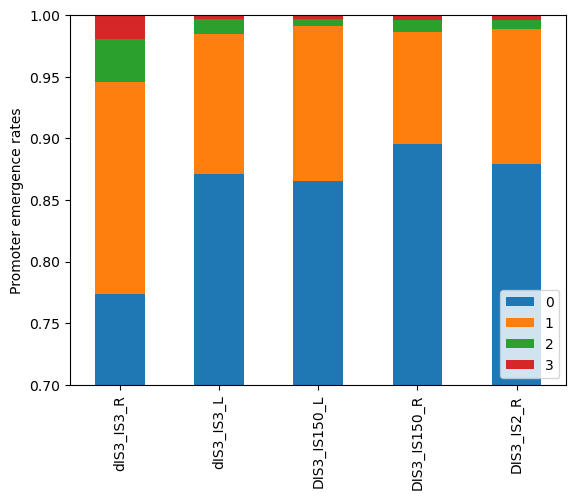

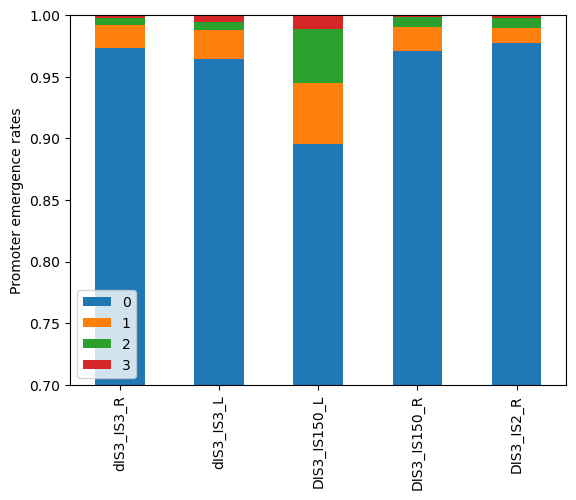

In [17]:
fluors = ['GFP', 'mScarlet']
for Fluor in fluors:

    emergence_dict = {}
    parents = ['dIS3_IS3_R', 'dIS3_IS3_L', 'DIS3_IS150_L', 'DIS3_IS150_R', 'DIS3_IS2_R']
    for parent in parents:
        
        none = 0
        low = 0
        med = 0
        high = 0
        
        for i, row in df.iterrows():
            if parent == row['parent_seq']:
                
                if Fluor == 'GFP':
                    score = np.round(row['GFP_mean'])
                elif Fluor == 'mScarlet':
                    score = np.round(row['mScarlet_mean'])
                
                if score == 1.0:
                    none += 1
                elif score == 2.0:
                    low += 1
                elif score == 3.0:
                    med += 1
                elif score == 4.0:
                    high +=1
                    
        values = [none, low, med, high]
        
        # Normalize the values to percentages
        values = [n/sum(values) for n in values]
        
        # Print the emergence rate:
        print(parent)
        print((1-values[0])*100)
        print("None: " + str(none))
        print("Low: " + str(low))
        print("Med: " + str(med))
        print("High: " + str(high))
        print()
        
        # Add to the dictionary
        emergence_dict[parent] = values
        
    # Convert the dictionary to a DataFrame
    emergence_df = pd.DataFrame(emergence_dict)
    
    # Transpose
    emergence_df = emergence_df.T
    
    # Create a new figure and axes
    fig, ax = plt.subplots()
    
    # Plot
    emergence_df.plot(kind='bar', stacked=True, legend=True, ax=ax)
    ax.set_ylim([0.7, 1])
    plt.ylabel('Promoter emergence rates')

# if Fluor == 'GFP':
#     plt.savefig('GFP_emergence_rates.pdf')
# elif Fluor == 'mScarlet':
#     plt.savefig('mScarlet_emergence_rates.pdf')

### How many daughters per parent?

In [10]:
parents
for parent in parents:
    sub_df = df[df['parent_seq'] == parent]
    print(parent, len(sub_df))

dIS3_IS3_R 1925
dIS3_IS3_L 3013
DIS3_IS150_L 3154
DIS3_IS150_R 6335
DIS3_IS2_R 4110


### How many mutations per daughter?

In [46]:
print(f"median mutations per daughter: {np.median(df['Levenshtein_dist'])}")
print(f"standard deviation: {np.std(df['Levenshtein_dist'])}")

median mutations per daughter: 2.0
standard deviation: 0.604347569847861


### How many daughters have promoter activity in either orientation?

In [207]:
GFP_count = 0
for i, row in df.iterrows():
    if row['GFP_mean'] >= 1.5:
        GFP_count +=1
print(f'{GFP_count} of the {len(df)} daughter sequences have GFP activity >= 1.5 a.u.')

RFP_count = 0
for i, row in df.iterrows():
    if row['mScarlet_mean'] >= 1.5:
        RFP_count +=1
print(f'{RFP_count} of the {len(df)} daughter sequences have RFP activity >= 1.5 a.u.')

bi_count = 0
for i, row in df.iterrows():
    if row['GFP_mean'] >= 1.5 and row['mScarlet_mean'] >= 1.5:
        bi_count +=1
print(f'{bi_count} of the {len(df)} daughter sequences have bidirectional activity >= 1.5 a.u.')

2408 of the 18537 daughter sequences have GFP activity >= 1.5 a.u.
765 of the 18537 daughter sequences have RFP activity >= 1.5 a.u.
113 of the 18537 daughter sequences have bidirectional activity >= 1.5 a.u.


In [222]:
sub_df = df[df['Levenshtein_dist'] == 1]
count = 0
for i, row in sub_df.iterrows():
    if row['GFP_mean'] >= 1.5 or row['mScarlet_mean'] >= 1.5:
        count += 1
print(f'{count} out of {len(sub_df)} single mutants are promoters on either GFP or RFP strand.')
print(100 * count / len(sub_df))
print()

sub_df = df[df['Levenshtein_dist'] == 2]
count = 0
for i, row in sub_df.iterrows():
    if row['GFP_mean'] >= 1.5 or row['mScarlet_mean'] >= 1.5:
        count += 1
print(f'{count} out of {len(sub_df)} double mutants are promoters on either GFP or RFP strand.')
print(100 * count / len(sub_df))
print()

sub_df = df[df['Levenshtein_dist'] == 3]
count = 0
for i, row in sub_df.iterrows():
    if row['GFP_mean'] >= 1.5 or row['mScarlet_mean'] >= 1.5:
        count += 1
print(f'{count} out of {len(sub_df)} triple mutants are promoters on either GFP or RFP strand.')
print(100 * count / len(sub_df))
print()

sub_df = df[df['Levenshtein_dist'] >= 4]
count = 0
for i, row in sub_df.iterrows():
    if row['GFP_mean'] >= 1.5 or row['mScarlet_mean'] >= 1.5:
        count += 1
print(f'{count} out of {len(sub_df)} quadruple+ mutants are promoters on either GFP or RFP strand.')
print(100 * count / len(sub_df))
print()


233 out of 1549 single mutants are promoters on either GFP or RFP strand.
15.041962556488057

2343 out of 14663 double mutants are promoters on either GFP or RFP strand.
15.978994748687171

328 out of 1710 triple mutants are promoters on either GFP or RFP strand.
19.181286549707604

156 out of 615 quadruple+ mutants are promoters on either GFP or RFP strand.
25.365853658536587



In [226]:
# Filter for single mutants
sub_df = df[df['Levenshtein_dist'] == 1]

# Counters for each category
weak = 0
moderate = 0
strong = 0
off = 0

for i, row in sub_df.iterrows():
    GFP = row['GFP_mean']
    RFP = row['mScarlet_mean']

    # Check GFP and RFP for weak, moderate, or strong activity
    if 1.5 <= GFP < 2.5 or 1.5 <= RFP < 2.5:
        weak += 1
    elif 2.5 <= GFP < 3.5 or 2.5 <= RFP < 3.5:
        moderate += 1
    elif GFP >= 3.5 or RFP >= 3.5:
        strong += 1
    else:
        off +=1

# Print the results
total = len(sub_df)
print(f'{weak} out of {total} single mutants are weak promoters.')
print(f'{moderate} out of {total} single mutants are moderate promoters.')
print(f'{strong} out of {total} single mutants are strong promoters.')
print(f'{off} out of {total} single mutants are NOT promoters.')

# Check consistency
total_promoters = weak + moderate + strong + off
print(f'Total: {total_promoters} (Expected: {total})')


224 out of 1549 single mutants are weak promoters.
7 out of 1549 single mutants are moderate promoters.
2 out of 1549 single mutants are strong promoters.
1316 out of 1549 single mutants are NOT promoters.
Total: 1549 (Expected: 1549)


In [225]:
# Filter for 4+ mutants
sub_df = df[df['Levenshtein_dist'] >= 4]

# Counters for each category
weak = 0
moderate = 0
strong = 0
off = 0

for i, row in sub_df.iterrows():
    GFP = row['GFP_mean']
    RFP = row['mScarlet_mean']

    # Check GFP and RFP for weak, moderate, or strong activity
    if 1.5 <= GFP < 2.5 or 1.5 <= RFP < 2.5:
        weak += 1
    elif 2.5 <= GFP < 3.5 or 2.5 <= RFP < 3.5:
        moderate += 1
    elif GFP >= 3.5 or RFP >= 3.5:
        strong += 1
    else:
        off +=1

# Print the results
total = len(sub_df)
print(f'{weak} out of {total} 4+ mutants are weak promoters.')
print(f'{moderate} out of {total} 4+ mutants are moderate promoters.')
print(f'{strong} out of {total} 4+ mutants are strong promoters.')
print(f'{off} out of {total} 4+ mutants are NOT promoters.')

# Check consistency
total_promoters = weak + moderate + strong + off
print(f'Total: {total_promoters} (Expected: {total})')


111 out of 615 4+ mutants are weak promoters.
28 out of 615 4+ mutants are moderate promoters.
17 out of 615 4+ mutants are strong promoters.
459 out of 615 4+ mutants are NOT promoters.
Total: 615 (Expected: 615)


## 1e Pnew boxplot

In [27]:
RFP_pnews = []
GFP_pnews = []

for parent in parents:
    sub_df = df[df['parent_seq'] == parent]
    GFP_scores = sub_df['GFP_mean'].to_list()
    GFP_on = [n for n in GFP_scores if n >= 1.5]
    GFP_pnew = len(GFP_on)/len(GFP_scores)
    print(f'{parent} GFP: {GFP_pnew}')
    GFP_pnews.append(100*GFP_pnew)
    
    RFP_scores = sub_df['mScarlet_mean'].to_list()
    RFP_on = [n for n in RFP_scores if n >= 1.5]
    RFP_pnew = len(RFP_on)/len(RFP_scores)
    print(f'{parent} RFP: {RFP_pnew}')
    RFP_pnews.append(100*RFP_pnew)
    print()

dIS3_IS3_R GFP: 0.2264935064935065
dIS3_IS3_R RFP: 0.027012987012987013

dIS3_IS3_L GFP: 0.12910720212412877
dIS3_IS3_L RFP: 0.035512777962163955

DIS3_IS150_L GFP: 0.13474952441344323
DIS3_IS150_L RFP: 0.10431198478123019

DIS3_IS150_R GFP: 0.10434096290449882
DIS3_IS150_R RFP: 0.02888713496448303

DIS3_IS2_R GFP: 0.12092457420924574
DIS3_IS2_R RFP: 0.022871046228710463



(0.0, 25.0)

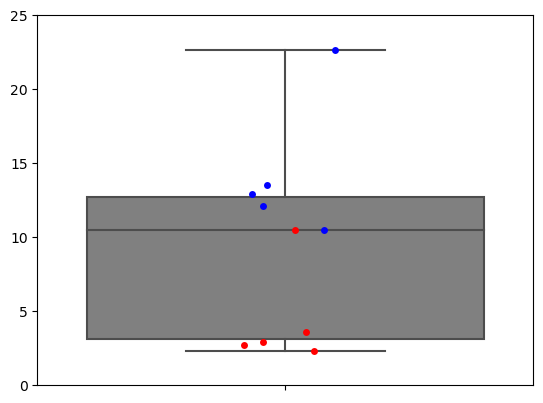

In [29]:
combined_pnews = GFP_pnews + RFP_pnews

sns.boxplot(y=combined_pnews, color='gray')
sns.stripplot(y=RFP_pnews, color='red')
sns.stripplot(y=GFP_pnews, color='blue')

plt.ylim(0,25)
#plt.savefig("figure_2E.pdf")

## 1f fluorescence scores stacked barplots

In [169]:
# # The dictionary to add all of the HD data
HD_dictionary = {}

# Lists for the HD dictionary
hd1 = []
hd2 = []
hd3 = []
hd4plus = []

parents = ['dIS3_IS3_R', 'dIS3_IS3_L', 'DIS3_IS150_L', 'DIS3_IS150_R', 'DIS3_IS2_R']
for parent in parents:

    # Re-parse all of the seqeunces into categories based on the number of mutations they have
    for i, row in df.iterrows():

        # Only look at the respective parent sequence for the HD calculation
        if row['parent_seq'] == parent:

            # Calculate the hamming distance
            HD = row['Levenshtein_dist']

            # Get the scores
            GFP = np.round(row['GFP_mean'])
            RFP = np.round(row['mScarlet_mean'])

            # Parse the scores
            if HD == 1:
                hd1.append(GFP)
                hd1.append(RFP)
            elif HD == 2:
                hd2.append(GFP)
                hd2.append(RFP)
            elif HD == 3:
                hd3.append(GFP)
                hd3.append(RFP)
            elif HD >= 4:
                hd4plus.append(GFP)
                hd4plus.append(RFP)

HD_dictionary[1] = hd1.count(1), hd1.count(2), hd1.count(3), hd1.count(4)
HD_dictionary[2] = hd2.count(1), hd2.count(2), hd2.count(3), hd2.count(4)
HD_dictionary[3] = hd3.count(1), hd3.count(2), hd3.count(3), hd3.count(4)
HD_dictionary[4] = hd4plus.count(1), hd4plus.count(2), hd4plus.count(3), hd4plus.count(4)

# Convert the dictionary to a DataFrame
emergence_df = pd.DataFrame(HD_dictionary)
emergence_df

1      2     3     4
0  2855  26904  3080  1062
1   233   1968   216   116
2     8    342    85    34
3     2    112    39    18

In [ ]:
# normalize the dataframe
for n in range(4):    
    working_list = HD_dictionary[n+1]
    
    # normalize
    list_sum = np.sum(working_list)
    norm_list = [n/list_sum for n in working_list]
    
    emergence_df[n+1] = norm_list


emergence_df

Text(0, 0.5, 'Promoter emergence rates')

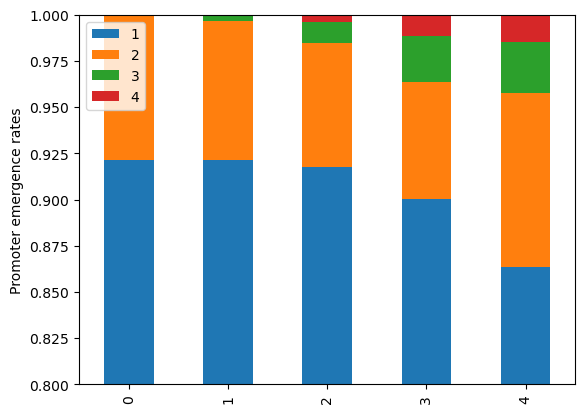

In [167]:
emergence_df = emergence_df.T

# Create a new figure and axes
fig, ax = plt.subplots()

# Plot
emergence_df.plot(kind='bar', stacked=True, legend=True, ax=ax)
ax.set_ylim([0.8, 1])
plt.ylabel('Promoter emergence rates')

## 1h scatterplot dinucleotide interactions

In [18]:
observed_values = []
expected_values = []

fluors = ['GFP_mean', 'mScarlet_mean']
for record in SeqIO.parse("k12_dIs3s.fasta", 'fasta'):
    parent = str(record.id)
    parent_sequence = str(record.seq)

    for Fluor in fluors:
        #print(Fluor)
    
        # Isolate 150 bp seqeunces with single point mutations (df1 = 1 mutation)
        df1 = df[(df['Levenshtein_dist'] == 1)]
        df1 = df1[df1['sequence'].str.len() == 150]
        df1 = df1[(df1['parent_seq'] == parent)]
        
        # Create a single mutation dictionary:
        single_mut_dictionary = {}
        for i, row in df1.iterrows():
            daughter = row['sequence']
        
            for n, bp in enumerate(daughter):
                if bp == parent_sequence[n]:
                    pass
                else:
                    #print(f'position: {n}, parent: {parent_sequence[n]}, daughter: {bp}')
                    key = (n, parent_sequence[n], bp)
                    single_mut_dictionary[key] = row[Fluor]
        
        # Turn the keys into a list
        single_mut_keys = list(single_mut_dictionary.keys())
        
        # Get the median GFP value for the parent
        sub_df = df[(df['parent_seq'] == parent)]
        sub_df = sub_df[sub_df['sequence'].str.len() == 150]
        parent_fluorescence = sub_df[Fluor].to_list()
        parent_median = np.median(parent_fluorescence)
        #print(parent_median)
        
        # Isolate 150 bp seqeunces with double point mutations (df2 = 2 mutations)
        df2 = df[(df['Levenshtein_dist'] == 2)]
        df2 = df2[df2['sequence'].str.len() == 150]
        df2 = df2[(df2['parent_seq'] == parent)]
        
        for i, row in df2.iterrows():
            daughter = row['sequence']
        
            # Find the unique mutations in each daughter
            daughter_keys = []
            for n, bp in enumerate(daughter):
                if bp == parent_sequence[n]:
                    pass
                else:
                    #print(f'position: {n}, parent: {parent_sequence[n]}, daughter: {bp}')
                    key = (n, parent_sequence[n], bp)
                    daughter_keys.append(key)
                    #print(key)
        
            # Are these keys in the single_mut_keys list?
            if all(item in single_mut_keys for item in daughter_keys):
        
                # Check for epistasis:
                mutation1 = single_mut_dictionary[daughter_keys[0]] - parent_median
                mutation2 = single_mut_dictionary[daughter_keys[1]] - parent_median
                double_mutation = row[Fluor] - parent_median
                
                # observed and expected values
                observed_value = double_mutation
                observed_values.append(observed_value)
                
                expected_value = mutation1 + mutation2
                expected_values.append(expected_value)

C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'Mutation1 + Mutation2 (expected)')

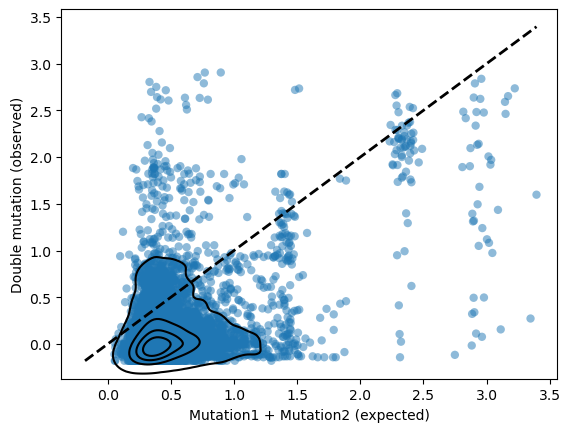

In [19]:
sns.scatterplot(x=expected_values, y=observed_values, edgecolor='none', alpha=0.5)
sns.kdeplot(x=expected_values, y=observed_values, levels=5, fill=False, color='black')

# Add the diagonal line (y = x)
min_val = min(min(expected_values), min(observed_values))
max_val = max(max(expected_values), max(observed_values))
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=2)

plt.ylabel('Double mutation (observed)')
plt.xlabel('Mutation1 + Mutation2 (expected)')

#plt.savefig("antagonistic_vs_synergistic.pdf")

### central tendency

In [37]:
print(np.median(expected_values))
print(np.median(observed_values))

0.4135530271687474
0.0


## 1i pie chart epistasis categories

In [51]:
epistasis_types = []
fluors = ['GFP_mean', 'mScarlet_mean']
for record in SeqIO.parse("k12_dIs3s.fasta", 'fasta'):
    parent = str(record.id)
    parent_sequence = str(record.seq)

    for Fluor in fluors:
        #print(Fluor)
    
        # Isolate 150 bp seqeunces with single point mutations (df1 = 1 mutation)
        df1 = df[(df['Levenshtein_dist'] == 1)]
        df1 = df1[df1['sequence'].str.len() == 150]
        df1 = df1[(df1['parent_seq'] == parent)]
        
        # Create a single mutation dictionary:
        single_mut_dictionary = {}
        for i, row in df1.iterrows():
            daughter = row['sequence']
        
            for n, bp in enumerate(daughter):
                if bp == parent_sequence[n]:
                    pass
                else:
                    #print(f'position: {n}, parent: {parent_sequence[n]}, daughter: {bp}')
                    key = (n, parent_sequence[n], bp)
                    single_mut_dictionary[key] = row[Fluor]
        
        # Turn the keys into a list
        single_mut_keys = list(single_mut_dictionary.keys())
        
        # Get the median GFP value for the parent
        sub_df = df[(df['parent_seq'] == parent)]
        sub_df = sub_df[sub_df['sequence'].str.len() == 150]
        parent_fluorescence = sub_df[Fluor].to_list()
        parent_median = np.median(parent_fluorescence)
        #print(parent_median)
        
        # Isolate 150 bp seqeunces with double point mutations (df2 = 2 mutations)
        df2 = df[(df['Levenshtein_dist'] == 2)]
        df2 = df2[df2['sequence'].str.len() == 150]
        df2 = df2[(df2['parent_seq'] == parent)]
        
        for i, row in df2.iterrows():
            daughter = row['sequence']
        
            # Find the unique mutations in each daughter
            daughter_keys = []
            for n, bp in enumerate(daughter):
                if bp == parent_sequence[n]:
                    pass
                else:
                    #print(f'position: {n}, parent: {parent_sequence[n]}, daughter: {bp}')
                    key = (n, parent_sequence[n], bp)
                    daughter_keys.append(key)
                    #print(key)
        
            # Are these keys in the single_mut_keys list?
            if all(item in single_mut_keys for item in daughter_keys):
        
                #print(daughter_keys)
        
                # Check for epistasis:
                mutation1 = single_mut_dictionary[daughter_keys[0]] - parent_median
                mutation2 = single_mut_dictionary[daughter_keys[1]] - parent_median
                double_mutation = row[Fluor] - parent_median
                
                # Round to the nearest 0.5 value
                mutation1 = np.round(mutation1*2)/2
                mutation2 = np.round(mutation2*2)/2
                double_mutation = np.round(double_mutation*2)/2
    
                ### Classify into epistasis types:
                ### Decision 1: A + B == AB
                if mutation1 + mutation2 == double_mutation:
                    if mutation1 == 0 and mutation2 == 0 and double_mutation == 0:
                        epistasis_type = 'no change'
                    else:
                        epistasis_type = 'additive'
                else:
                    if (mutation1 + mutation2) < double_mutation:
                        epistasis_type = 'synergystic'
                    else:
                        epistasis_type = 'antagonistic'
                    
                epistasis_types.append(epistasis_type)

C:\Users\timot\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\timot\anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Counter({'no change': 6513, 'antagonistic': 5841, 'synergystic': 966, 'additive': 536})


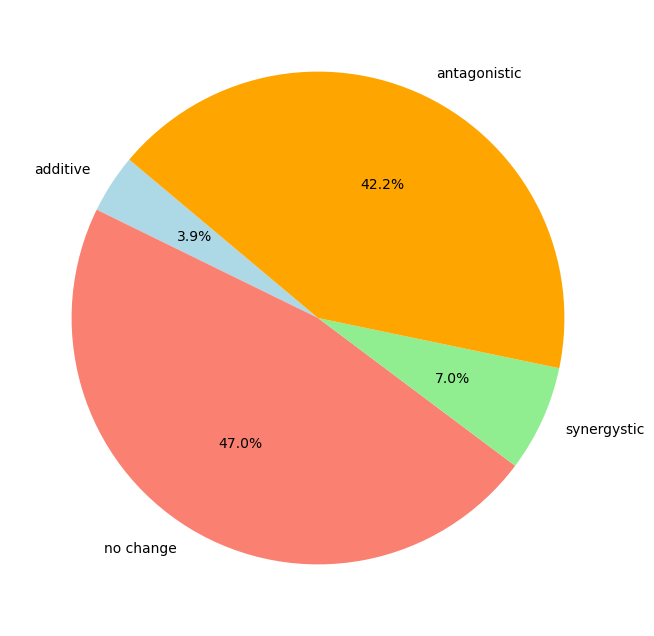

In [52]:
total_types = Counter(epistasis_types)
print(total_types)

# Extract labels and values
labels = list(total_types.keys())
sizes = list(total_types.values())

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'salmon', 'lightgreen', 'orange'])
plt.savefig("pie_chart_antagonistic_synergistic_0.5.pdf")

# Figure 2

### 1L GFP

 total bits: 0.020469010162537753


(0.0, 0.00042997102880907114)

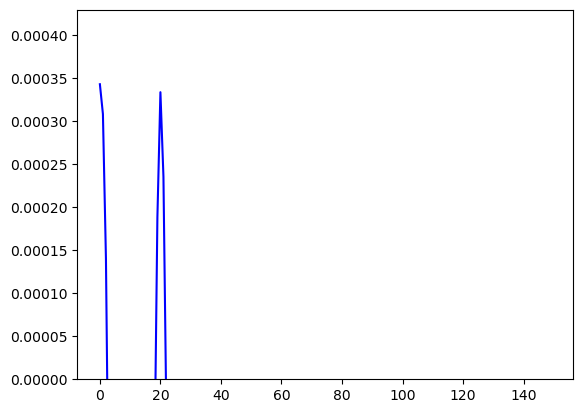

In [77]:
output = calculate_mutual_information('DIS3_IS150_L', 'GFP', 2)
sns.lineplot(x=range(0,len(output)), y=output, color='blue')
plt.ylim(0,)

### 1R GFP

 total bits: 0.03747796362852483


(0.0, 0.0033991467220964564)

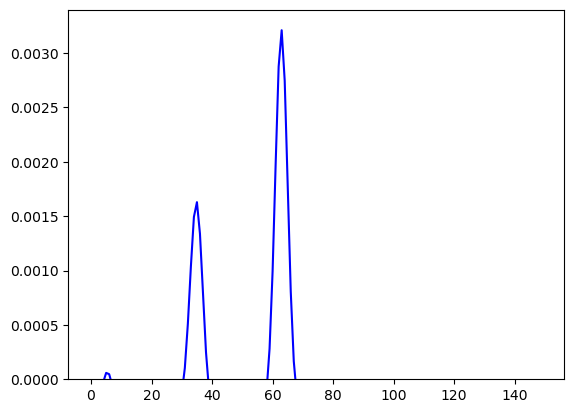

In [79]:
output = calculate_mutual_information('DIS3_IS150_R', 'GFP', 2)
sns.lineplot(x=range(0,len(output)), y=output, color='blue')
plt.ylim(0,)

### 2R GFP

 total bits: 0.014267660545808851


(0.0, 0.00014000932893816845)

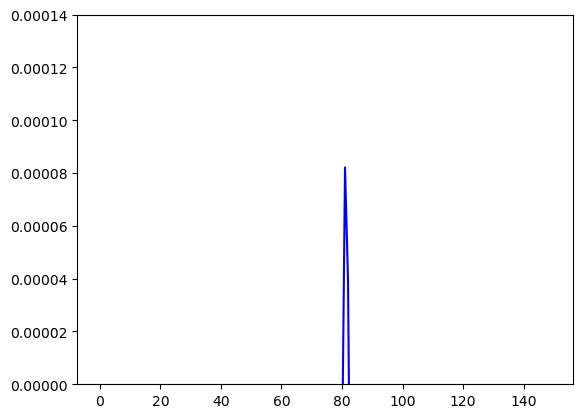

In [81]:
output = calculate_mutual_information('DIS3_IS2_R', 'GFP', 2)
sns.lineplot(x=range(0,len(output)), y=output, color='blue')
plt.ylim(0,)

### 3L GFP

 total bits: 0.042003078601945264


(0.0, 0.0021425153439916036)

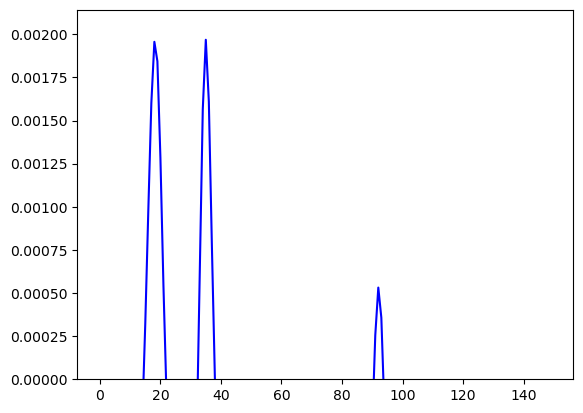

In [83]:
output = calculate_mutual_information('dIS3_IS3_L', 'GFP', 2)
sns.lineplot(x=range(0,len(output)), y=output, color='blue')
plt.ylim(0,)

### 3R GFP

 total bits: 0.16187389867405136


(0.0, 0.016525229014943847)

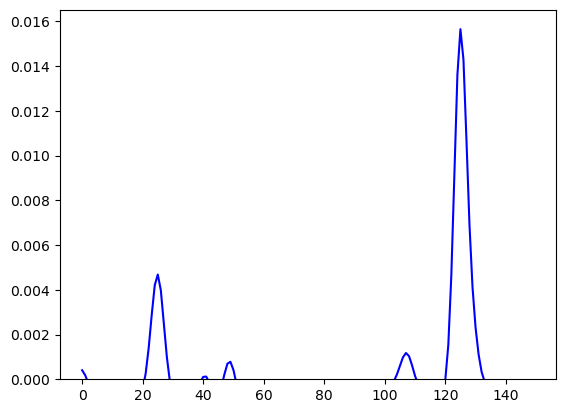

In [85]:
output = calculate_mutual_information('dIS3_IS3_R', 'GFP', 2)
sns.lineplot(x=range(0,len(output)), y=output, color='blue')
plt.ylim(0,)

### 1L RFP

 total bits: 0.40619793374276375


(0.0, 0.04859032373835633)

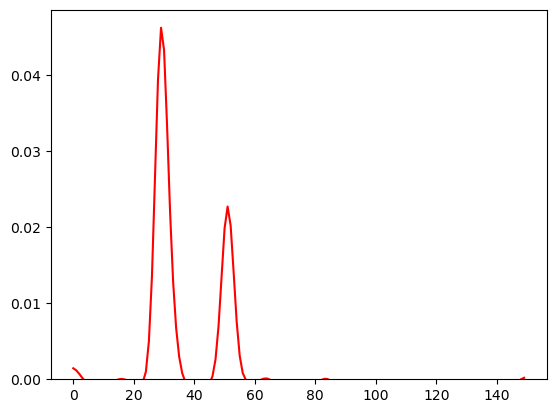

In [87]:
output = calculate_mutual_information('DIS3_IS150_L', 'mScarlet', 2)
sns.lineplot(x=range(0,len(output)), y=output, color='red')
plt.ylim(0,)

### 1R RFP

 total bits: 0.03692560684060251


(0.0, 0.0053248221383370865)

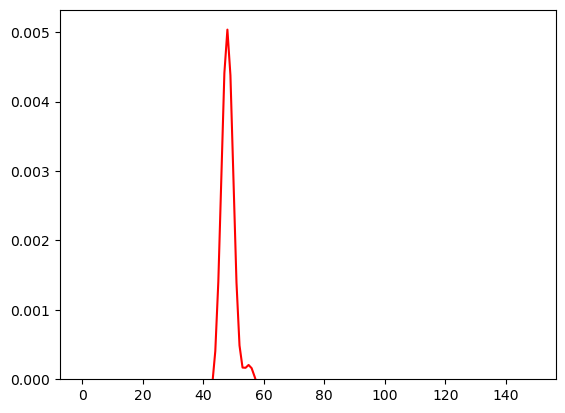

In [89]:
output = calculate_mutual_information('DIS3_IS150_R', 'mScarlet', 2)
sns.lineplot(x=range(0,len(output)), y=output, color='red')
plt.ylim(0,)

### 2R RFP

 total bits: 0.008636232922465705


(0.0, -0.00011703637136805032)

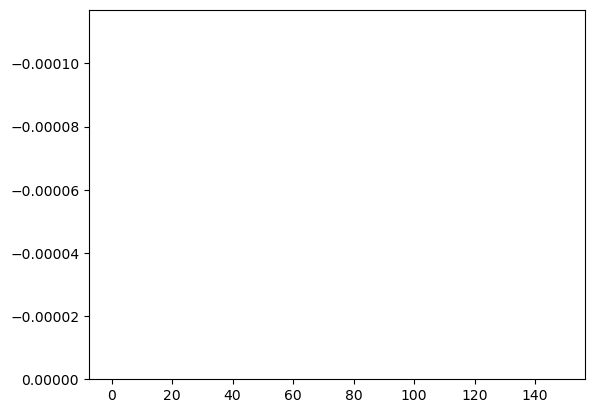

In [91]:
output = calculate_mutual_information('DIS3_IS2_R', 'mScarlet', 2)
sns.lineplot(x=range(0,len(output)), y=output, color='red')
plt.ylim(0,)

### 3L RFP

 total bits: 0.06332735124565833


(0.0, 0.004681462498447848)

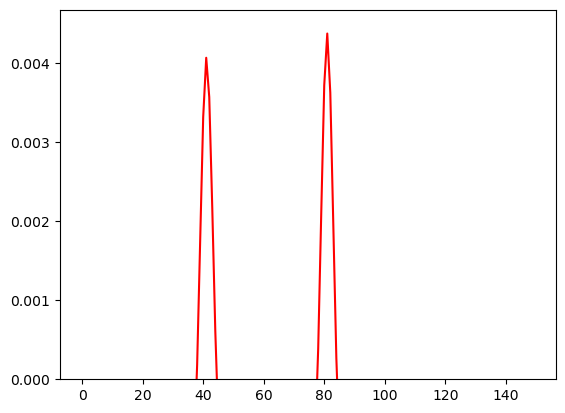

In [93]:
output = calculate_mutual_information('dIS3_IS3_L', 'mScarlet', 2)
sns.lineplot(x=range(0,len(output)), y=output, color='red')
plt.ylim(0,)

### 3R RFP

 total bits: 0.02440129713769452


(0.0, 0.00024282792395828102)

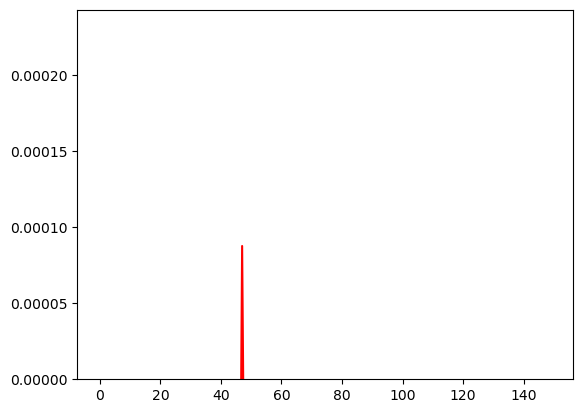

In [95]:
output = calculate_mutual_information('dIS3_IS3_R', 'mScarlet', 2)
sns.lineplot(x=range(0,len(output)), y=output, color='red')
plt.ylim(0,)

# Figure 3

### The analysis (this takes a long time to run - skip to the next cell to load the output)

In [ ]:
### KWARGS: define the following variables:
windows = [6] # size of the sliding window
orientations = ['top','bottom'] # leave if you want to look at both
fluors = ['GFP','mScarlet'] # GFP and RFP
TFs = ['minus10', 'minus35'] # both -10 and -35 boxes

# Which parent sequnces?
filenames = []
for record in SeqIO.parse('k12_dIs3s.fasta', 'fasta'):
    if record.id == 'DIS3_IS2_L':
        pass
    else:
        filenames.append(record.id)    

# Generate all possible combinations of variables from the lists
combinations = itertools.product(orientations, filenames, fluors, TFs, windows)

# Create an empty DataFrame with column names
column_names = ["Orientation", "Parent", "Fluor", "PWM", "Window_size", "P-value", "ROI", "N_without", "N_with", "Fluor_without", "Fluor_with"]
output_df = pd.DataFrame(columns=column_names)

# # Iterate over each combination and call your function with the corresponding inputs
for combination in combinations:
    print(combination)
    
    output = PWM_fluorescence_slide_function(*combination)
    print(output)
    
    if output is None:
        pass
    else:
        
        for n in output: # there can be multiple outputs
            
            # Add the conditions to the row as well
            dataframe_row = list(combination) + n
            
            # Add each row to the dataframe
            row_df = pd.DataFrame([dataframe_row], columns=column_names)
            output_df = pd.concat([output_df, row_df], ignore_index=True)

# Perform Benjamini-Hochberg correction
p_values = output_df['P-value'].to_list()

alpha = 0.05
reject, q_values, _, _ = smm.multipletests(p_values, alpha=alpha, method='fdr_bh')
output_df['Q-value'] = q_values
output_df['status'] = reject

# Computer whether the motif was gained or lost and add to the dataframe
gain_loss = []
for i, row in output_df.iterrows():
    
    # number of motifs in each category
    n_without = row['N_without']
    n_with = row['N_with']
    
    if n_with > n_without:
        gain_loss.append('loss')
    elif n_with < n_without:
        gain_loss.append('gain')
output_df['gain-loss'] = gain_loss

# Calculate the percent change:
pct_changes = []
for i, row in output_df.iterrows():
    if row['gain-loss'] == 'gain':
        after = row['Fluor_with']
        before = row['Fluor_without']
    elif row['gain-loss'] == 'loss':
        before = row['Fluor_with']
        after = row['Fluor_without']
        
    percent_change = ((after-before)/before) * 100
    pct_changes.append(percent_change)
output_df['percent_change'] = pct_changes
    
# Sort the DataFrame by the 'Score' column in descending order
output_df = output_df.sort_values(by='percent_change', ascending=False)

In [14]:
output_df = pd.read_csv("supplemental_data/Data_S3.csv")
output_df

Orientation        Parent     Fluor      PWM  Window_size       P-value  \
0        bottom  DIS3_IS150_L  mScarlet  minus10            6  1.317633e-95   
1           top  DIS3_IS150_R       GFP  minus10            6  5.156156e-15   
2           top  DIS3_IS150_R       GFP  minus10            6  1.269950e-10   
3        bottom  DIS3_IS150_R       GFP  minus10            6  1.269950e-10   
4        bottom  DIS3_IS150_L  mScarlet  minus10            6  8.831153e-49   
..          ...           ...       ...      ...          ...           ...   
429         top  DIS3_IS150_L       GFP  minus10            6  3.646320e-02   
430      bottom  DIS3_IS150_L       GFP  minus10            6  1.664598e-04   
431         top  DIS3_IS150_L       GFP  minus10            6  3.166195e-04   
432         top  DIS3_IS150_L       GFP  minus10            6  7.369716e-04   
433      bottom    dIS3_IS3_R       GFP  minus10            6  2.850573e-03   

            ROI  N_without  N_with  Fluor_without  Fluor_with       Q-value  \
0    [119, 125]       3005     149       1.095238    3.261319  5.718527e-93   
1      [62, 68]       6315      20       1.111111    3.000000  3.196817e-13   
2      [30, 36]       6321      14       1.111111    2.713492  4.592984e-09   
3    [113, 119]       6321      14       1.111111    2.713492  4.592984e-09   
4     [97, 103]       3064      90       1.100000    2.265458  1.916360e-46   
..          ...        ...     ...            ...         ...           ...   
429  [110, 116]       3143      11       1.142857    1.000000  1.248696e-01   
430  [112, 118]       3123      31       1.144444    1.000000  3.010148e-03   
431    [31, 37]       3124      30       1.144444    1.000000  4.907602e-03   
432    [62, 68]       3102      52       1.144444    1.000000  9.138448e-03   
433  [122, 128]       1911      14       1.183196    1.000000  2.474298e-02   

     status gain-loss  percent_change  
0      True      gain      197.772595  
1      True      gain      170.000000  
2      True      gain      144.214286  
3      True      gain      144.214286  
4      True      gain      105.950727  
..      ...       ...             ...  
429   False      gain      -12.500000  
430    True      gain      -12.621359  
431    True      gain      -12.621359  
432    True      gain      -12.621359  
433    True      gain      -15.483185  

[434 rows x 15 columns]

## 3b hotspot #3

below threshold: TGACAT
above threshold: TAACAT
median without motif: 1.1
median with motif: 2.2654579984262115
1.766230669291785e-48


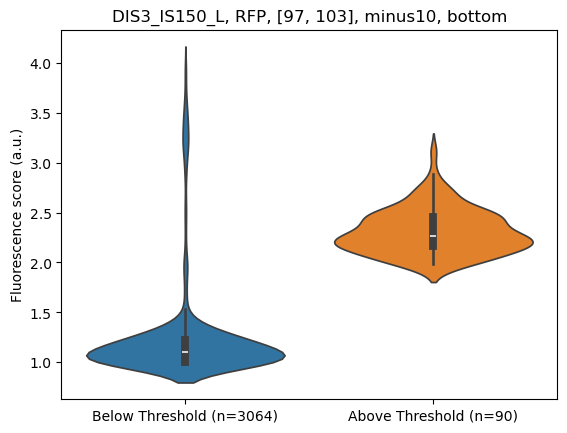

In [15]:
### KWARGS (You can change these values to any row from the output_df)
ID = 'DIS3_IS150_L' #dIS3_IS3_R, dIS3_IS3_L, DIS3_IS150_L, DIS3_IS150_R, DIS3_IS2_R
Fluor = 'RFP' #GFP, RFP
ROI = [97, 103]
TF = 'minus10' # minus10, minus35
orientation = 'bottom' #top, bottom

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

#plt.savefig(f'{ID}_{Fluor}_{str(ROI)}_{TF}_{orientation}.pdf')

## 3c hotspot #4

below threshold: TTTCAT
above threshold: TATCAT
median without motif: 1.0952380952380951
median with motif: 3.261318900277804
2.635265912918045e-95


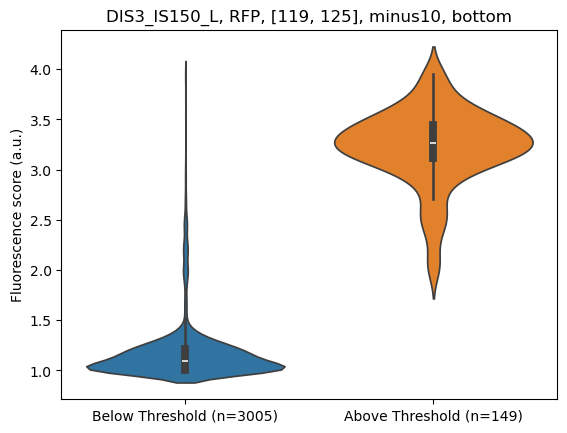

In [103]:
### KWARGS
ID = 'DIS3_IS150_L'
Fluor = 'RFP'
ROI = [119, 125]
TF = 'minus10'
orientation = 'bottom'

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

#plt.savefig(f'{ID}_{Fluor}_{str(ROI)}_{TF}_{orientation}.pdf')

## 3d PWM scores scatterplot

PearsonRResult(statistic=0.6235526365844002, pvalue=0.007481792203660969)


Text(0.5, 0, 'Fluorescence (a.u.)')

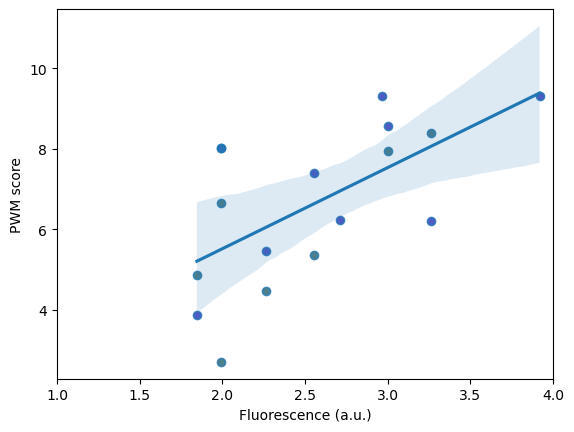

In [16]:
# Open the dataframe
score_df = pd.read_csv("supplemental_data/spacers_and_scores.csv")

# -10 box 
ten_fluor_scores = score_df['Fluorescence'].to_list()
ten_PWM = score_df['PWM 10 score'].to_list()

# -35 box
score_df.replace(0, np.nan, inplace=True)
score_df = score_df.dropna()

thirtyfive_fluor_scores = score_df['Fluorescence'].to_list()
thirtyfive_PWM = score_df['PWM 35 score'].to_list()

PWM_score = ten_PWM + thirtyfive_PWM
fluor_scores = ten_fluor_scores + thirtyfive_fluor_scores

res = stats.pearsonr(fluor_scores, PWM_score)
print(res)

sns.scatterplot(x=ten_fluor_scores, y=ten_PWM, color='magenta')
sns.scatterplot(x=thirtyfive_fluor_scores, y=thirtyfive_PWM, color='orange')
sns.regplot(x=fluor_scores, y=PWM_score)
plt.xlim(1,4)
#plt.ylim(0,10)
plt.ylabel('PWM score')
plt.xlabel("Fluorescence (a.u.)")

## 3e spacer lengths scatterplot

PearsonRResult(statistic=0.22787488986653476, pvalue=0.6231128837331641)


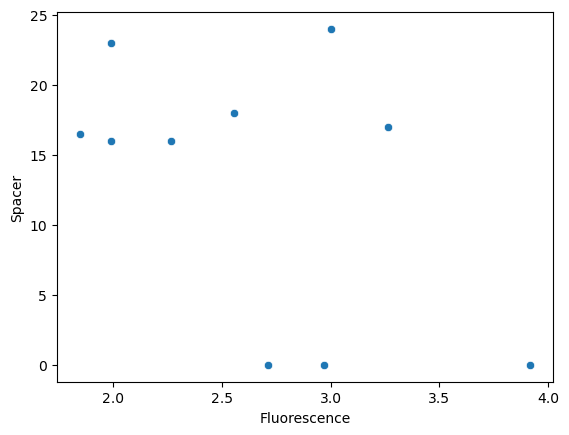

In [18]:
# Open the dataframe
score_df = pd.read_csv("supplemental_data/spacers_and_scores.csv")

sns.scatterplot(data=score_df, y='Spacer', x='Fluorescence')

score_df.replace(0, np.nan, inplace=True)
score_df = score_df.dropna()
res = stats.pearsonr(score_df['Spacer'], score_df['Fluorescence'])
print(res)
#plt.savefig("spacer_vs_fluorescence.pdf")

## 3f opposite strand

In [ ]:
### KWARGS
ID = 'DIS3_IS150_L'
Fluor = 'GFP'
ROI = [97, 103]
TF = 'minus10'
orientation = 'bottom'

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

#plt.savefig(f'{ID}_{Fluor}_{str(ROI)}_{TF}_{orientation}.pdf')

## 3g hotspot #4 opposite strand

In [ ]:
### KWARGS
ID = 'DIS3_IS150_L'
Fluor = 'GFP'
ROI = [119, 125]
TF = 'minus10'
orientation = 'bottom'

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

#plt.savefig(f'{ID}_{Fluor}_{str(ROI)}_{TF}_{orientation}.pdf')

## 3i bidirectional readouts

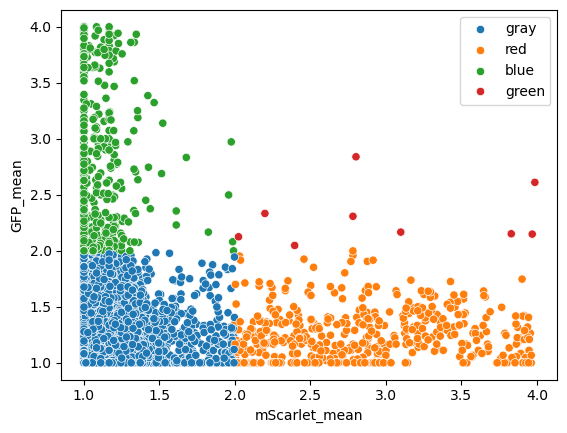

In [49]:
# Create a color array based on the rules
x = df['mScarlet_mean'].to_list()
y = df['GFP_mean'].to_list()

colors = []
for xi, yi in zip(x, y):
    if xi < 2 and yi < 2:
        colors.append('gray')
    elif xi >= 2 and yi < 2:
        colors.append('red')
    elif yi >= 2 and xi < 2:
        colors.append('blue')
    elif xi >= 2 and yi >=2:
        colors.append('green')
        
# Plot
fig = sns.scatterplot(data=df, x='mScarlet_mean', y='GFP_mean', hue=colors)

#plt.savefig('fluorescence_correlations.pdf', format='pdf')

# Figure 4

## 4b top strand

763 promoter signatures on the top strands.


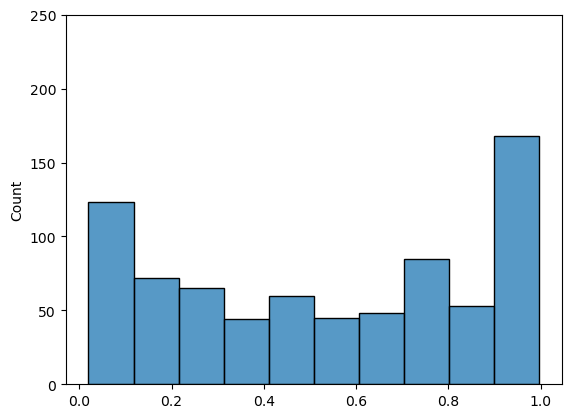

In [17]:
### Where are the motifs?
from itertools import product

all_promoters = []
for record in SeqIO.parse("IS3_all.fasta", 'fasta'):
    IS3_sequence = record.seq
    IS3_promoters = []
    
    # Look for -10 boxes
    ten_positions = []
    for position, score in PSSMs_dict['minus10'].search(IS3_sequence):
        if position >= 0 and score >= threshold_dict['minus10']:
            ten_positions.append(position)
    
    # Look for -35 boxes
    thirtyfive_positions = []
    for position, score in PSSMs_dict['minus35'].search(IS3_sequence):
        if position >= 0 and score >= threshold_dict['minus35']:
            thirtyfive_positions.append(position)
            
    # Calculate all possible pairs
    pairs = product(thirtyfive_positions, ten_positions)
    for a, b in pairs:
        spacer = b - a
        
        # Spacer length = 16-18 bp
        if 15 <= (spacer-6) <= 19:
            IS3_promoters.append(b+6) # Append -10 box position
    
    IS3_promoters = [(n/len(IS3_sequence)) for n in IS3_promoters]
    all_promoters+=(IS3_promoters)
    
# Plot...
sns.histplot(all_promoters, bins=10)
plt.ylim(0,250)

print(f'{len(all_promoters)} promoter signatures on the top strands.')
#plt.savefig("706_IS3s_top_15_to_19_spacer.pdf")

In [19]:
counts, bin_edges = np.histogram(all_promoters, bins=10)
print("Counts per bin:", counts)
print("Bin edges:", bin_edges)

Counts per bin: [123  72  65  44  60  45  48  85  53 168]
Bin edges: [0.02001334 0.11771171 0.21541007 0.31310844 0.4108068  0.50850517
 0.60620354 0.7039019  0.80160027 0.89929863 0.996997  ]
76.3


KS Statistic: 0.11926605504587157
   P-value: 3.7967451901434456e-05
   reject


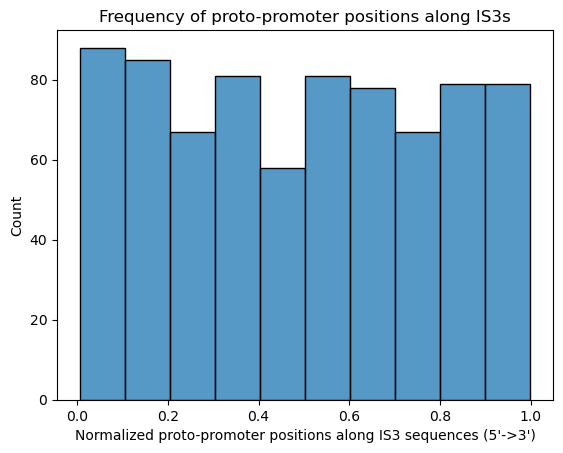

In [125]:
### The Kolmogorov-Smirnov test (kstest)
from scipy.stats import kstest
from scipy.stats import uniform
import numpy as np

# null distribution
np.random.seed(42)
null_distribution = uniform.rvs(0, 1, size=len(all_promoters)) # <-- this entire test is dependent on how you define this function...
#print(null_distribution)

ks_statistic, p_value = kstest(np.array(all_promoters), null_distribution) # The assumption that your data follows a uniform distribution

# Print the test result
print("KS Statistic:", ks_statistic)
print("   P-value:", p_value)
if p_value < 0.05:
    print('   reject')
else:
    print('   fail')
    
# Plot the null distribution
ax = sns.histplot(null_distribution, bins=10).set(title='Frequency of proto-promoter positions along IS3s', xlabel="Normalized proto-promoter positions along IS3 sequences (5'->3')")

## 4b bottom strand

1263 promoter signatures on the bottom strands.


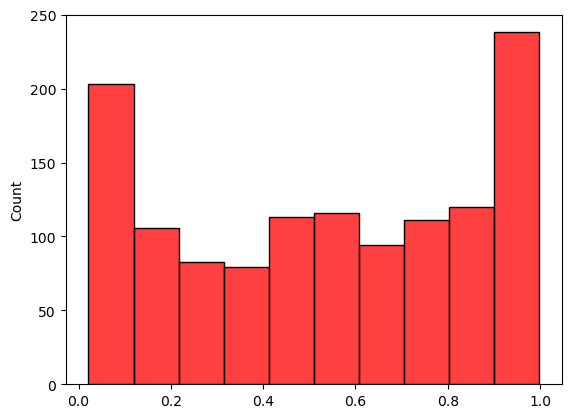

In [15]:
### Where are the motifs?
from itertools import product

all_promoters = []
for record in SeqIO.parse("IS3_all.fasta", 'fasta'):
    IS3_sequence = record.seq
    IS3_sequence = IS3_sequence.reverse_complement()
    IS3_promoters = []
    
    # Look for -10 boxes
    ten_positions = []
    for position, score in PSSMs_dict['minus10'].search(IS3_sequence):
        if position >= 0 and score >= threshold_dict['minus10']:
            ten_positions.append(position)
    
    # Look for -35 boxes
    thirtyfive_positions = []
    for position, score in PSSMs_dict['minus35'].search(IS3_sequence):
        if position >= 0 and score >= threshold_dict['minus35']:
            thirtyfive_positions.append(position)
            
    # Calculate all possible pairs
    pairs = product(thirtyfive_positions, ten_positions)
    for a, b in pairs:
        spacer = b - a
        
        # Spacer length = 16-18 bp
        if 15<= (spacer-6) <= 19:
            IS3_promoters.append(b+6) # Append -35 box position
    
    IS3_promoters = [(n/len(IS3_sequence)) for n in IS3_promoters]
    all_promoters+=(IS3_promoters)
    
# Plot...
sns.histplot(all_promoters, bins=10, color='red')
plt.ylim(0,250)

print(f'{len(all_promoters)} promoter signatures on the bottom strands.')
plt.savefig("706_IS3s_bottom_15_to_19_spacer.pdf")

In [16]:
counts, bin_edges = np.histogram(all_promoters, bins=10)
print("Counts per bin:", counts)
print("Bin edges:", bin_edges)

Counts per bin: [203 106  83  79 113 116  94 111 120 238]
Bin edges: [0.02152522 0.11922628 0.21692735 0.31462841 0.41232948 0.51003054
 0.60773161 0.70543267 0.80313374 0.90083481 0.99853587]


KS Statistic: 0.0958036421219319
   P-value: 1.8232903312839e-05
   reject


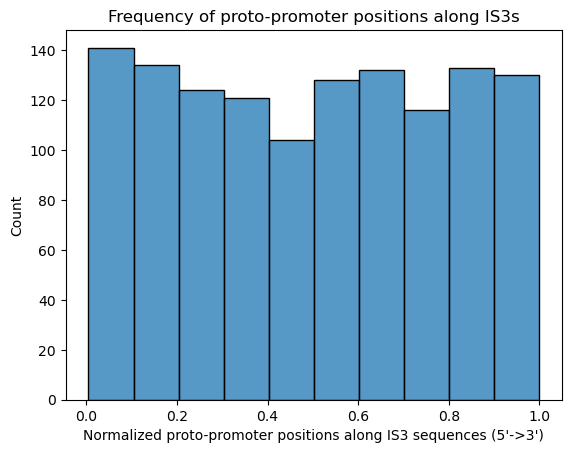

In [127]:
### The Kolmogorov-Smirnov test (kstest)
from scipy.stats import kstest
from scipy.stats import uniform
import numpy as np

# null distribution
np.random.seed(42)
null_distribution = uniform.rvs(0, 1, size=len(all_promoters)) # <-- this entire test is dependent on how you define this function...
#print(null_distribution)

ks_statistic, p_value = kstest(np.array(all_promoters), null_distribution) # The assumption that your data follows a uniform distribution

# Print the test result
print("KS Statistic:", ks_statistic)
print("   P-value:", p_value)
if p_value < 0.05:
    print('   reject')
else:
    print('   fail')
    
# Plot the null distribution
ax = sns.histplot(null_distribution, bins=10).set(title='Frequency of proto-promoter positions along IS3s', xlabel="Normalized proto-promoter positions along IS3 sequences (5'->3')")

## 4d (additional notebook required)

If you want to make the plots without the calculations, proceed to the next cells, which contain the heights of the histograms. Otherwise, proceed as follows:

1) To run Figure 4d, you will need to first download the Lagator model from this Google Drive: https://drive.google.com/drive/folders/1XNmT98PAocvHpWBxGFKF4_EeswSEc5FS
2) Locate in our Github repository another Jupyter notebook titled "Figure_4d.ipynb."
3) Copy "Figure_4d.ipynb" into the following directory in the Lagator model: Brickplot_from_seq/Thermoters_master/notebooks
4) Before running Figure 4d, we strongly recommend running the notebook: "Tutorial_0.ipynb" to first get the model working on your computer.
5) Once you can run the Tutorial, launch Figure_4d.ipynb. You will need to update the directories.

The following cells contain the counts from the histograms in Figure 4d so you do not have to run this notebook but still calculate the K.S. test

## histogram outputs:

### top strand

(0.0, 140.0)

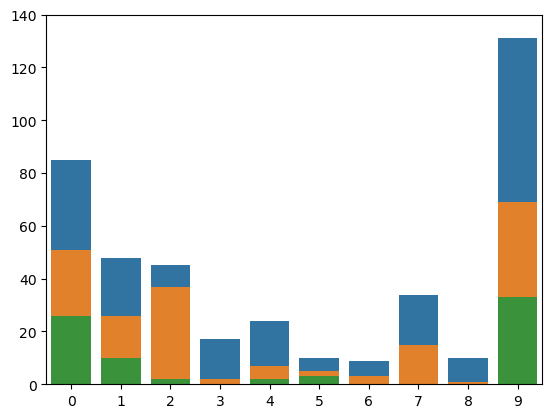

In [156]:
# Top strand probability = 0.5:
top_fifty_percent = [85,48,45,17,24,10,9,34,10,131]
top_seventy_percent = [51,26,37,2,7,5,3,15,1,69]
top_ninety_percent = [26,10,2,0,2,3,0,0,0,33]

sns.barplot(x=range(len(top_fifty_percent)), y=top_fifty_percent)
sns.barplot(x=range(len(top_seventy_percent)), y=top_seventy_percent)
sns.barplot(x=range(len(top_ninety_percent)), y=top_ninety_percent)
plt.ylim(0,140)

In [164]:
### KS test (top strand)
top_strand_counts = top_fifty_percent

# null distribution
np.random.seed(42)
null_distribution = uniform.rvs(0, 1, size=np.sum(top_strand_counts)) # <-- this entire test is dependent on how you define this function...

ks_statistic, p_value = kstest(np.array(top_strand_counts), null_distribution) # The assumption that your data follows a uniform distribution

# Print the test result
print("KS Statistic:", ks_statistic)
print("   P-value:", p_value)
if p_value < 0.05:
    print('   reject')
else:
    print('   fail')
    
# # Plot the null distribution
# ax = sns.histplot(null_distribution, bins=10).set(title='Frequency of proto-promoter positions along IS3s', xlabel="Normalized proto-promoter positions along IS3 sequences (5'->3')")

KS Statistic: 1.0
   P-value: 4.404947085357408e-20
   reject


### bottom strand

<Axes: >

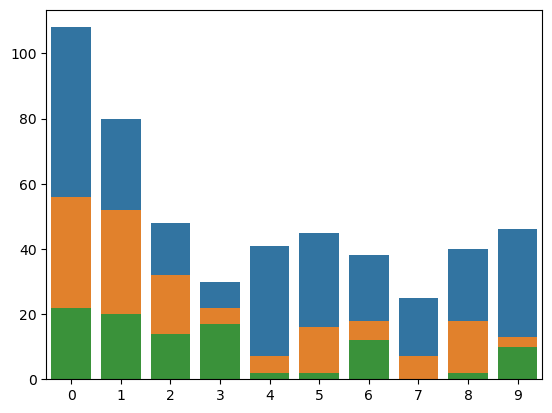

In [161]:
bot_fifty_percent = [108,80,48,30,41,45,38,25,40,46]
bot_seventy_percent = [56,52,32,22,7,16,18,7,18,13]
bot_ninety_percent = [22,20,14,17,2,2,12,0,2,10]

sns.barplot(x=range(len(bot_fifty_percent)), y=bot_fifty_percent)
sns.barplot(x=range(len(bot_seventy_percent)), y=bot_seventy_percent)
sns.barplot(x=range(len(bot_ninety_percent)), y=bot_ninety_percent)

In [163]:
### KS test
bot_strand_counts = bot_fifty_percent

# null distribution
np.random.seed(42)
null_distribution = uniform.rvs(0, 1, size=np.sum(bot_strand_counts)) # <-- this entire test is dependent on how you define this function...

ks_statistic, p_value = kstest(np.array(bot_strand_counts), null_distribution) # The assumption that your data follows a uniform distribution

# Print the test result
print("KS Statistic:", ks_statistic)
print("   P-value:", p_value)
if p_value < 0.05:
    print('   reject')
else:
    print('   fail')
    
# # Plot the null distribution
# ax = sns.histplot(null_distribution, bins=10).set(title='Frequency of proto-promoter positions along IS3s', xlabel="Normalized proto-promoter positions along IS3 sequences (5'->3')")


KS Statistic: 1.0
   P-value: 6.532333737120957e-21
   reject


## 4e proto-10 boxes

In [51]:
from itertools import product

bases = ['A','T','C','G']
sixmers = [''.join(n) for n in product(bases, repeat=6)]
print(f'There are {len(sixmers)} possible 6-mer DNA sequences.')

There are 4096 possible 6-mer DNA sequences.


In [52]:
### Find all possible -10 box instances
ten_instances = []
TF = 'minus10'
for nmer in sixmers:
    for position, score in PSSMs_dict[TF].search(nmer):
        if position>=0 and score >= threshold_dict[TF]:
            ten_instances.append(nmer)
print(f'There are {len(ten_instances)} -10 box instances:')
print(ten_instances)

There are 38 -10 box instances:
['TAAAAT', 'TAAATT', 'TAAACT', 'TAAAGT', 'TAATAT', 'TAATTT', 'TAATCT', 'TAATGT', 'TAACAT', 'TAACCT', 'TAAGAT', 'TATAAT', 'TATATT', 'TATACT', 'TATAGT', 'TATTAT', 'TATTTT', 'TATTCT', 'TATTGT', 'TATCAT', 'TATCTT', 'TATCCT', 'TATCGT', 'TATGAT', 'TATGCT', 'TACAAT', 'TACATT', 'TACACT', 'TACAGT', 'TACTAT', 'TACTCT', 'TAGAAT', 'TAGACT', 'TAGTAT', 'GAAAAT', 'GATAAT', 'GATACT', 'GATTAT']


In [53]:
def generate_nearest_neighbor_mutants(dna_sequence):

    nucleotides = {'A', 'T', 'G', 'C'}  # Possible nucleotides
    mutants = []  # List to store mutants

    for i, original_base in enumerate(dna_sequence):
        # Find all possible substitutions for the current base
        possible_mutations = nucleotides - {original_base}
        for mutation in possible_mutations:
            # Create a mutant by replacing the base at position i
            mutant = dna_sequence[:i] + mutation + dna_sequence[i+1:]
            mutants.append(mutant)
    
    return mutants

In [54]:
### Create a list that has all of the nearest neighbors for all -10 box instances
all_ten_neighbors = []
for ten in ten_instances:
    ten_neighbors = generate_nearest_neighbor_mutants(ten)
    all_ten_neighbors += ten_neighbors

### Remove duplicates
print(len(all_ten_neighbors))
all_ten_neighbors = list(set(all_ten_neighbors))
print(len(all_ten_neighbors))

#### Remove instances in the actual instance list
pseudo_ten_instances = [n for n in all_ten_neighbors if n not in ten_instances]
print(len(pseudo_ten_instances))

684
392
354


## 4f proto-promoters

### Find proto-promoters on the top right and left flanks

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

num_bins = 10

counts_dictionary = {}
for record in SeqIO.parse("IS3_all.fasta", 'fasta'):
    sequence = str(record.seq)
    
    # Partition the sequence into bins
    partitioned_sequences = partition_sequence(sequence, num_bins)

    genome_proto_promoter_frequencies = []
    # Count how many proto-promoters
    for binned_seq in partitioned_sequences:
        
        # How many proto-promoters?
        proto_promoters = find_protopromoters(binned_seq)
        genome_proto_promoter_frequencies.append(len(proto_promoters))

    # Add to a dictionary
    counts_dictionary[record.id] = genome_proto_promoter_frequencies

# Convert to dataframe
skew_df = pd.DataFrame(counts_dictionary)
# Create a DataFrame where each row is repeated and assigned a 'Row' label for seaborn plotting
df_melted = skew_df.T.melt(var_name='Row', value_name='Value')

top_count_dictionary = {}
for i in range(num_bins):
    sub_df_melted = df_melted[df_melted['Row'] == i]
    i_values = sub_df_melted['Value'].to_list()
    top_count_dictionary[i] = i_values

f_statistic, p_value = f_oneway(*top_count_dictionary.values())
print(p_value)

8.048854568856569e-19


In [56]:
top_left_dist = top_count_dictionary[0]
top_right_dist = top_count_dictionary[9]

### Find proto-promoters on the bottom right and left flanks

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

num_bins = 10

counts_dictionary = {}
for record in SeqIO.parse("IS3_all.fasta", 'fasta'):
    
    # reverse complement
    sequence = str((record.seq).reverse_complement())
    
    # Partition the sequence into bins
    partitioned_sequences = partition_sequence(sequence, num_bins)

    genome_proto_promoter_frequencies = []
    # Count how many proto-promoters
    for binned_seq in partitioned_sequences:
        
        # How many proto-promoters?
        proto_promoters = find_protopromoters(binned_seq)
        genome_proto_promoter_frequencies.append(len(proto_promoters))

    # Add to a dictionary
    counts_dictionary[record.id] = genome_proto_promoter_frequencies

# Convert to dataframe
skew_df = pd.DataFrame(counts_dictionary)
# Create a DataFrame where each row is repeated and assigned a 'Row' label for seaborn plotting
df_melted = skew_df.T.melt(var_name='Row', value_name='Value')

bot_count_dictionary = {}
for i in range(num_bins):
    sub_df_melted = df_melted[df_melted['Row'] == i]
    i_values = sub_df_melted['Value'].to_list()
    bot_count_dictionary[i] = i_values

f_statistic, p_value = f_oneway(*bot_count_dictionary.values())
print(p_value)

2.3651669180286567e-29


In [58]:
bot_right_dist = bot_count_dictionary[0]
bot_left_dist = bot_count_dictionary[9]

### genomic tiles

In [59]:
cropped_genome_list = []

#window_size = np.round(np.median(IS3_lengths)/10)
window_size = 127

for record in SeqIO.parse("genome.fasta", 'fasta'):
    genome = record.seq
    print(f'The genome is {len(genome)} bp long.')

    # Loop through the genome in steps of 1000
    for window_start in range(0, len(genome), window_size):
        window_end = window_start + window_size

        # Ensure the window doesn't exceed the genome length
        if window_end <= len(genome):
            crop_genome = genome[window_start:window_end]
            cropped_genome_list.append(crop_genome)

print(f'Number of cropped fragments: {len(cropped_genome_list)}')

The genome is 4641652 bp long.
Number of cropped fragments: 36548


In [60]:
genome_proto_promoter_frequencies = []
for sequence in cropped_genome_list:
    proto_promoters = find_protopromoters(sequence)
    genome_proto_promoter_frequencies.append(len(proto_promoters))

### combine for the figure

KruskalResult(statistic=303.1689304939455, pvalue=2.244985400008174e-64)


1             2             3             4             5
1  1.000000e+00  1.000000e+00  1.088794e-08  1.338349e-04  2.194497e-04
2  1.000000e+00  1.000000e+00  9.537939e-07  3.265973e-03  1.099877e-06
3  1.088794e-08  9.537939e-07  1.000000e+00  8.149470e-01  2.044790e-36
4  1.338349e-04  3.265973e-03  8.149470e-01  1.000000e+00  4.520097e-24
5  2.194497e-04  1.099877e-06  2.044790e-36  4.520097e-24  1.000000e+00

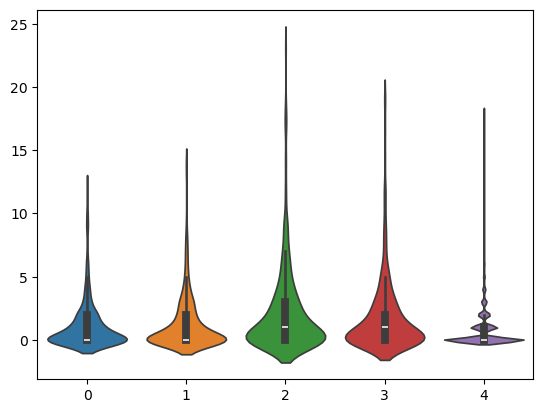

In [61]:
from scipy import stats

data = [top_left_dist, top_right_dist, bot_left_dist, bot_right_dist, genome_proto_promoter_frequencies]
sns.violinplot(data=data)

# Similar to ANOVA but its non-parametric
output = stats.kruskal(top_left_dist, top_right_dist, bot_left_dist, bot_right_dist, genome_proto_promoter_frequencies)
print(output)



sp.posthoc_dunn(data, p_adjust = 'bonferroni')

In [118]:
### What percent of each category has at least one promoter?

top_left_count = len([n for n in top_left_dist if n >= 1])
print(f'top left: ~{np.round(100*top_left_count/len(top_left_dist))} % have at least one proto-promoter')

top_right_count = len([n for n in top_right_dist if n >= 1])
print(f'top right: ~{np.round(100*top_right_count/len(top_right_dist))} % have at least one proto-promoter')

bot_left_count = len([n for n in bot_left_dist if n >= 1])
print(f'bottom left: ~{np.round(100*bot_left_count/len(bot_left_dist))} % have at least one proto-promoter')

bot_right_count = len([n for n in bot_right_dist if n >= 1])
print(f'bottom right: ~{np.round(100*bot_right_count/len(bot_right_dist))} % have at least one proto-promoter')

genome_count = len([n for n in genome_proto_promoter_frequencies if n >=1])
print(f'genome: ~{np.round(100*genome_count/len(genome_proto_promoter_frequencies))} % have at least one proto-promoter')

top left: ~45.0 % have at least one proto-promoter
top right: ~45.0 % have at least one proto-promoter
bottom left: ~56.0 % have at least one proto-promoter
bottom right: ~53.0 % have at least one proto-promoter
genome: ~39.0 % have at least one proto-promoter


### How many of the IS3s have promoter signatures? How many on their flanks?

In [21]:
### Top strand
top_strand_signatures = {}
for record in SeqIO.parse("IS3_all.fasta", 'fasta'):
    IS3_sequence = record.seq
    IS3_promoters = []
    
    # Look for -10 boxes
    ten_positions = []
    for position, score in PSSMs_dict['minus10'].search(IS3_sequence):
        if position >= 0 and score >= threshold_dict['minus10']:
            ten_positions.append(position)
    
    # Look for -35 boxes
    thirtyfive_positions = []
    for position, score in PSSMs_dict['minus35'].search(IS3_sequence):
        if position >= 0 and score >= threshold_dict['minus35']:
            thirtyfive_positions.append(position)
            
    # Calculate all possible pairs
    pairs = product(thirtyfive_positions, ten_positions)
    for a, b in pairs:
        spacer = b - a
        
        # Spacer length = 16-18 bp
        if 15 <= (spacer-6) <= 19:
            IS3_promoters.append(b+6) # Append -10 box position
    
    IS3_promoters = [(n/len(IS3_sequence)) for n in IS3_promoters]

    # Add to dictionary
    top_strand_signatures[record.id] = IS3_promoters

In [22]:
### Bottom strand
bot_strand_signatures = {}
for record in SeqIO.parse("IS3_all.fasta", 'fasta'):
    IS3_sequence = record.seq
    IS3_sequence = IS3_sequence.reverse_complement()
    IS3_promoters = []
    
    # Look for -10 boxes
    ten_positions = []
    for position, score in PSSMs_dict['minus10'].search(IS3_sequence):
        if position >= 0 and score >= threshold_dict['minus10']:
            ten_positions.append(position)
    
    # Look for -35 boxes
    thirtyfive_positions = []
    for position, score in PSSMs_dict['minus35'].search(IS3_sequence):
        if position >= 0 and score >= threshold_dict['minus35']:
            thirtyfive_positions.append(position)
            
    # Calculate all possible pairs
    pairs = product(thirtyfive_positions, ten_positions)
    for a, b in pairs:
        spacer = b - a
        
        # Spacer length = 16-18 bp
        if 15 <= (spacer-6) <= 19:
            IS3_promoters.append(b+6) # Append -10 box position
    
    IS3_promoters = [(n/len(IS3_sequence)) for n in IS3_promoters]

    # Add to dictionary
    bot_strand_signatures[record.id] = IS3_promoters

In [29]:
#### top strand left flank and top strand right flank
top_left = []
top_right = []
for key in top_strand_signatures.keys():
    signature_coordinates = top_strand_signatures[key]
    for n in signature_coordinates:
        if n < 0.1:
            top_left.append(key)
        if n >= 0.9:
            top_right.append(key)
            
#### top strand left flank and top strand right flank
bot_left = []
bot_right = []
for key in bot_strand_signatures.keys():
    signature_coordinates = bot_strand_signatures[key]
    for n in signature_coordinates:
        if n < 0.1:
            bot_right.append(key)
        if n >= 0.9:
            bot_left.append(key)
            
# Print
print(f'top left: {len(top_left)} of 706 IS3s')
print(f'top right: {len(top_right)} of 706 IS3s')
print(f'bottom left: {len(bot_left)} of 706 IS3s')
print(f'bottom right: {len(bot_right)} of 706 IS3s')

# How many of the 706 IS3s?
outward_promoters_set = top_right + top_left
outward_promoters_set = list(set(outward_promoters_set)) # convert to set because you may have duplicates...
print(len(outward_promoters_set))

top left: 106 of 706 IS3s
top right: 167 of 706 IS3s
bottom left: 238 of 706 IS3s
bottom right: 169 of 706 IS3s
181


# Figure S1

## S1a - GFP levels vs promoter distance

   Well Position   OD600  GFP  GFP-background  OD-background      GFP/OD
0    A1        3  0.4484  123      107.333333       0.356467  301.103423
1    A2        3  0.4521  121      105.333333       0.360167  292.457196
2    A3        3  0.4738  128      112.333333       0.381867  294.168994
3    A4        3  0.4832  123      107.333333       0.391267  274.322713
4    A5        3  0.5011  132      116.333333       0.409167  284.317719
..  ...      ...     ...  ...             ...            ...         ...
67   F8      983  0.6097  115       99.333333       0.517767  191.849611
68   F9      983  0.5921  117      101.333333       0.500167  202.599134
69  F10      983  0.5183   98       82.333333       0.426367  193.104527
70  F11      983  0.4650   93       77.333333       0.373067  207.290922
71  F12      983  0.5325  106       90.333333       0.440567  205.038965

[72 rows x 7 columns]


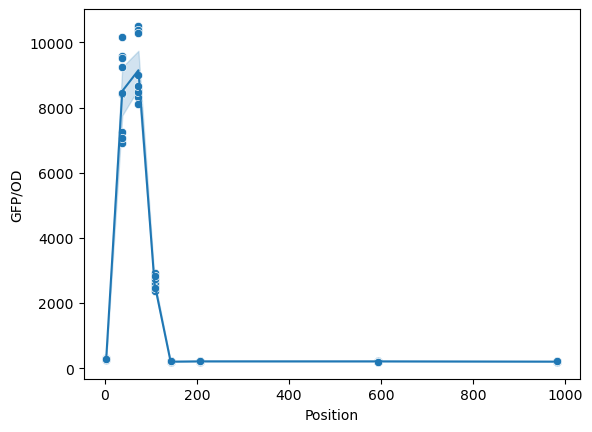

In [20]:
distance_df = pd.read_csv('supplemental_data/2022-04-27_x75164_promoter_spacing.csv', sep=';')
distance_df = distance_df.drop(np.arange(72,96,1)) # Drop by the integer values
print(distance_df)

intensity_list = pd.to_numeric(distance_df['GFP/OD'])
position_list = pd.to_numeric(distance_df['Position'])

plot = sns.lineplot(y=intensity_list, x=position_list)
plot = sns.scatterplot(y=intensity_list, x=position_list)

## S1b UTR length distribution

<Axes: >

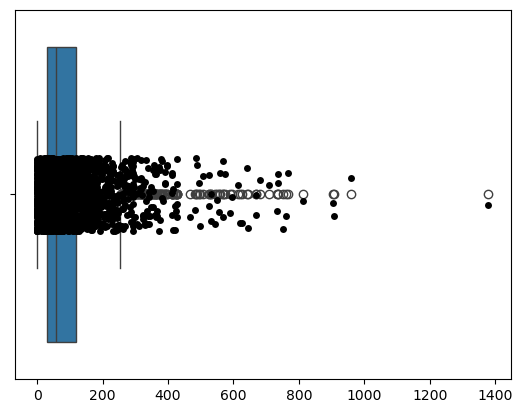

In [23]:
UTR_df = pd.read_csv('supplemental_data/UTR_5_3_sequence.csv', index_col=False, header=0)
#print(UTR_df.head())

five_ps = UTR_df["5' UTR Sequence"].tolist()

lengths = []
for n in range(len(five_ps)):
    lengths.append(len(five_ps[n]))
     

ax = sns.boxplot(x=lengths)
sns.stripplot(x=lengths, color='black')

# Figure S2

## S1c control fluorescence diagrams

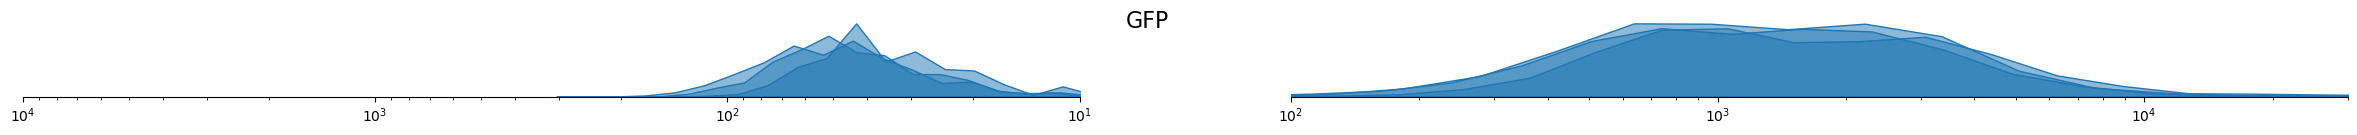

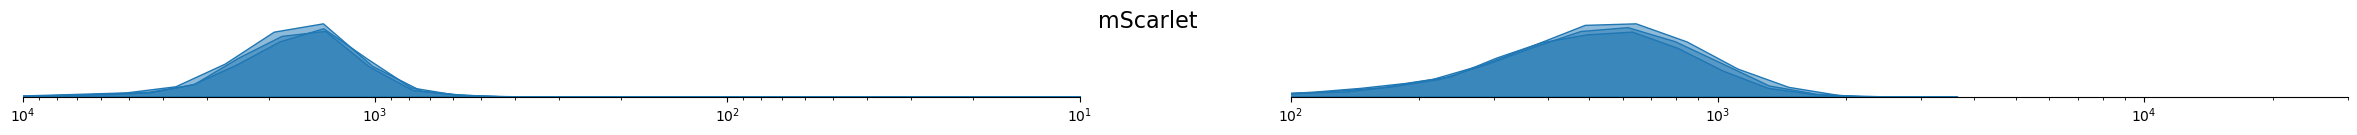

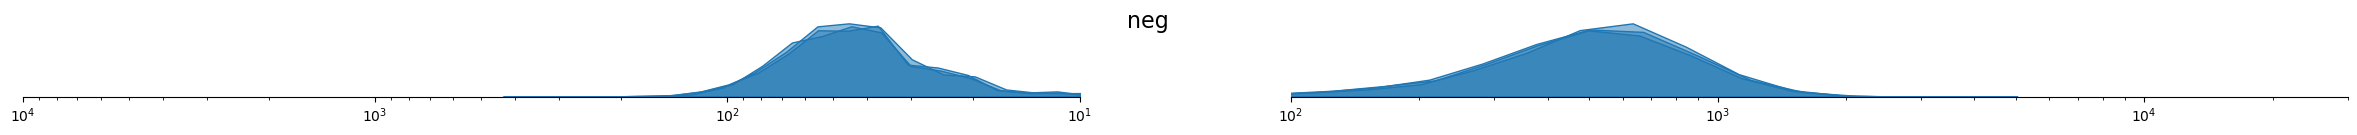

In [25]:
base_file_names = ['GFP','mScarlet','neg']
fcsfiles = ['WT-dIS3s_GFP_001_001.fcs', 'WT-dIS3s_GFP_002_002.fcs', 'WT-dIS3s_GFP_003_003.fcs',
            'WT-dIS3s_mScarlet_001_004.fcs', 'WT-dIS3s_mScarlet_002_005.fcs','WT-dIS3s_mScarlet_003_006.fcs',
            'WT-dIS3s_neg_001_007.fcs', 'WT-dIS3s_neg_002_008.fcs', 'WT-dIS3s_neg_003_009.fcs']
fcsfiles = ['fcs_files/'+n for n in fcsfiles]

# Plot the data
for base_file in base_file_names:
    
    # Create a new figure for each base_file
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(30, 1))
    fig.suptitle(base_file, fontsize=16)

    for file in fcsfiles: 
        if base_file in file:
    
            s = FlowCal.io.FCSData(file)
            
            # Get the GFP values
            GFP = s[:, ['FITC-H']]
            GFP = GFP +1 # Otherwise the log scaling doesn't work...

            # Get the mCherry values
            mScarlet = s[:, ['PE-H']]
            mScarlet = mScarlet +1 # Otherwise the log scaling doesn't work...
            
            # Plot the mScarlet       
            sns.histplot(mScarlet, bins=30, element='poly', color='greens', log_scale=True, ax=ax1, legend=False, alpha=0.5)
            ax1.set_xlim([10, 10000])
            ax1.set(ylabel=None)
            ax1.invert_xaxis()
            ax1.set(yticklabels=[])  # remove the tick labels
            ax1.tick_params(left=False)  # remove the ticks

            # Plot the GFP
            sns.histplot(GFP, bins=30, element='poly', log_scale=True, ax=ax2, legend=False, alpha=0.5)        
            ax2.set_xlim([100, 30000])
            ax2.set(ylabel=None)
            ax2.set(yticklabels=[])  # remove the tick labels
            ax2.tick_params(left=False)  # remove the ticks
            
            # Remove the boxes
            sns.despine(bottom = False, left = True)

# Figure S3

## S3a wild-type parent sequence fluorescence scores

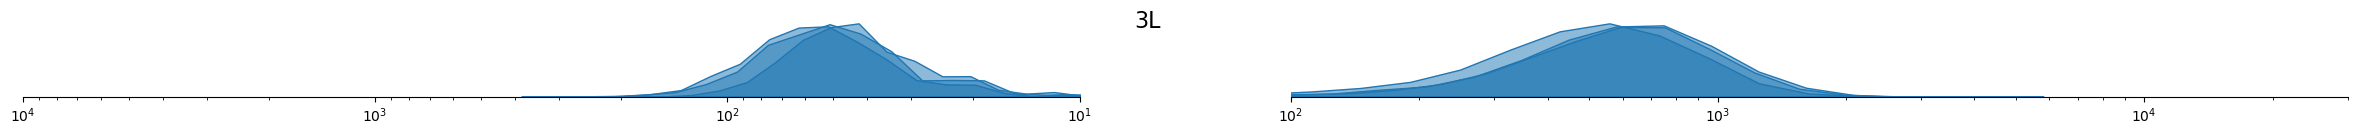

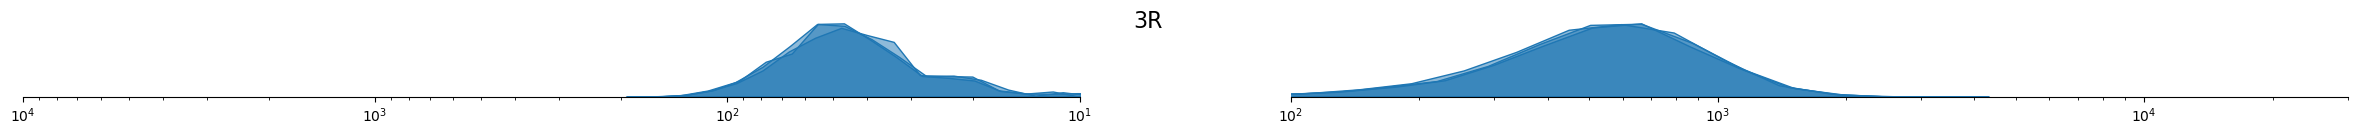

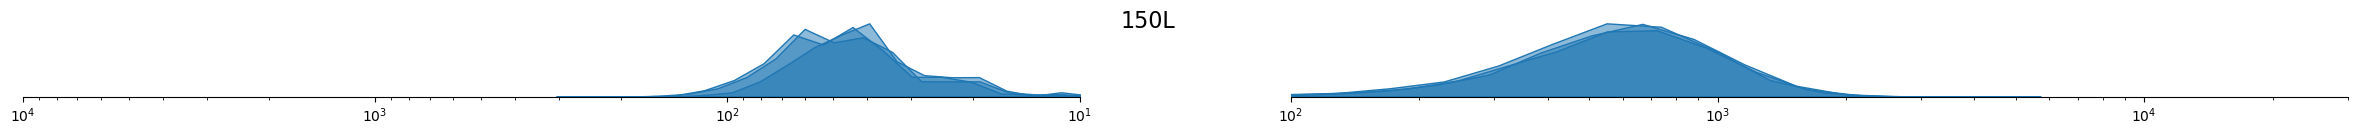

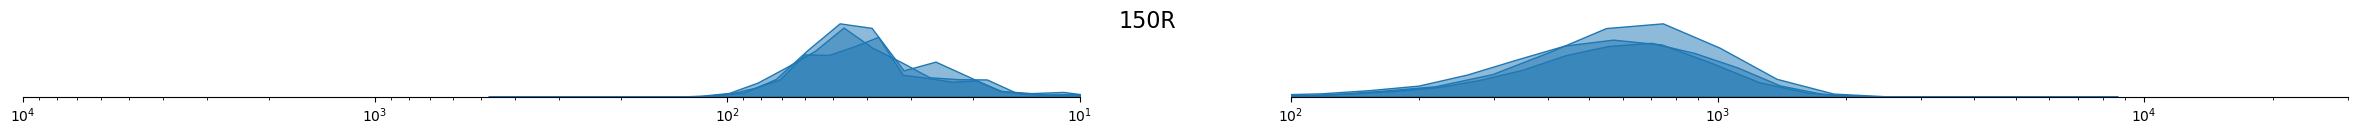

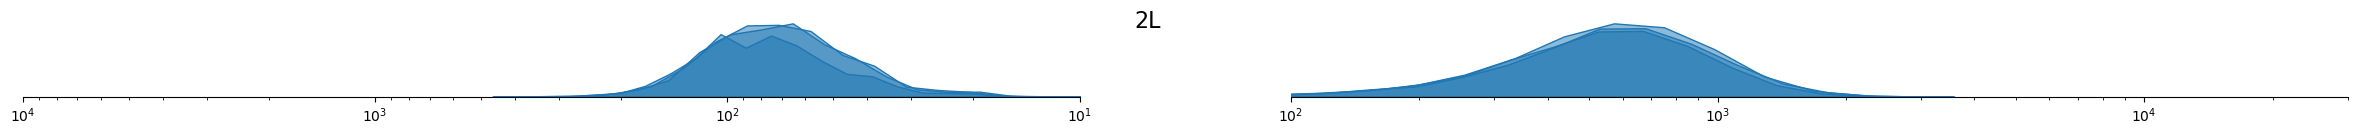

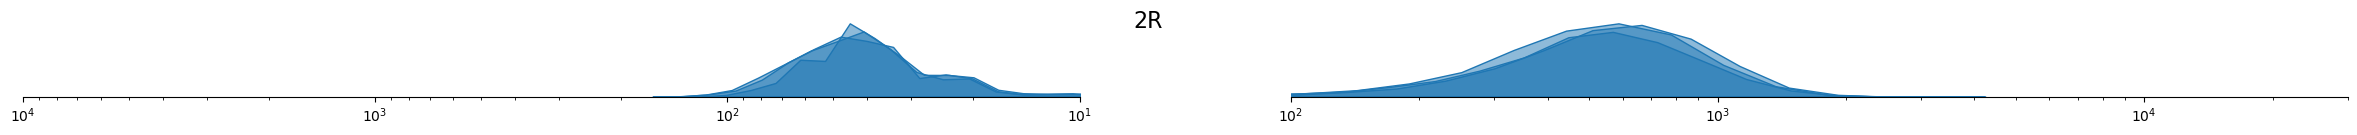

In [26]:
base_file_names = ['3L','3R','150L','150R','2L','2R']
fcsfiles = ['WT-dIS3s_3L_001_010.fcs','WT-dIS3s_3L_002_011.fcs','WT-dIS3s_3L_003_012.fcs',
            'WT-dIS3s_3R_001_013.fcs','WT-dIS3s_3R_002_014.fcs','WT-dIS3s_3R_003_015.fcs',
            'WT-dIS3s_150L_001_016.fcs','WT-dIS3s_150L_002_017.fcs','WT-dIS3s_150L_003_018.fcs',
            'WT-dIS3s_150R_001_019.fcs','WT-dIS3s_150R_002_020.fcs','WT-dIS3s_150R_003_021.fcs',
            'WT-dIS3s_2L_001_022.fcs','WT-dIS3s_2L_002_023.fcs','WT-dIS3s_2L_003_024.fcs',
            'WT-dIS3s_2R_001_025.fcs','WT-dIS3s_2R_002_026.fcs','WT-dIS3s_2R_003_027.fcs']
fcsfiles = ['fcs_files/'+n for n in fcsfiles]

# Plot the data
for base_file in base_file_names:
    
    # Create a new figure for each base_file
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(30, 1))
    fig.suptitle(base_file, fontsize=16)

    for file in fcsfiles: 
        if base_file in file:
    
            s = FlowCal.io.FCSData(file)
            
            # Get the GFP values
            GFP = s[:, ['FITC-H']]
            GFP = GFP +1 # Otherwise the log scaling doesn't work...

            # Get the mCherry values
            mScarlet = s[:, ['PE-H']]
            mScarlet = mScarlet +1 # Otherwise the log scaling doesn't work...
            
            # Plot the mScarlet       
            sns.histplot(mScarlet, bins=30, element='poly', color='greens', log_scale=True, ax=ax1, legend=False, alpha=0.5)
            ax1.set_xlim([10, 10000])
            ax1.set(ylabel=None)
            ax1.invert_xaxis()
            ax1.set(yticklabels=[])  # remove the tick labels
            ax1.tick_params(left=False)  # remove the ticks

            # Plot the GFP
            sns.histplot(GFP, bins=30, element='poly', log_scale=True, ax=ax2, legend=False, alpha=0.5)        
            ax2.set_xlim([100, 30000])
            ax2.set(ylabel=None)
            ax2.set(yticklabels=[])  # remove the tick labels
            ax2.tick_params(left=False)  # remove the ticks
            
            # Remove the boxes
            sns.despine(bottom = False, left = True)       

## S3-c - see Figure S2 for plots

## S3d daughter counts

{'dIS3_IS3_L': 3013, 'DIS3_IS150_R': 6335, 'DIS3_IS2_R': 4110, 'DIS3_IS150_L': 3154, 'dIS3_IS3_R': 1925}


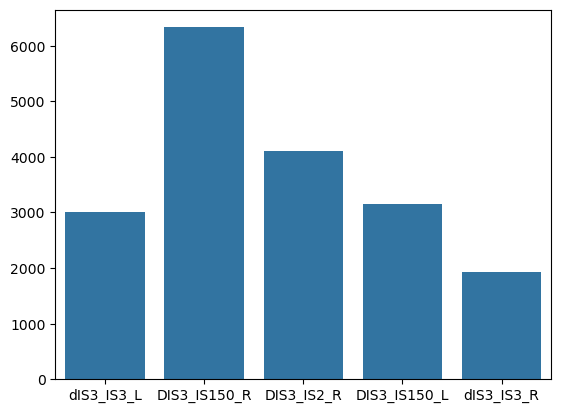

In [81]:
parents = list(set(df['parent_seq'].to_list()))
counts_dictionary = {}
for parent in parents:
    sub_df = df[df['parent_seq'] == parent]
    parent_count = len(sub_df)
    counts_dictionary[parent] = parent_count
sns.barplot(data=counts_dictionary)
#plt.savefig("daughter_counts.pdf")
print(counts_dictionary)

## S3e daughter GFP distributions

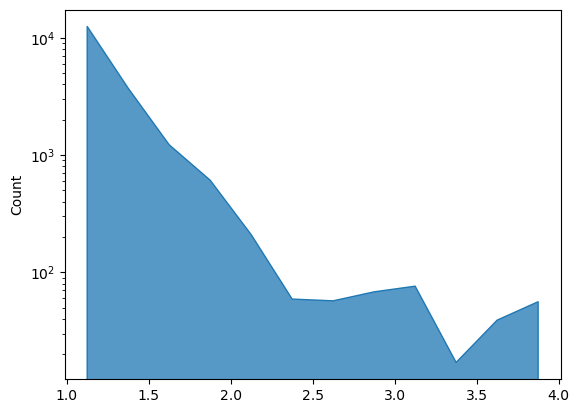

In [75]:
gfp_scores = df['GFP_mean'].to_list()
sns.histplot(x=gfp_scores, bins=12, element='poly')
plt.yscale('log')
plt.savefig("daughter_GFP_scores.pdf")

## S3f daughter RFP distributions

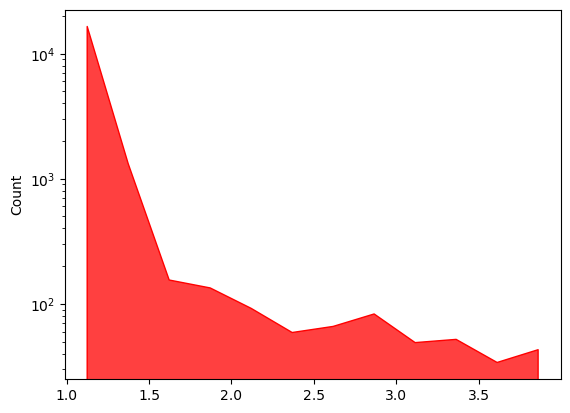

In [80]:
rfp_scores = df['mScarlet_mean'].to_list()
sns.histplot(x=rfp_scores, bins=12, element='poly', color='red')
plt.yscale('log')
plt.savefig("daughter_RFP_scores.pdf")

## S3g-h GFP/RFP replicate correlations

In [88]:
#(un)comment which one you want to look at...

#Fluor = 'GFP'
Fluor = 'RFP'

[[1.95       1.4        1.         ... 1.33333333 1.         2.36813187]
 [1.96       1.         1.         ... 1.         1.03846154 2.4138322 ]
 [1.75       1.         1.         ... 1.         1.         2.50469043]
 [1.88666667 1.13333333 1.         ... 1.11111111 1.01282051 2.42888483]]


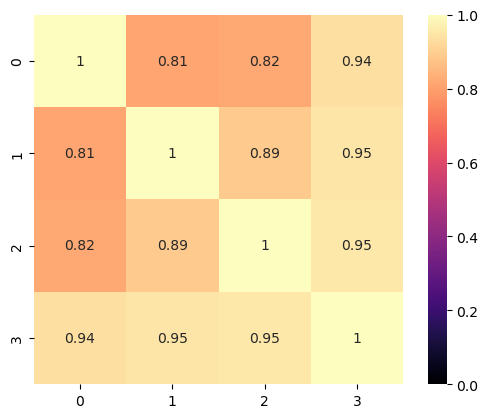

In [89]:
# Convert to lists
alpha_GFP = df['alpha_GFP'].to_list()
beta_GFP = df['beta_GFP'].to_list()
gamma_GFP = df['gamma_GFP'].to_list()
mean_GFP = df['GFP_mean'].to_list()

alpha_mScarlet = df['alpha_mScarlet'].to_list()
beta_mScarlet = df['beta_mScarlet'].to_list()
gamma_mScarlet = df['gamma_mScarlet'].to_list()
mean_mScarlet = df['mScarlet_mean'].to_list()


# Create a 2D array from the variables
if Fluor == 'GFP':
    data = np.array([alpha_GFP, beta_GFP, gamma_GFP, mean_GFP])
elif Fluor == 'RFP':
    data = np.array([alpha_mScarlet, beta_mScarlet, gamma_mScarlet, mean_mScarlet])

print(data)

# Calculate correlation coefficient matrix
corr_matrix = np.corrcoef(data)

# Normalize parameters
vmin = float(0.0)
vmax = float(1.0)
vcenter = float(.5)

# Normalize and colors
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.RdBu_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)

# Plot the data
sns_plot = sns.heatmap(corr_matrix, annot=True, cmap="magma", square=True, norm=normalize, cbar=True)
plt.savefig("RFP_correlation_matrix.pdf")

# Figure S4

In [90]:
### KWARGS: Specify GFP or mScarlet (this is RFP)...

#Fluor = 'GFP' # GFP
Fluor = 'mScarlet' # RFP

There are 300 single mutant sequences in the dataset.


C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


There are 303 single mutant sequences in the dataset.


C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


There are 323 single mutant sequences in the dataset.


C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


There are 278 single mutant sequences in the dataset.


C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


There are 0 single mutant sequences in the dataset.


C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\tfuqua\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\tfuqua\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


There are 345 single mutant sequences in the dataset.


C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


done.


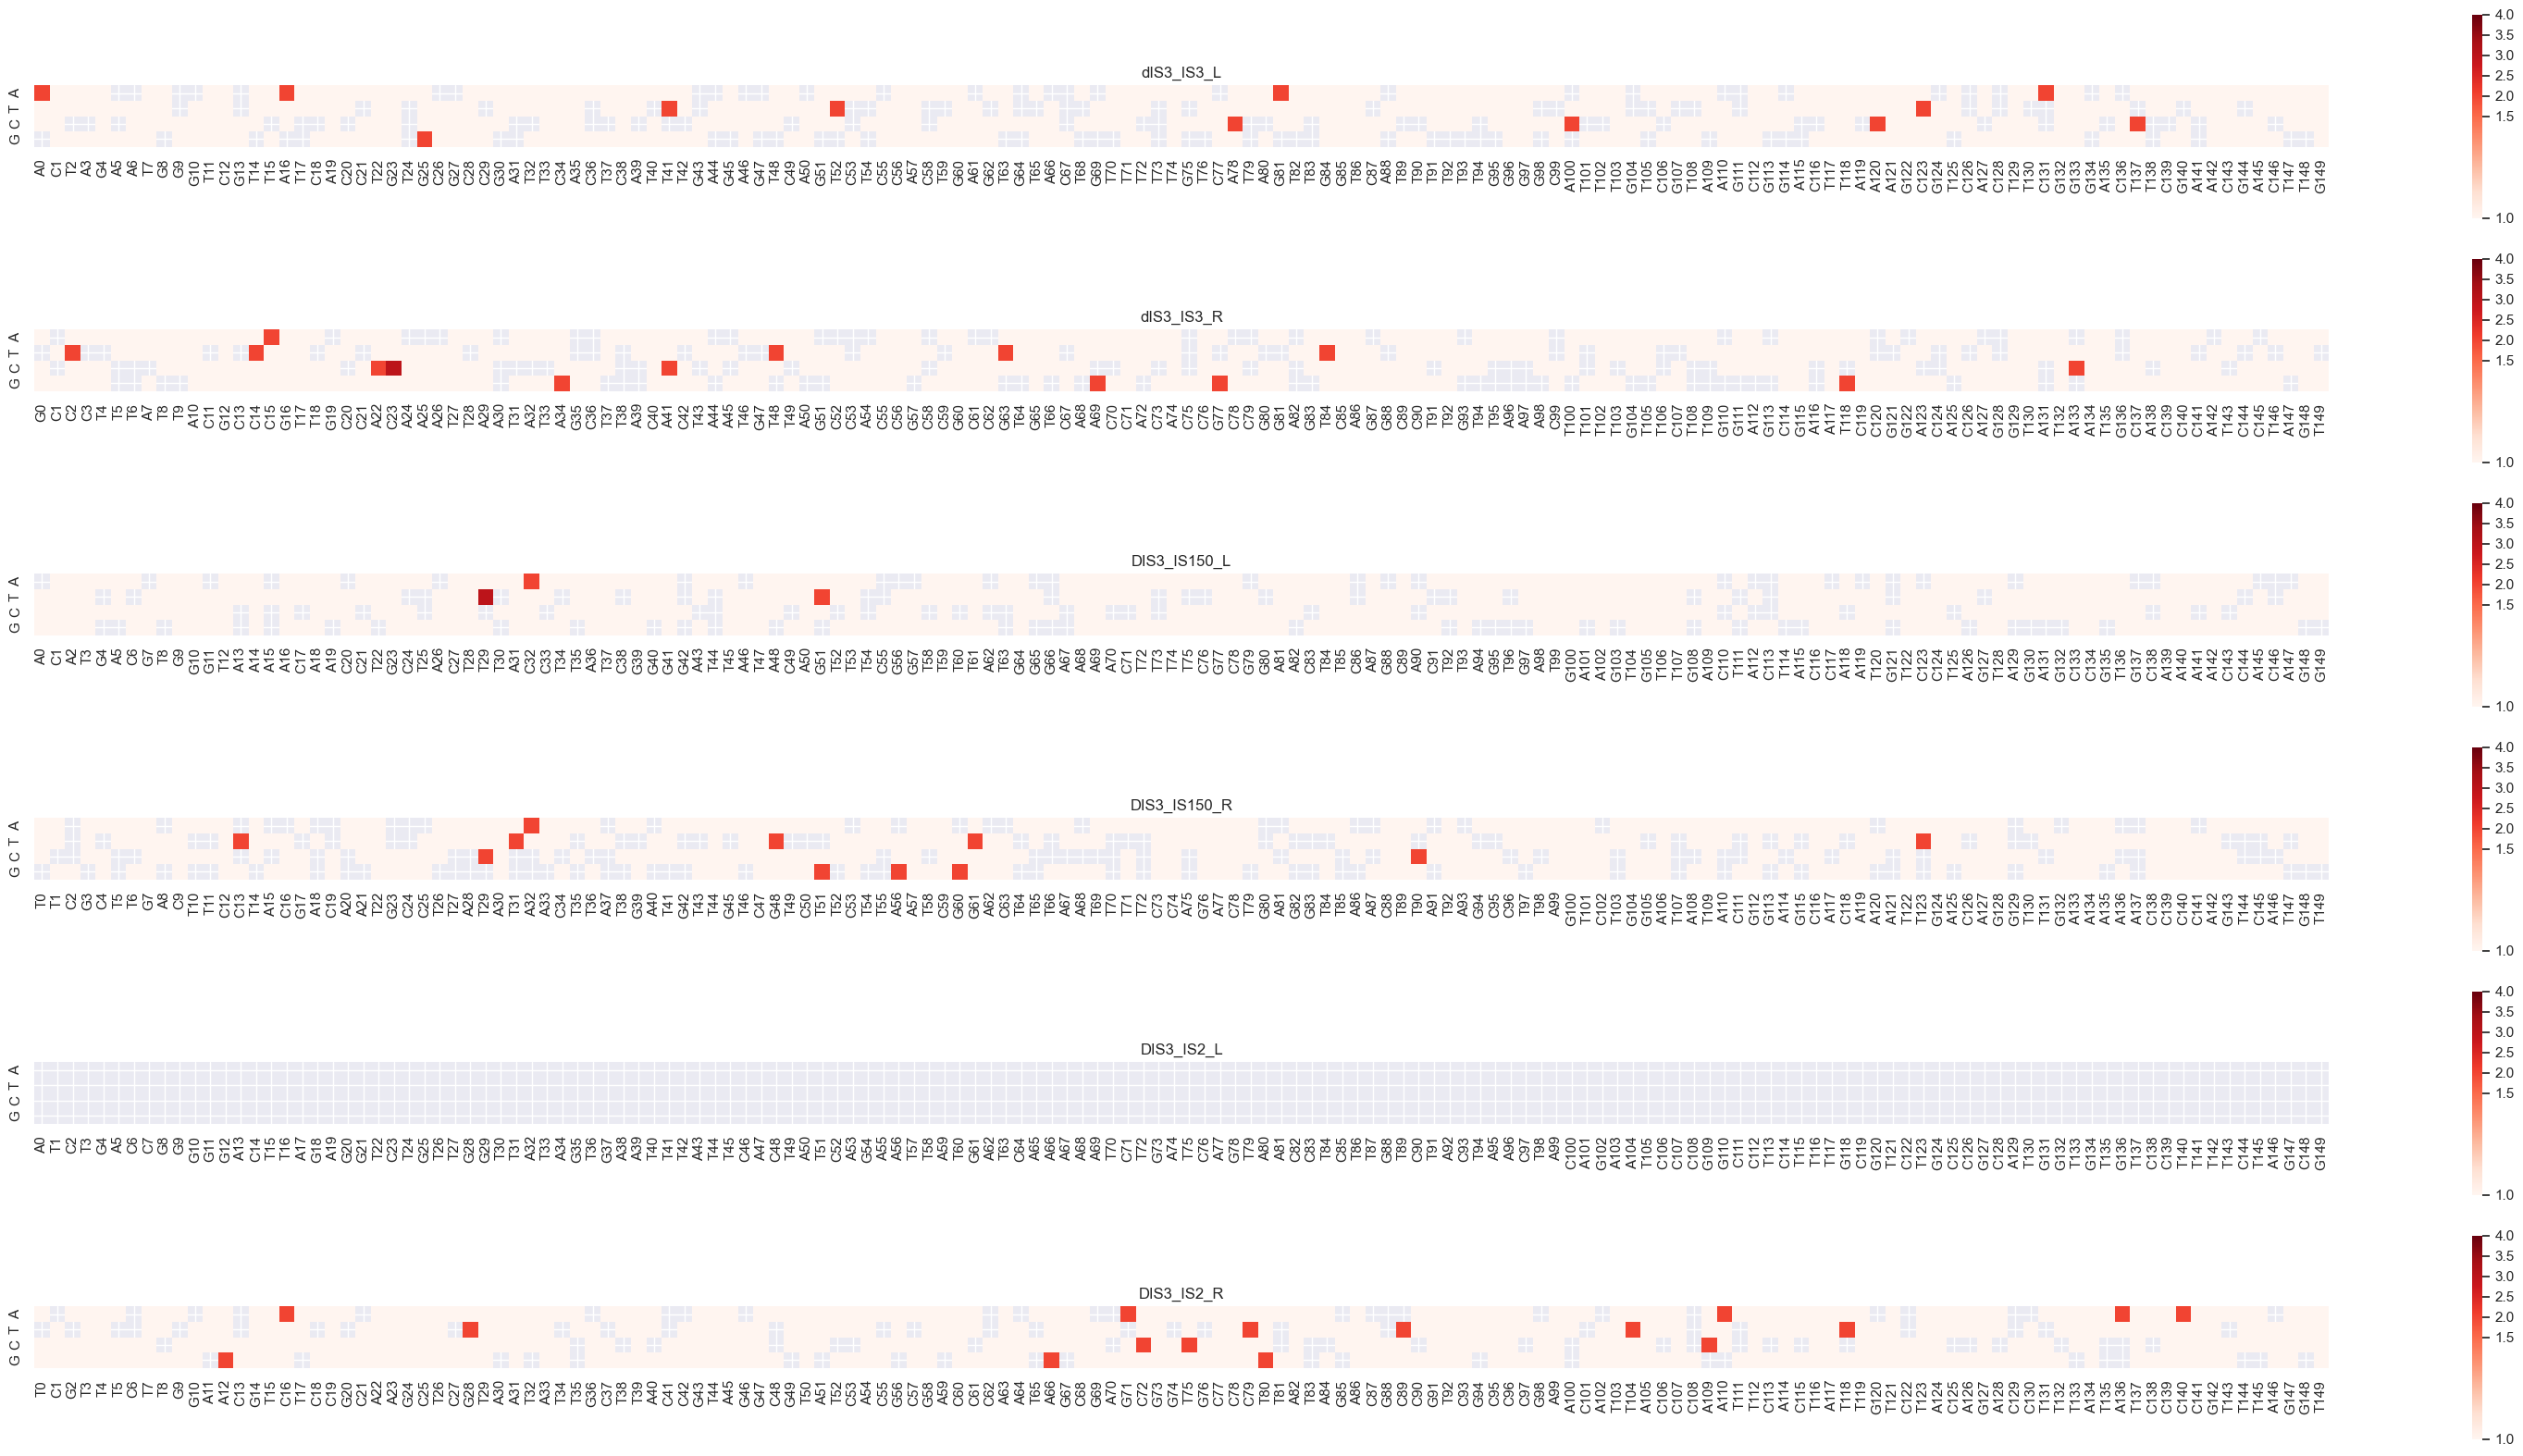

In [94]:
from scipy.spatial import distance
import numpy as np
from Bio import Seq
import seaborn as sns
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as mcolors

matplotlib.rcParams['pdf.fonttype'] = 42

fig, axes = plt.subplots(6)

# Normalize parameters
vmin = float(1.0)
vmax = float(4.0)
vcenter = float(1.5)

# Normalize and colors
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.RdBu_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)

heatmap_dict = {}

count = 0
# Loop through all WT sequences
for record in SeqIO.parse('k12_dIS3s.fasta', 'fasta'):
    filename = record.id
    WT_seq = record.seq

    # Drop all sequences not in the parent seq
    sub_df = df.drop(df[(df.parent_seq != filename)].index)

    ### 2) Create a list of sequences with a HD of 1 compared to the WT_seq:
    hd1_seqs = []
    hd1_scores = []
    for i, row in sub_df.iterrows():
        sequence = row['sequence']
        sequence = list(sequence)

        if len(sequence) == len(WT_seq):
            HD = round(distance.hamming(WT_seq, sequence) * len(WT_seq))

            if HD == 1:
                sequence = ''.join(sequence)
                hd1_seqs.append(sequence)

                if Fluor == 'GFP':
                    hd1_scores.append(row['GFP_mean'])
                    #hd1_scores.append(np.round(row['GFP_mean']))
                elif Fluor == 'mScarlet':
                    hd1_scores.append(row['mScarlet_mean'])
                    #hd1_scores.append(np.round(row['mScarlet_mean']))


    print("There are " + str(len(hd1_scores)) + " single mutant sequences in the dataset.")

    ### 3) Create a mutation heatmap for the hd1_seqs:
    j_bases = ['A','T','C','G']
    d = {}
    hotspots = list(range(len(WT_seq)))

    for i in hotspots:
        #print(i)

        row_scores = []
        for j in j_bases:
            #print(j)

            base_scores = []
            for n in range(len(hd1_seqs)):    
                if len(hd1_seqs[n]) == len(WT_seq): # <--Redundant because all sequences already 150 bp in length
                    Sequence = hd1_seqs[n]

                    if Sequence[i] == j:
                        base_scores.append(hd1_scores[n])

            row_score = np.round(np.mean(base_scores))
            row_scores.append(row_score)

        if Fluor == 'GFP':
            Label = WT_seq[i] + str(i)

        # Take the reverse complement if mScarlet
        elif Fluor == 'mScarlet':
            if WT_seq[i] == 'A':
                Label = 'T' + str(i)
            elif WT_seq[i] == 'T':
                Label = 'A' + str(i)
            elif WT_seq[i] == 'G':
                Label = 'C' + str(i)
            elif WT_seq[i] == 'C':
                Label = 'G' + str(i)

        d[Label] = row_scores


    ### 4) Plot the data
    heatmap_df = pd.DataFrame(d) # this is a dictionary converted to a dataframe...   
    heatmap_df = heatmap_df.T #transpose
    heatmap_df.columns = j_bases
    heatmap_df = heatmap_df.T
    sns.set(rc={'figure.figsize':(40,20)}) # This sets the size of the figure

    # Plot the data
    if Fluor == 'GFP':
        sns_plot = sns.heatmap(heatmap_df, annot=False, cmap="Blues", norm=normalize, square=True, cbar=True, ax=axes[count]).set_title(filename)
        #sns_plot.figure.savefig(filename + "_single_mut_heatmap_GFP.pdf")

    elif Fluor == 'mScarlet':
        sns_plot = sns.heatmap(heatmap_df, annot=False, cmap="Reds", norm=normalize, square=True, cbar=True, ax=axes[count]).set_title(filename)
        #sns_plot.figure.savefig(filename + "_single_mut_heatmap_mScarlet.pdf")
    
    # Add to the df dictionary
    heatmap_dict[filename] = heatmap_df
    
    count += 1
    
print("done.")

#sns_plot.figure.savefig("single_mut_heatmap_mScarlet.pdf")

# Figure S5

## S5a

In [100]:
from collections import Counter

observed_values = []
expected_values = []
epistasis_types = []

fluors = ['GFP_mean', 'mScarlet_mean']
for record in SeqIO.parse("k12_dIs3s.fasta", 'fasta'):
    parent = str(record.id)
    parent_sequence = str(record.seq)

    for Fluor in fluors:
        #print(Fluor)
    
        # Isolate 150 bp seqeunces with single point mutations (df1 = 1 mutation)
        df1 = df[(df['Levenshtein_dist'] == 1)]
        df1 = df1[df1['sequence'].str.len() == 150]
        df1 = df1[(df1['parent_seq'] == parent)]
        
        # Create a single mutation dictionary:
        single_mut_dictionary = {}
        for i, row in df1.iterrows():
            daughter = row['sequence']
        
            for n, bp in enumerate(daughter):
                if bp == parent_sequence[n]:
                    pass
                else:
                    #print(f'position: {n}, parent: {parent_sequence[n]}, daughter: {bp}')
                    key = (n, parent_sequence[n], bp)
                    single_mut_dictionary[key] = row[Fluor]
        
        # Turn the keys into a list
        single_mut_keys = list(single_mut_dictionary.keys())
        
        # Get the median GFP value for the parent
        sub_df = df[(df['parent_seq'] == parent)]
        sub_df = sub_df[sub_df['sequence'].str.len() == 150]
        parent_fluorescence = sub_df[Fluor].to_list()
        parent_median = np.median(parent_fluorescence)
        #print(parent_median)
        
        # Isolate 150 bp seqeunces with double point mutations (df2 = 2 mutations)
        df2 = df[(df['Levenshtein_dist'] == 3)]
        df2 = df2[df2['sequence'].str.len() == 150]
        df2 = df2[(df2['parent_seq'] == parent)]
        
        for i, row in df2.iterrows():
            daughter = row['sequence']
        
            # Find the unique mutations in each daughter
            daughter_keys = []
            for n, bp in enumerate(daughter):
                if bp == parent_sequence[n]:
                    pass
                else:
                    #print(f'position: {n}, parent: {parent_sequence[n]}, daughter: {bp}')
                    key = (n, parent_sequence[n], bp)
                    daughter_keys.append(key)
                    #print(key)
        
            # Are these keys in the single_mut_keys list?
            if all(item in single_mut_keys for item in daughter_keys):
        
                #print(daughter_keys)
        
                # Check for epistasis:
                mutation1 = single_mut_dictionary[daughter_keys[0]] - parent_median
                mutation2 = single_mut_dictionary[daughter_keys[1]] - parent_median
                mutation3 = single_mut_dictionary[daughter_keys[2]] - parent_median
                
                double_mutation = row[Fluor] - parent_median

                # observed and expected values
                observed_value = double_mutation
                observed_values.append(observed_value)
                
                expected_value = mutation1 + mutation2 + mutation3
                expected_values.append(expected_value)

C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Triple mutants')

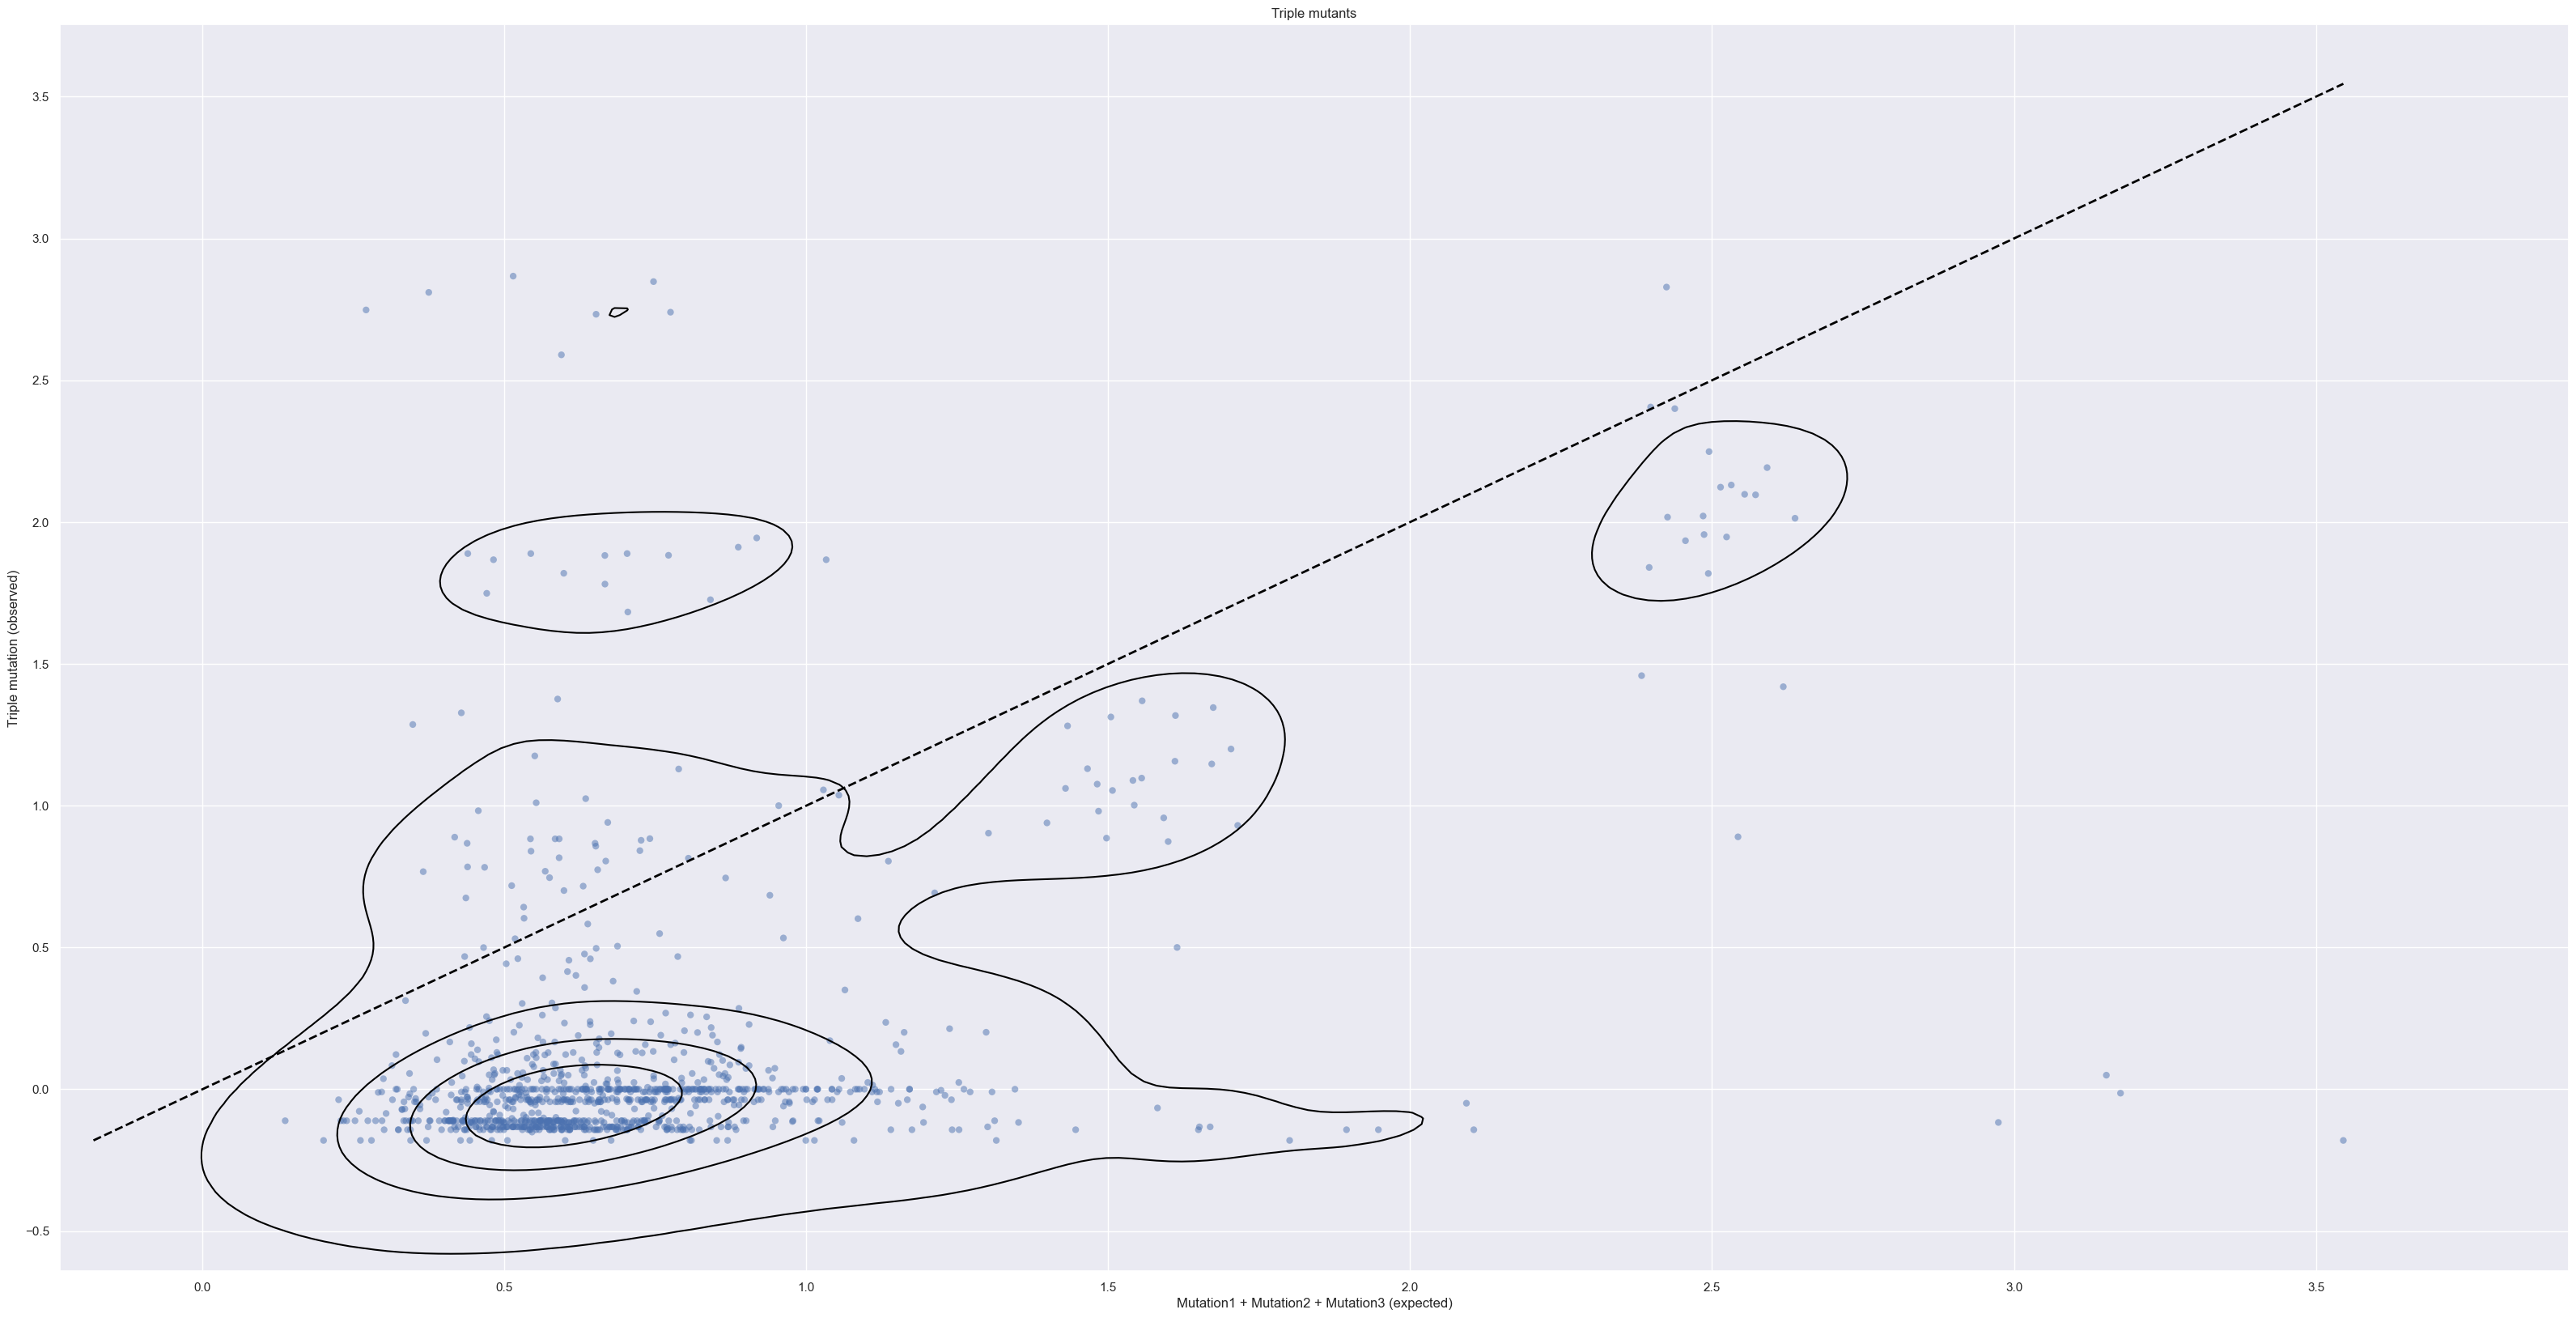

In [101]:
sns.scatterplot(x=expected_values, y=observed_values, edgecolor='none', alpha=0.5)
sns.kdeplot(x=expected_values, y=observed_values, levels=5, fill=False, color='black')

# Add the diagonal line (y = x)
min_val = min(min(expected_values), min(observed_values))
max_val = max(max(expected_values), max(observed_values))
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=2)

plt.ylabel('Triple mutation (observed)')
plt.xlabel('Mutation1 + Mutation2 + Mutation3 (expected)')
plt.title("Triple mutants")

In [102]:
print(np.median(expected_values))
print(np.median(observed_values))

0.6378603945470486
-0.03703703703703698


## S5b

In [103]:
from collections import Counter

observed_values = []
expected_values = []

fluors = ['GFP_mean', 'mScarlet_mean']
for record in SeqIO.parse("k12_dIs3s.fasta", 'fasta'):
    parent = str(record.id)
    parent_sequence = str(record.seq)

    for Fluor in fluors:
        #print(Fluor)
    
        # Isolate 150 bp seqeunces with single point mutations (df1 = 1 mutation)
        df1 = df[(df['Levenshtein_dist'] == 1)]
        df1 = df1[df1['sequence'].str.len() == 150]
        df1 = df1[(df1['parent_seq'] == parent)]
        
        # Create a single mutation dictionary:
        single_mut_dictionary = {}
        for i, row in df1.iterrows():
            daughter = row['sequence']
        
            for n, bp in enumerate(daughter):
                if bp == parent_sequence[n]:
                    pass
                else:
                    #print(f'position: {n}, parent: {parent_sequence[n]}, daughter: {bp}')
                    key = (n, parent_sequence[n], bp)
                    single_mut_dictionary[key] = row[Fluor]
        
        # Turn the keys into a list
        single_mut_keys = list(single_mut_dictionary.keys())
        
        # Get the median GFP value for the parent
        sub_df = df[(df['parent_seq'] == parent)]
        sub_df = sub_df[sub_df['sequence'].str.len() == 150]
        parent_fluorescence = sub_df[Fluor].to_list()
        parent_median = np.median(parent_fluorescence)
        #print(parent_median)
        
        # Isolate 150 bp seqeunces with double point mutations (df2 = 2 mutations)
        df2 = df[(df['Levenshtein_dist'] == 4)]
        df2 = df2[df2['sequence'].str.len() == 150]
        df2 = df2[(df2['parent_seq'] == parent)]
        
        for i, row in df2.iterrows():
            daughter = row['sequence']
        
            # Find the unique mutations in each daughter
            daughter_keys = []
            for n, bp in enumerate(daughter):
                if bp == parent_sequence[n]:
                    pass
                else:
                    #print(f'position: {n}, parent: {parent_sequence[n]}, daughter: {bp}')
                    key = (n, parent_sequence[n], bp)
                    daughter_keys.append(key)
                    #print(key)
        
            # Are these keys in the single_mut_keys list?
            if all(item in single_mut_keys for item in daughter_keys):
        
                #print(daughter_keys)
        
                # Check for epistasis:
                mutation1 = single_mut_dictionary[daughter_keys[0]] - parent_median
                mutation2 = single_mut_dictionary[daughter_keys[1]] - parent_median
                mutation3 = single_mut_dictionary[daughter_keys[2]] - parent_median
                mutation4 = single_mut_dictionary[daughter_keys[3]] - parent_median
                
                double_mutation = row[Fluor] - parent_median
    
                # observed and expected values
                observed_value = double_mutation
                observed_values.append(observed_value)
                
                expected_value = mutation1 + mutation2 + mutation3 + mutation4
                expected_values.append(expected_value)

C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Quadruple mutations')

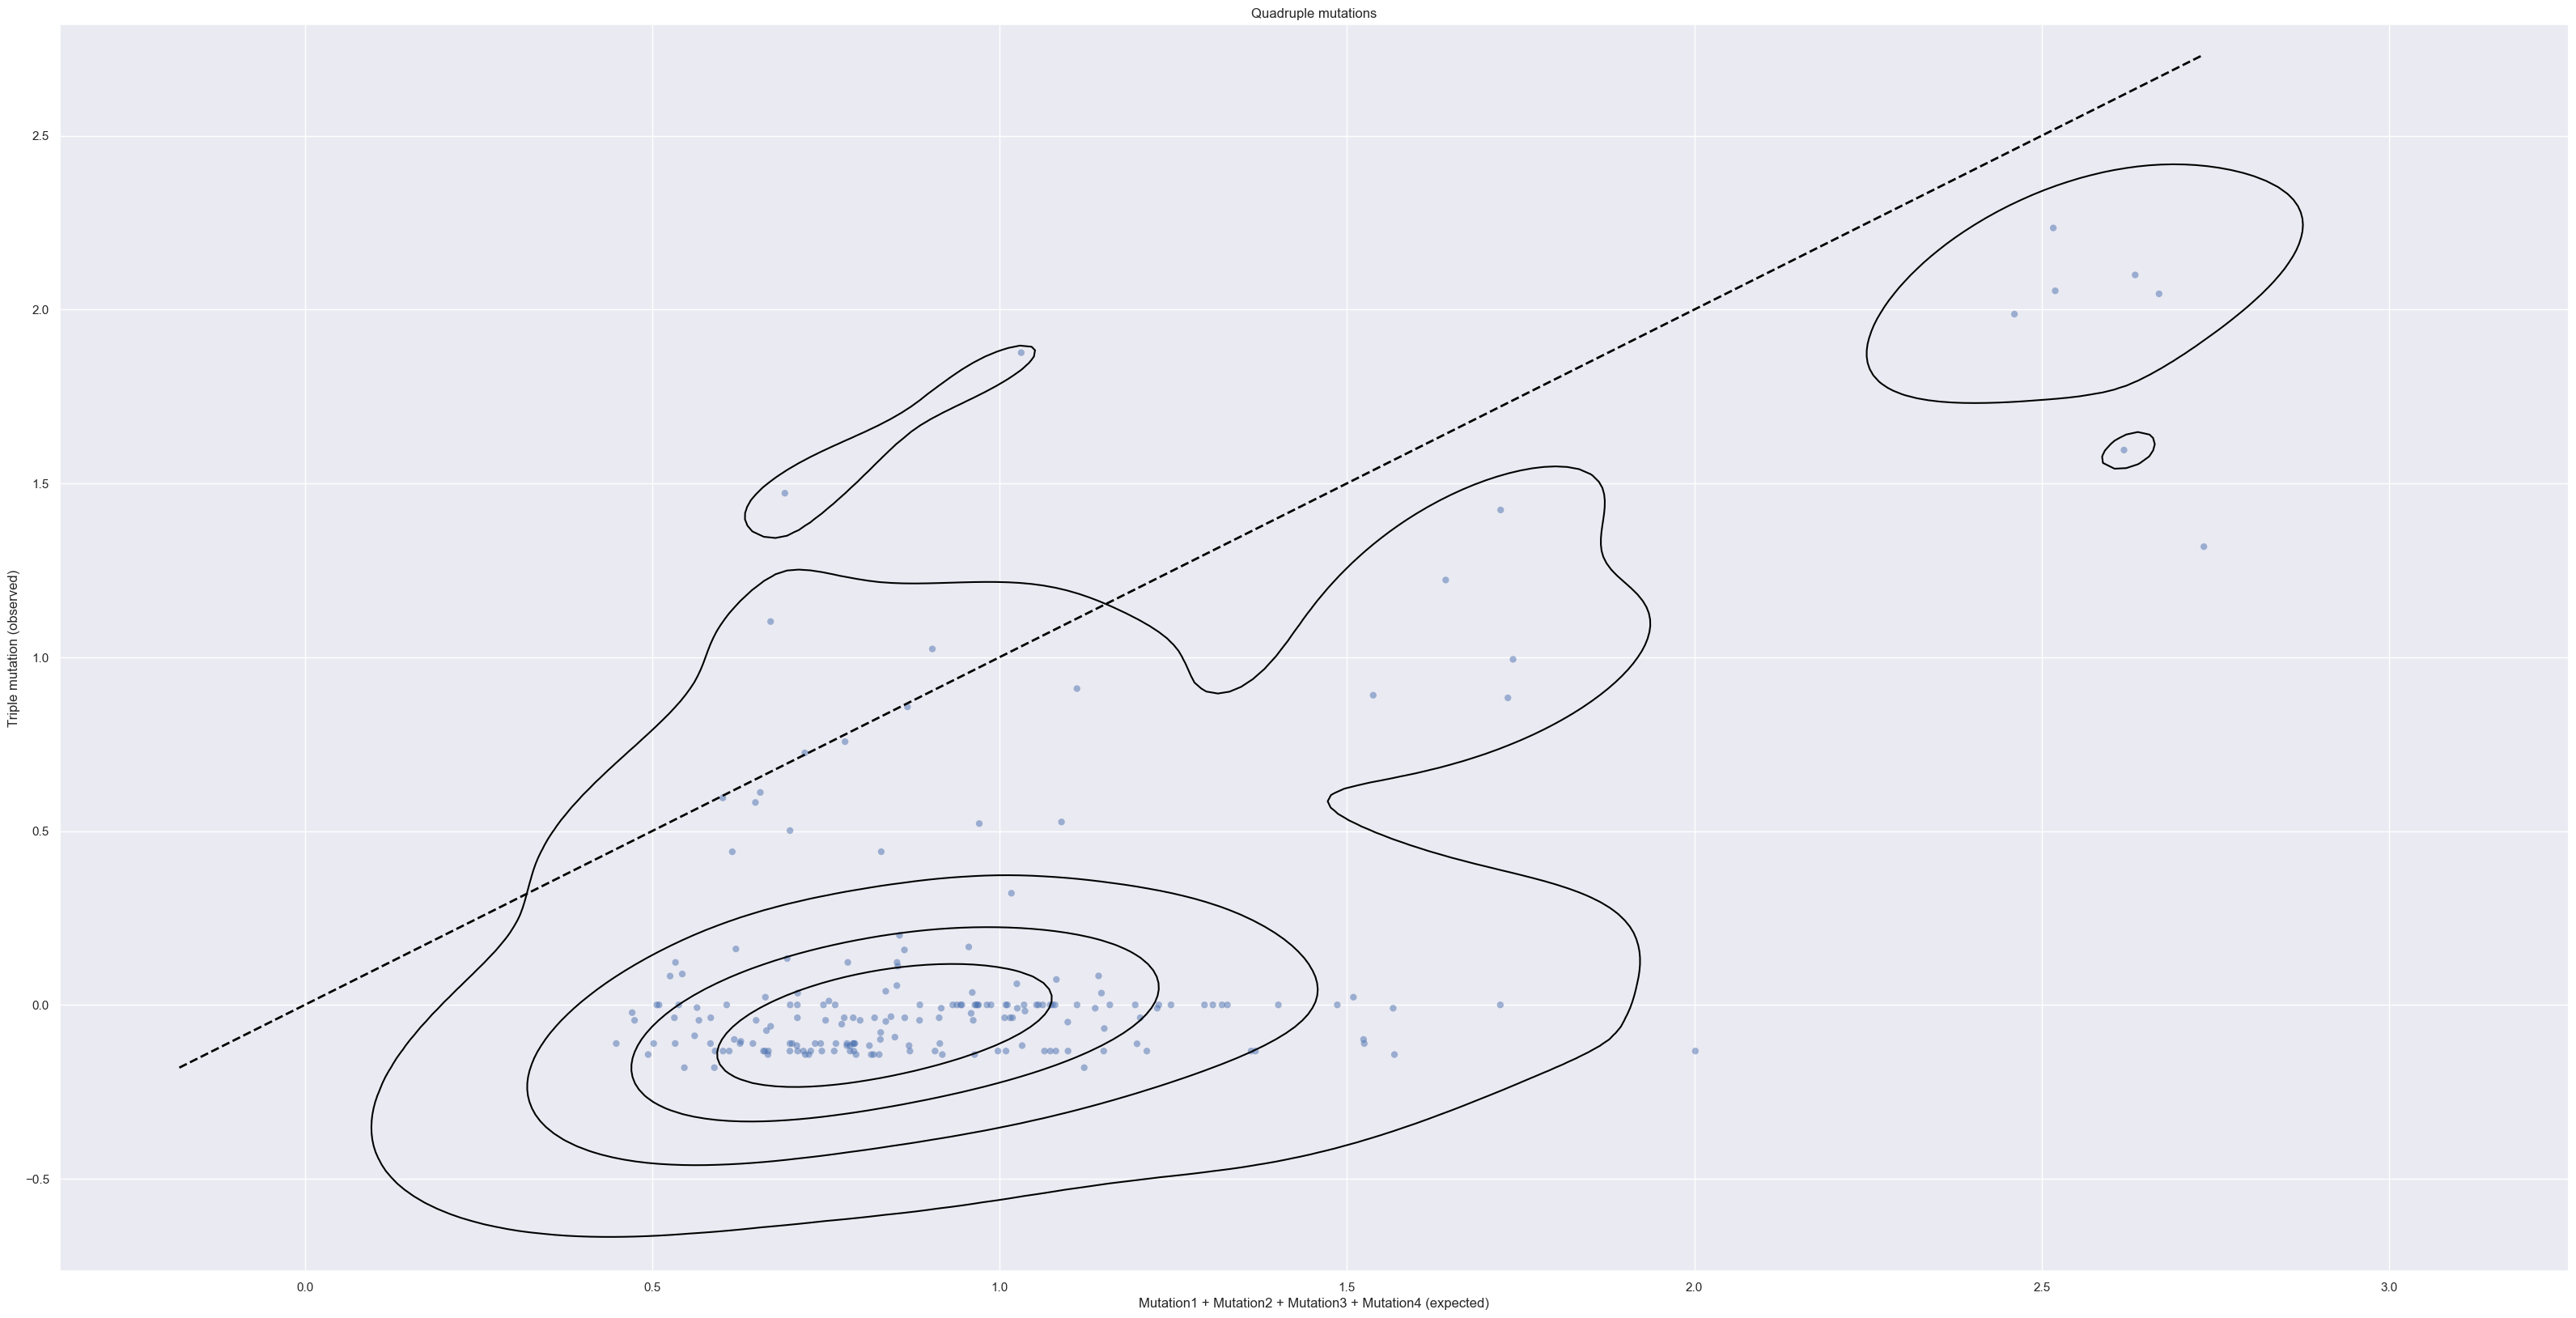

In [106]:
sns.scatterplot(x=expected_values, y=observed_values, edgecolor='none', alpha=0.5)
sns.kdeplot(x=expected_values, y=observed_values, levels=5, fill=False, color='black')

# Add the diagonal line (y = x)
min_val = min(min(expected_values), min(observed_values))
max_val = max(max(expected_values), max(observed_values))
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=2)

plt.ylabel('Triple mutation (observed)')
plt.xlabel('Mutation1 + Mutation2 + Mutation3 + Mutation4 (expected)')
plt.title("Quadruple mutations")

## S5c

In [107]:
epistasis_types = []
fluors = ['GFP_mean', 'mScarlet_mean']
for record in SeqIO.parse("k12_dIs3s.fasta", 'fasta'):
    parent = str(record.id)
    parent_sequence = str(record.seq)

    for Fluor in fluors:
        #print(Fluor)
    
        # Isolate 150 bp seqeunces with single point mutations (df1 = 1 mutation)
        df1 = df[(df['Levenshtein_dist'] == 1)]
        df1 = df1[df1['sequence'].str.len() == 150]
        df1 = df1[(df1['parent_seq'] == parent)]
        
        # Create a single mutation dictionary:
        single_mut_dictionary = {}
        for i, row in df1.iterrows():
            daughter = row['sequence']
        
            for n, bp in enumerate(daughter):
                if bp == parent_sequence[n]:
                    pass
                else:
                    #print(f'position: {n}, parent: {parent_sequence[n]}, daughter: {bp}')
                    key = (n, parent_sequence[n], bp)
                    single_mut_dictionary[key] = row[Fluor]
        
        # Turn the keys into a list
        single_mut_keys = list(single_mut_dictionary.keys())
        
        # Get the median GFP value for the parent
        sub_df = df[(df['parent_seq'] == parent)]
        sub_df = sub_df[sub_df['sequence'].str.len() == 150]
        parent_fluorescence = sub_df[Fluor].to_list()
        parent_median = np.median(parent_fluorescence)
        #print(parent_median)
        
        # Isolate 150 bp seqeunces with double point mutations (df2 = 2 mutations)
        df2 = df[(df['Levenshtein_dist'] == 2)]
        df2 = df2[df2['sequence'].str.len() == 150]
        df2 = df2[(df2['parent_seq'] == parent)]
        
        for i, row in df2.iterrows():
            daughter = row['sequence']
        
            # Find the unique mutations in each daughter
            daughter_keys = []
            for n, bp in enumerate(daughter):
                if bp == parent_sequence[n]:
                    pass
                else:
                    #print(f'position: {n}, parent: {parent_sequence[n]}, daughter: {bp}')
                    key = (n, parent_sequence[n], bp)
                    daughter_keys.append(key)
                    #print(key)
        
            # Are these keys in the single_mut_keys list?
            if all(item in single_mut_keys for item in daughter_keys):
        
                #print(daughter_keys)
        
                # Check for epistasis:
                mutation1 = single_mut_dictionary[daughter_keys[0]] - parent_median
                mutation2 = single_mut_dictionary[daughter_keys[1]] - parent_median
                double_mutation = row[Fluor] - parent_median
                
                # Round to the nearest 0.25 value
                mutation1 = np.round(mutation1*4)/4
                mutation2 = np.round(mutation2*4)/4
                double_mutation = np.round(double_mutation*4)/4
    
                ### Classify into epistasis types:
                ### Decision 1: A + B == AB
                if mutation1 + mutation2 == double_mutation:
                    if mutation1 == 0 and mutation2 == 0 and double_mutation == 0:
                        epistasis_type = 'no change'
                    else:
                        epistasis_type = 'additive'
                else:
                    if (mutation1 + mutation2) < double_mutation:
                        epistasis_type = 'synergystic'
                    else:
                        epistasis_type = 'antagonistic'
                    
                epistasis_types.append(epistasis_type)

C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tfuqua\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Counter({'antagonistic': 12367, 'additive': 713, 'synergystic': 525, 'no change': 251})


([<matplotlib.patches.Wedge at 0x2203e580470>,
 [Text(0.5608831814762724, -0.946261093323114, 'antagonistic'),
  Text(-0.34235830530081907, 1.045366342863377, 'synergystic'),
  Text(-0.618549338654816, 0.9096134979482714, 'additive'),
  Text(-0.8010675706178815, 0.7538506133872717, 'no change')],
 [Text(0.30593628080523944, -0.5161424145398803, '89.3%'),
  Text(-0.18674089380044673, 0.5701998233800237, '3.8%'),
  Text(-0.33739054835717236, 0.49615281706269343, '5.1%'),
  Text(-0.43694594760975347, 0.41119124366578447, '1.8%')])

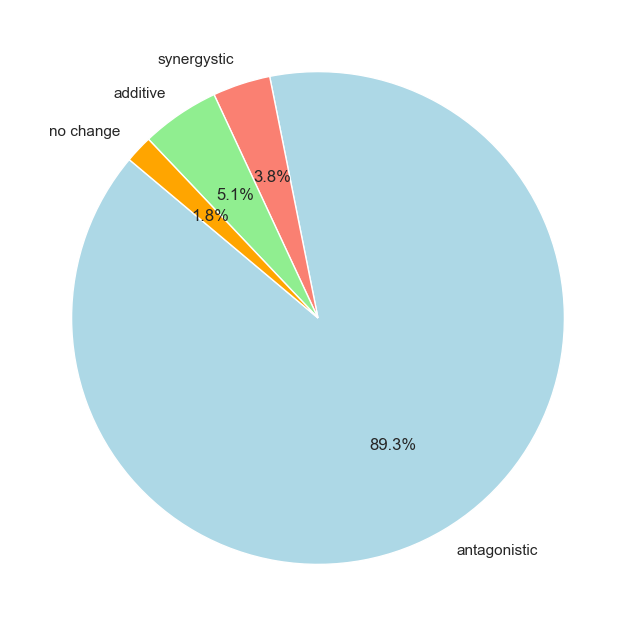

In [108]:
total_types = Counter(epistasis_types)
print(total_types)

# Extract labels and values
labels = list(total_types.keys())
sizes = list(total_types.values())

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'salmon', 'lightgreen', 'orange'])
#plt.savefig("pie_chart_antagonistic_synergistic_0.5.pdf")

## S5d

In [79]:
no_change_distances = []
additive_distances = []
synergistic_distances = []
antagonistic_distances = []

epistasis_types = []
fluors = ['GFP_mean', 'mScarlet_mean']
for record in SeqIO.parse("k12_dIs3s.fasta", 'fasta'):
    parent = str(record.id)
    parent_sequence = str(record.seq)

    for Fluor in fluors:
    
        # Isolate 150 bp seqeunces with single point mutations (df1 = 1 mutation)
        df1 = df[(df['Levenshtein_dist'] == 1)]
        df1 = df1[df1['sequence'].str.len() == 150]
        df1 = df1[(df1['parent_seq'] == parent)]
        
        # Create a single mutation dictionary:
        single_mut_dictionary = {}
        for i, row in df1.iterrows():
            daughter = row['sequence']
        
            for n, bp in enumerate(daughter):
                if bp == parent_sequence[n]:
                    pass
                else:
                    #print(f'position: {n}, parent: {parent_sequence[n]}, daughter: {bp}')
                    key = (n, parent_sequence[n], bp)
                    single_mut_dictionary[key] = row[Fluor]
        
        # Turn the keys into a list
        single_mut_keys = list(single_mut_dictionary.keys())
        
        # Get the median GFP value for the parent
        sub_df = df[(df['parent_seq'] == parent)]
        sub_df = sub_df[sub_df['sequence'].str.len() == 150]
        parent_fluorescence = sub_df[Fluor].to_list()
        parent_median = np.median(parent_fluorescence)
        
        # Isolate 150 bp seqeunces with double point mutations (df2 = 2 mutations)
        df2 = df[(df['Levenshtein_dist'] == 2)]
        df2 = df2[df2['sequence'].str.len() == 150]
        df2 = df2[(df2['parent_seq'] == parent)]
        
        for i, row in df2.iterrows():
            daughter = row['sequence']
        
            # Find the unique mutations in each daughter
            daughter_keys = []
            for n, bp in enumerate(daughter):
                if bp == parent_sequence[n]:
                    pass
                else:
                    #print(f'position: {n}, parent: {parent_sequence[n]}, daughter: {bp}')
                    key = (n, parent_sequence[n], bp)
                    daughter_keys.append(key)
                    #print(key)
        
            # Are these keys in the single_mut_keys list?
            if all(item in single_mut_keys for item in daughter_keys):
        
                # Check for epistasis:
                mutation1 = single_mut_dictionary[daughter_keys[0]] - parent_median
                mutation2 = single_mut_dictionary[daughter_keys[1]] - parent_median
                double_mutation = row[Fluor] - parent_median
                
                # Round to the nearest 0.5 value
                mutation1 = np.round(mutation1*2)/2
                mutation2 = np.round(mutation2*2)/2
                double_mutation = np.round(double_mutation*2)/2
                
                # coordinates
                coordinate1 = daughter_keys[0][0]
                coordinate2 = daughter_keys[1][0]
                coordinate_distance =  coordinate2 - coordinate1
    
                ### Classify into epistasis types:
                if mutation1 + mutation2 == double_mutation:
                    if mutation1 == 0 and mutation2 == 0 and double_mutation == 0:
                        epistasis_type = 'no change'
                        no_change_distances.append(coordinate_distance)
                    else:
                        epistasis_type = 'additive'
                        additive_distances.append(coordinate_distance)
                else:
                    if (mutation1 + mutation2) < double_mutation:
                        epistasis_type = 'synergystic'
                        synergistic_distances.append(coordinate_distance)
                    else:
                        epistasis_type = 'antagonistic'
                        antagonistic_distances.append(coordinate_distance)
                    
                epistasis_types.append(epistasis_type)

6513
536
966
5841
F-statistic: 0.648832015453094
P-value: 0.5835995596357824


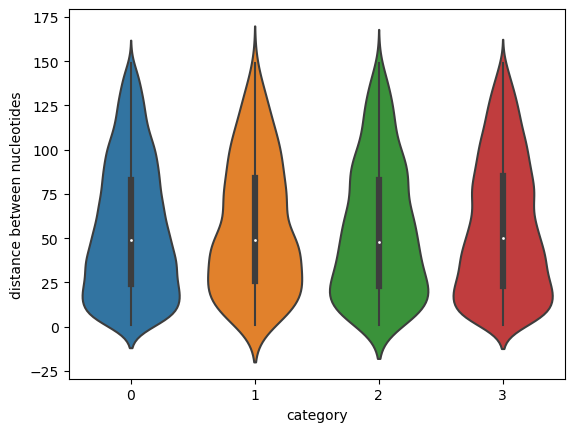

In [80]:
print(len(no_change_distances))
print(len(additive_distances))
print(len(synergistic_distances))
print(len(antagonistic_distances))

data = [no_change_distances, additive_distances, synergistic_distances, antagonistic_distances]
sns.violinplot(data=data)

plt.xlabel('category')
plt.ylabel('distance between nucleotides')

from scipy.stats import f_oneway
# Perform one-way ANOVA
f_stat, p_value = f_oneway(no_change_distances, additive_distances, synergistic_distances, antagonistic_distances)

# Print results
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

#plt.savefig("epistasis_category_and_distance.pdf")

# Figure S6 (see Figure 2d to recreate these plots)

# Figure S7

In [21]:
from scipy.stats import uniform
from scipy.spatial import distance
import matplotlib.pyplot as plt
from Bio import SeqIO
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import kstest
from scipy import stats
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib

# This dictionary will store the values
matrix_dict = {}
fluors = ['GFP', 'mScarlet']
types = ['creating', 'neutral']


for Fluor in fluors:
    for Type in types:

        # These lists are for both the wild-type sequence and the mutated sequence
        before_list = []
        after_list = []
            
        # Loop through all WT sequences
        count = 0
        for record in SeqIO.parse('k12_dIS3s.fasta', 'fasta'):
            filename = record.id
            
            if filename != 'DIS3_IS2_L':
            
                # Define the wild-type sequence:
                WT_seq = record.seq
        
                # Drop all sequences not in the parent seq
                sub_df = df.drop(df[(df.parent_seq != filename)].index)
        
                # Add all single mutant, score == 2 sequences to this list:
                candidate_seqs = []
        
                for i, row in sub_df.iterrows():
                    sequence = row['sequence']
                    sequence = list(sequence)
        
                    # Get the rounded score
                    if Fluor == 'GFP':
                        score = np.round(row['GFP_mean'])
                    elif Fluor == 'mScarlet':
                        score = np.round(row['mScarlet_mean'])
        
                    # Check the size and calculate the HD
                    if len(sequence) == len(WT_seq):
                        HD = round(distance.hamming(WT_seq, sequence) * len(WT_seq))
        
                        if HD == 1:
                            
                            if Type == 'creating':
                                if score == 2:
                                    sequence = ''.join(sequence) # turns it back into string form...
                                    candidate_seqs.append(sequence)
        
                                    
                            elif Type == 'neutral':
                                if score == 1:
                                    sequence = ''.join(sequence) # turns it back into string form...
                                    candidate_seqs.append(sequence)
                              
                # Loop through each sequence...
                for sequence in candidate_seqs:
        
                    # Compare each base with the WT sequence within that sequence...
                    for n in range(len(sequence)):
        
                        # When you find the mutation:
                        if sequence[n] != WT_seq[n]:
        
                            # Isolate +/- 5 bp from both the sequence and the wild-type
                            before = WT_seq[n-5:n+6]
                            before_list.append(str(before)) # str() because it was a Seq object before
        
                            after = sequence[n-5:n+6]
                            after = ''.join(after) # after was in list form
                            after_list.append(after)
                            
        
        # Remove all sequences where the length is 0
        before_list = [n for n in before_list if len(n) != 0]
        after_list = [n for n in after_list if len(n) != 0]
        
        for TF in list_of_TFs:
        
            # Append to the before_scores list
            before_scores = []
            for sequence in before_list:
                #print(sequence)
                
                initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
                for position, score in PSSMs_dict[TF].search(sequence):
                    
                    # Only look at positiive values
                    temp_scores = [] # sometimes you get more than one score
        
                    if Fluor == 'GFP': 
                        if position>0:
                            initial_score = score
                            temp_scores.append(initial_score)
                            
                    elif Fluor == 'mScarlet':
                        if position<0:
                            initial_score = score
                            temp_scores.append(initial_score)
                        
                    # If you have more than one score, take the greater one
                    if len(temp_scores) > 1:
                        initial_score = max(temp_scores)
                    
                before_scores.append(initial_score)
                #print(initial_score)    
                    
                    
            # Append to the after_scores list
            after_scores = []
            for sequence in after_list:
                #print(sequence)
                initial_score = 0
                for position, score in PSSMs_dict[TF].search(sequence):
                    
                    temp_scores = []
                    if position>0:
                        initial_score = score # The value has changed if something was found greater than a position of 0
                        temp_scores.append(score)
                        
                    if len(temp_scores) > 1:
                        initial_score = max(temp_scores)
                        
                after_scores.append(initial_score)
                #print(initial_score)
                    
            # Calculate the affinity changes
            difference_list = []
            for n in range(len(after_scores)):
                difference = after_scores[n] - before_scores[n]
                # print(sequence)
                # print(difference)
                difference_list.append(difference)
                
            # Append to the appropriate list
            if TF == 'minus10':
                minus10_differences = difference_list
            elif TF == 'minus35':
                minus35_differences = difference_list
        
        ### How many are in each category?
        catI = 0
        catII = 0
        catIII = 0
        catIV = 0
        catV = 0
        catVI = 0
        catVII = 0
        catVIII = 0
        catIX = 0
        
        for n in range(len(minus35_differences)):
            thirtyfive = minus35_differences[n]
            ten = minus10_differences[n]
            
            if ten > 0:
                if thirtyfive > 0:
                    catI +=1
                elif thirtyfive == 0:
                    catIV +=1
                elif thirtyfive < 0:
                    catVII +=1
                    
            elif ten == 0:
                if thirtyfive > 0:
                    catII +=1
                elif thirtyfive == 0:
                    catV += 1
                elif thirtyfive < 0:
                    catVIII +=1
            
            elif ten < 0:
                if thirtyfive > 0:
                    catIII += 1
                elif thirtyfive == 0:
                    catVI += 1
                elif thirtyfive < 0:
                    catIX +=1
        
        output_matrix = np.matrix([[catI, catII, catIII],[catIV, catV, catVI],[catVII, catVIII, catIX]])
        print(output_matrix)

        matrix_dict[(Fluor, Type)] = output_matrix

[[  1  20   4]
 [ 15 110  13]
 [  4   6   2]]
[[ 17 126  19]
 [ 83 783  97]
 [ 15 142  30]]
[[ 1  1  2]
 [ 6 20  6]
 [ 5  8  3]]
[[ 26 149  50]
 [ 80 672 103]
 [ 35 265  61]]


In [24]:
for key in matrix_dict.keys():
    print(key)

('GFP', 'creating')
('GFP', 'neutral')
('mScarlet', 'creating')
('mScarlet', 'neutral')


In [29]:
### Here are the combined values:

from scipy.stats import chi2_contingency

# observed = np.matrix([[1+1, 20+1, 4+2],[15+6, 110+20, 13+6],[4+5, 6+8, 2+3]])
# print(observed)

observed = matrix_dict[('GFP', 'creating')] + matrix_dict[('mScarlet', 'creating')]
print(observed)

expected = matrix_dict[('GFP', 'neutral')] + matrix_dict[('mScarlet', 'neutral')]
print(expected)

# expected = np.matrix([[17+26, 126+149, 19+50],[83+80, 783+672, 97+103],[15+35, 142+265, 30+61]])
# print(expected)

# Perform chi-squared test
chi2, p, dof, expected_freq = chi2_contingency(observed)

# Print the results
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected_freq)

[[  2  21   6]
 [ 21 130  19]
 [  9  14   5]]
[[  43  275   69]
 [ 163 1455  200]
 [  50  407   91]]
Chi-squared statistic: 12.436565315389478
P-value: 0.014383614645214135
Degrees of freedom: 4
Expected frequencies:
[[  4.08810573  21.07929515   3.83259912]
 [ 23.96475771 123.56828194  22.46696035]
 [  3.94713656  20.35242291   3.70044053]]


Text(0.5, 1.0, 'Weak Promoters')

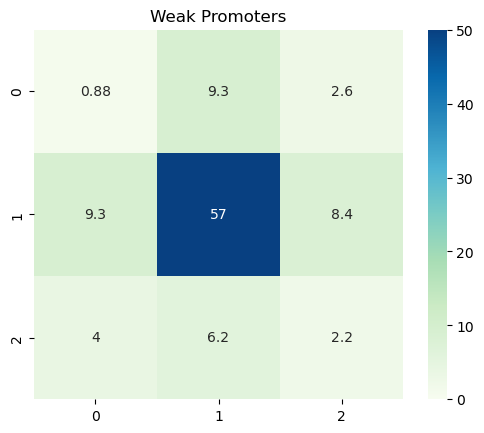

In [30]:
# Normalize parameters
vmin = float(0)
vmax = float(50)
vcenter = float(25)

# Normalize and colors
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.RdBu_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
matplotlib.rcParams['pdf.fonttype'] = 42

sns.heatmap(100*observed/np.sum(observed), annot=True, cmap="GnBu", norm=normalize, square=True, cbar=True).set_title('Weak Promoters')
#plt.savefig("weak_promoters_affinity_maps.pdf")

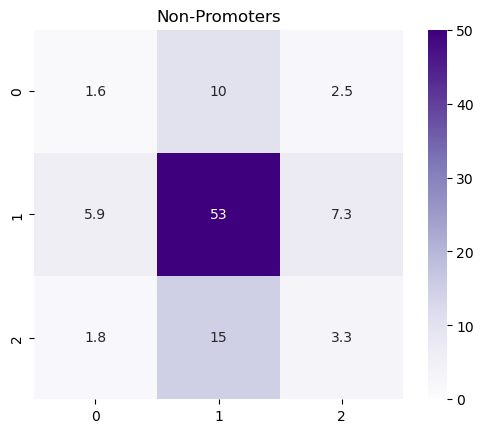

In [31]:
sns_plot = sns.heatmap(100*expected/np.sum(expected), annot=True, cmap="Purples", norm=normalize, square=True, cbar=True).set_title('Non-Promoters')
#plt.savefig("non-promoters_affinity_maps.pdf")

# Figure S8

## S8a mutual information 3R(+)

 total bits: 0.16187389867405136


(0.0, 0.016525229014943847)

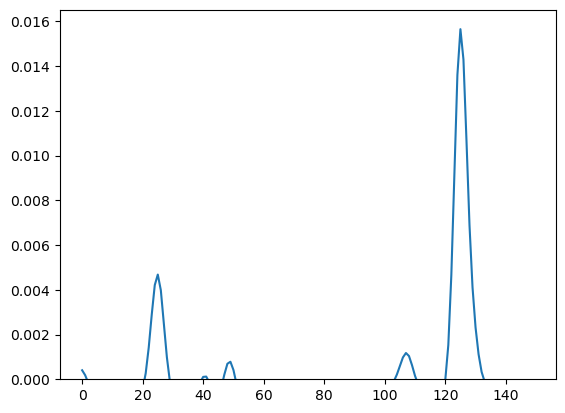

In [85]:
information = calculate_mutual_information('dIS3_IS3_R', 'GFP', 2)
sns.lineplot(information)
plt.ylim(0)

## S8b flow cytometry constructs

(100, 10000)

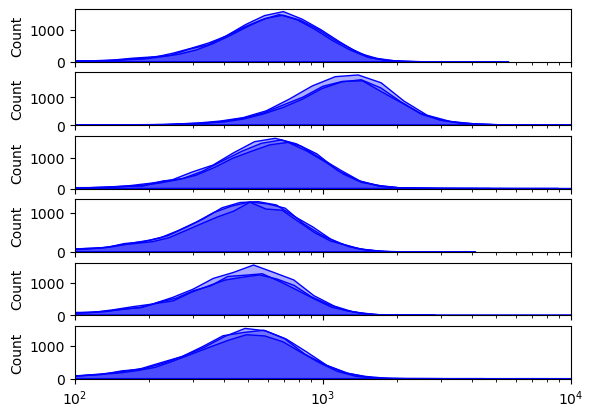

In [27]:
# Subplots
fig, axes = plt.subplots(6, sharex=True)

### Full (WT)
s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_3Rfull_001_010.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[0], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')

s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_3Rfull_002_011.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[0], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')

s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_3Rfull_003_012.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[0], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')




### Short 
s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_3Rshort_001_013.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[1], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')

s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_3Rshort_002_014.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[1], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')

s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_3Rshort_003_015.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[1], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')



### FIS
s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_deltaFis_3R_001_028.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[2], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')

s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_deltaFis_3R_002_029.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[2], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')

s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_deltaFis_3R_003_030.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[2], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')





### IHF
s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_deltaIHF_3R_001_031.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[3], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')

s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_deltaIHF_3R_002_032.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[3], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')

s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_deltaIHF_3R_003_033.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[3], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')




### HNS
s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_deltaHNS_3R_001_025.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[4], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')

s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_deltaHNS_3R_002_026.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[4], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')

s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_deltaHNS_3R_003_027.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[4], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')




### IS-free background
s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_deltaIS_3R_001_022.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[5], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')

s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_deltaIS_3R_002_023.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[5], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')

s = FlowCal.io.FCSData('fcs_files/IS shortened constructs_deltaIS_3R_003_024.fcs')
GFP = s[:, ['FITC-H']]
GFP = GFP +1 # Otherwise the log scaling doesn't work...
GFP_array = np.array(GFP)
full_sample = GFP_array.flatten().tolist()
sns.histplot(x = full_sample, ax=axes[5], element='poly', bins=50, log_scale=True, alpha=0.33, color='b')



plt.xlim(100, 10000)
#plt.savefig("3Rplus_constructs_mutants.pdf")

## S8d

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      C  -1.0865    0.0 -1.6281 -0.5448   True
     A      G   -0.865 0.4319 -2.3384  0.6084  False
     A      T  -0.8758    0.0 -1.3679 -0.3836   True
     C      G   0.2215 0.9776 -1.1864  1.6293  False
     C      T   0.2107 0.0875 -0.0199  0.4413  False
     G      T  -0.0108    1.0 -1.4003  1.3788  False
----------------------------------------------------


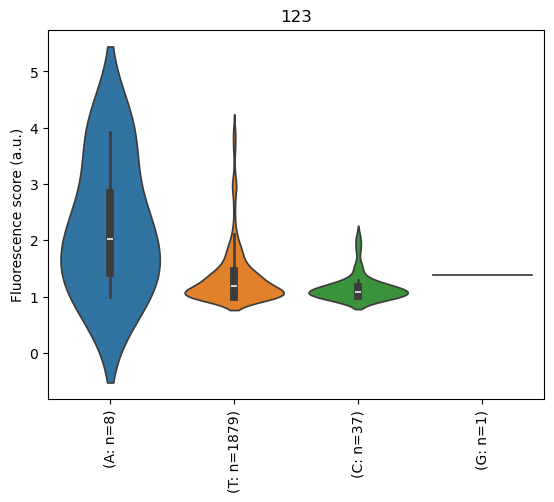

In [114]:
individual_point_mutation_function('dIS3_IS3_R', 'GFP', 123, 'top')
#plt.savefig("3R_position_125.pdf")

## S8e

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      C   1.8142    0.0   1.418  2.2103   True
     A      G   0.1282 0.8731 -0.3064  0.5628  False
     A      T   0.1602 0.6686 -0.2031  0.5234  False
     C      G   -1.686    0.0 -1.9749 -1.3971   True
     C      T   -1.654    0.0  -1.817 -1.4911   True
     G      T    0.032 0.9864 -0.2098  0.2739  False
----------------------------------------------------


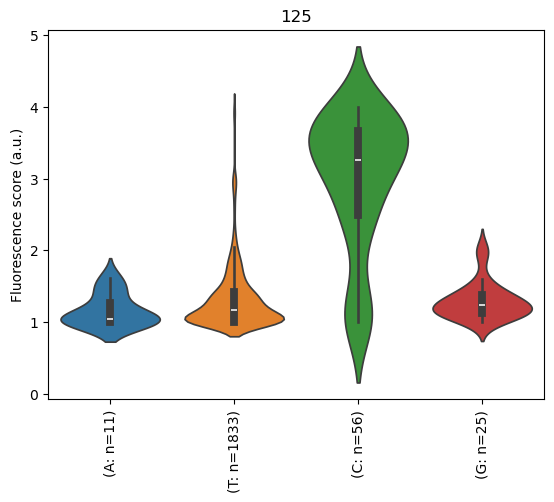

In [115]:
individual_point_mutation_function('dIS3_IS3_R', 'GFP', 125, 'top')
#plt.savefig("3R_position_123.pdf")

# Figure S9

## S9a

 total bits: 0.03747796362852483


(0.0, 0.0033991467220964564)

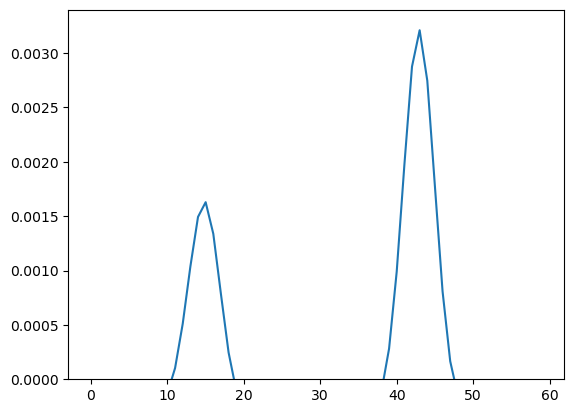

In [51]:
information = calculate_mutual_information('DIS3_IS150_R', 'GFP', 2)
information = information[20:80]
sns.lineplot(information)
plt.ylim(0)

## S9b

below threshold: TATTGA
above threshold: TATTGT
median without motif: 1.111111111111111
median with motif: 2.7134920634920636
2.5398990252614625e-10


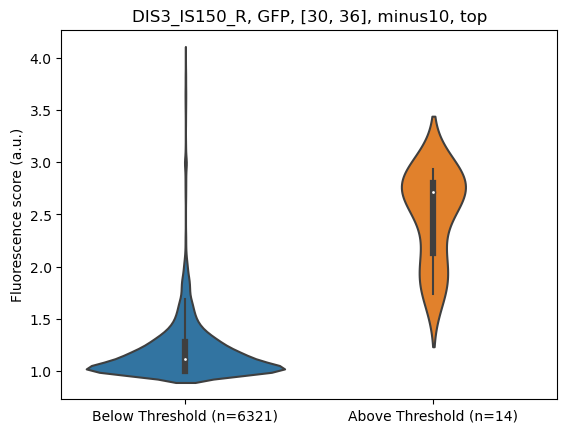

In [52]:
### KWARGS
ID = 'DIS3_IS150_R'
Fluor = 'GFP'
ROI = [30, 36]
TF = 'minus10'
orientation = 'top'

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

#plt.savefig(f'{ID}_{Fluor}_{str(ROI)}_{TF}_{orientation}.pdf')

## S9b prime

below threshold: TATTGA
above threshold: TATTGT
median without motif: 1.037037037037037
median with motif: 1.2214285714285715
8.660222403505884e-05


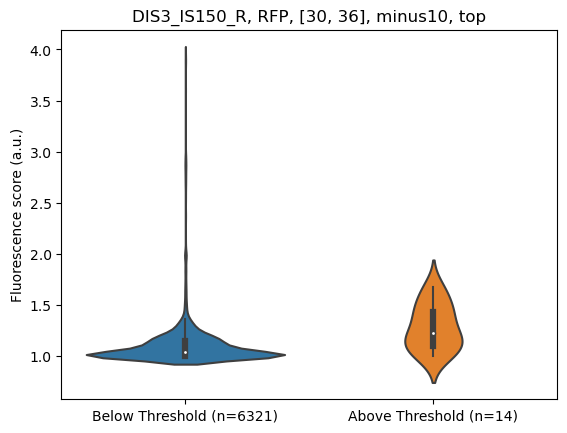

In [55]:
### KWARGS
ID = 'DIS3_IS150_R'
Fluor = 'RFP'
ROI = [30, 36]
TF = 'minus10'
orientation = 'top'

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

#plt.savefig(f'{ID}_{Fluor}_{str(ROI)}_{TF}_{orientation}.pdf')

## S9c

below threshold: TGAAAT
above threshold: TAAAAT
median without motif: 1.111111111111111
median with motif: 3.0
1.0312311692835446e-14


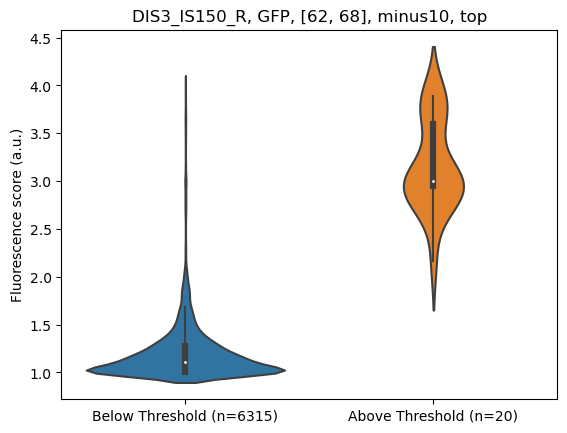

In [53]:
### KWARGS
ID = 'DIS3_IS150_R'
Fluor = 'GFP'
ROI = [62, 68]
TF = 'minus10'
orientation = 'top'

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

#plt.savefig(f'{ID}_{Fluor}_{str(ROI)}_{TF}_{orientation}.pdf')

## S9c prime

below threshold: TGAAAT
above threshold: TAAAAT
median without motif: 1.037037037037037
median with motif: 1.0476190476190474
0.6646992993390999


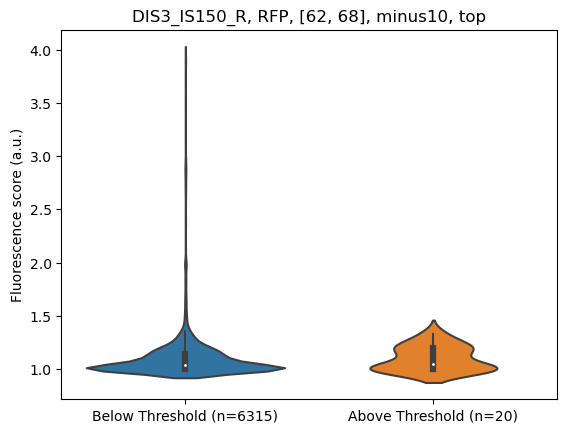

In [58]:
### KWARGS
ID = 'DIS3_IS150_R'
Fluor = 'RFP'
ROI = [62, 68]
TF = 'minus10'
orientation = 'top'

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

#plt.savefig(f'{ID}_{Fluor}_{str(ROI)}_{TF}_{orientation}.pdf')

## S9d

 total bits: 0.06332735124565833


(0.0, 0.0046785892831401705)

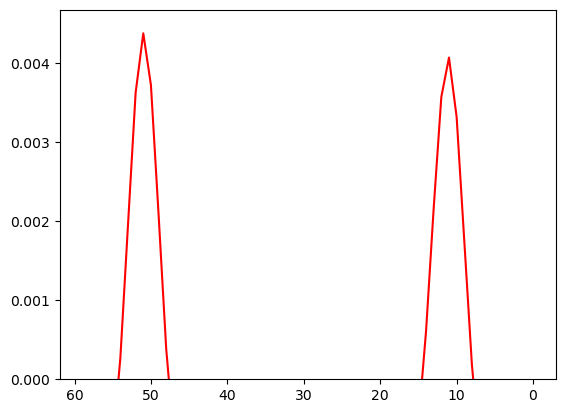

In [79]:
information = calculate_mutual_information('dIS3_IS3_L', 'mScarlet', 2)
information = information[30:90]
plt.gca().invert_xaxis() # only for bottom strand
sns.lineplot(information, color='red')
plt.ylim(0)

## S9e

threshold score is: 4.144655227661133
below threshold: GATACT
above threshold: TATACT
median without motif: 1.0419685990338163
median with motif: 1.991328320204656
p=2.5158561778068e-10


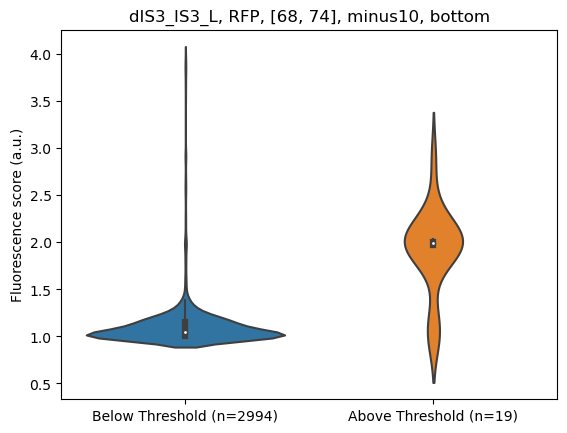

In [70]:
individual_increase_slide_function('dIS3_IS3_L', 'RFP', [68,74], 'bottom', 'minus10')
#plt.savefig("hotspot_12_increase_10_score.pdf")

## S9e prime

threshold score is: 4.144655227661133
below threshold: GATACT
above threshold: TATACT
median without motif: 1.1166666666666667
median with motif: 1.138888888888889
p=0.8609113797199544


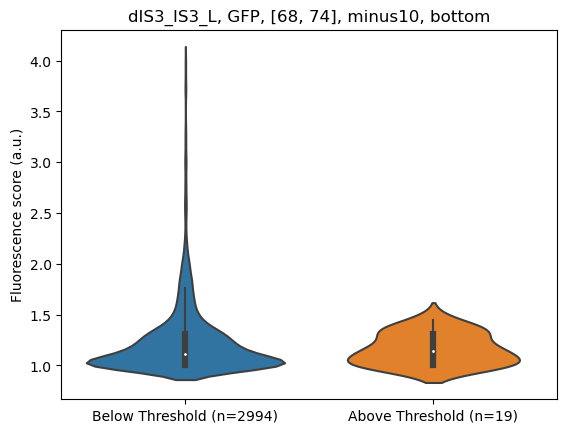

In [71]:
individual_increase_slide_function('dIS3_IS3_L', 'GFP', [68,74], 'bottom', 'minus10')
#plt.savefig("hotspot_12_increase_10_score.pdf")

## S9f

below threshold: TTTACT
above threshold: TATACT
median without motif: 1.042347386912604
median with motif: 1.98954990801352
1.6104638073295408e-11


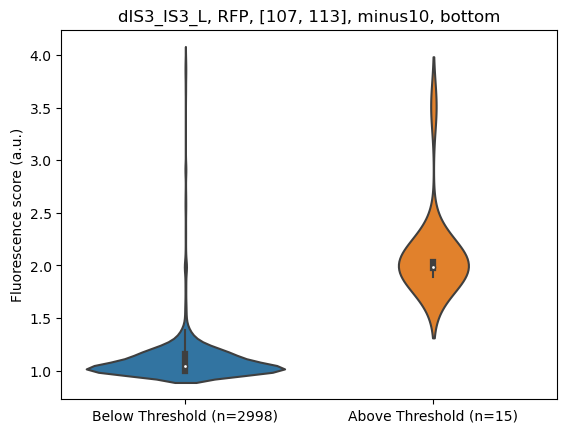

In [72]:
### KWARGS
ID = 'dIS3_IS3_L'
Fluor = 'RFP'
ROI = [107, 113]
TF = 'minus10'
orientation = 'bottom'

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

#plt.savefig(f'{ID}_{Fluor}_{str(ROI)}_{TF}_{orientation}.pdf')

## S9f prime

below threshold: TTTACT
above threshold: TATACT
median without motif: 1.1166666666666667
median with motif: 1.569922112693197
0.018501306182853002


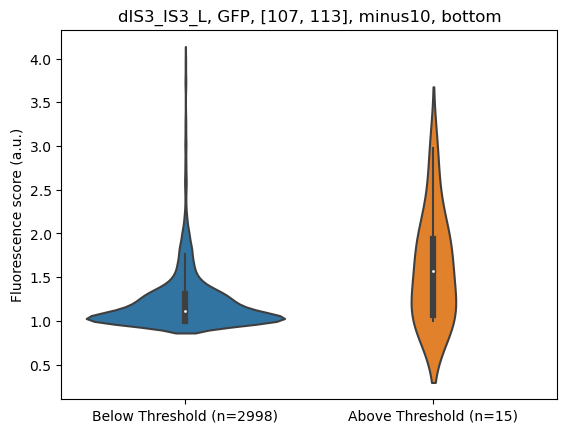

In [73]:
### KWARGS
ID = 'dIS3_IS3_L'
Fluor = 'GFP'
ROI = [107, 113]
TF = 'minus10'
orientation = 'bottom'

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

#plt.savefig(f'{ID}_{Fluor}_{str(ROI)}_{TF}_{orientation}.pdf')

## S9g

 total bits: 0.03692560684060251


(0.0, 0.005316639271161371)

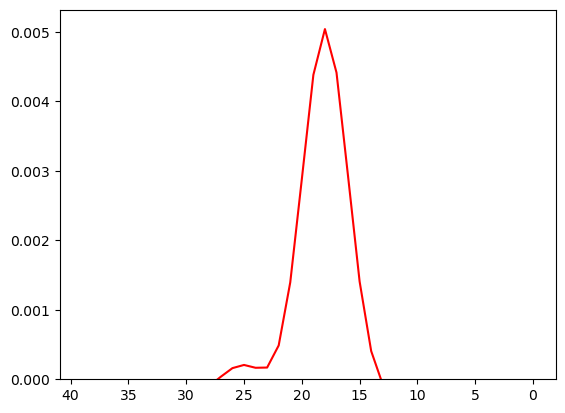

In [78]:
information = calculate_mutual_information('DIS3_IS150_R', 'mScarlet', 2)
information = information[30:70]
plt.gca().invert_xaxis() # only for bottom strand
sns.lineplot(information, color='red')
plt.ylim(0)

## S9h

In [80]:
### Import low-affinity -10 box PWM
PSSM_txt_open = open('sigma70.fasta', 'r') #Only the -10 and -35 motifs
PSSM_txt = PSSM_txt_open.read()
PSSM_list = PSSM_txt.split('>')
PSSM_list = PSSM_list[1:]

for n in range(len(PSSM_list)):
    PSSM = str(PSSM_list[n])
    list_of_PSSMs = PSSM.split('\n')
    TF_name = list_of_PSSMs[0]

    TF_name += '_low'
    
    list_of_TFs.append(TF_name)
    list_of_PSSMs = list_of_PSSMs[1:-1]

    Instances = []
    for x in range(len(list_of_PSSMs)):
        Instance = Seq(list_of_PSSMs[x])
        Instances.append(Instance)

    m = motifs.create(Instances)
    background = {"A":0.25, "C": 0.25, "G": 0.25, "T": 0.25}
    m_pwm = m.counts.normalize(pseudocounts=background)
    m_pssm = m_pwm.log_odds(background)
    distribution = m_pssm.distribution(background=background, precision=10**4)
    threshold = distribution.threshold_patser()/2 #Hertz and Stormo divided by 2
    PSSMs_dict[TF_name] = m_pssm
    threshold_dict[TF_name] = threshold   
    window_size_dict[TF_name] = len(m_pwm.consensus)
    
print("PSSMs and thresholds calculated!")

PSSMs and thresholds calculated!


below threshold: TGCTGT
above threshold: TACTGT
median without motif: 1.037037037037037
median with motif: 1.8459950248756218
9.730779269417937e-22


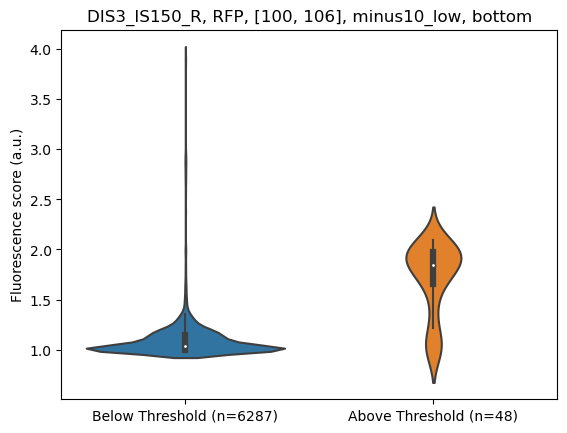

In [81]:
### KWARGS
ID = 'DIS3_IS150_R'
Fluor = 'RFP'
ROI = [100, 106]
orientation = 'bottom'
TF = 'minus10_low'

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

#plt.savefig(f'{ID}_{Fluor}_{str(ROI)}_{TF}_{orientation}.pdf')

## S9h prime

below threshold: TGCTGT
above threshold: TACTGT
median without motif: 1.111111111111111
median with motif: 1.0814102564102563
0.2286164599901267


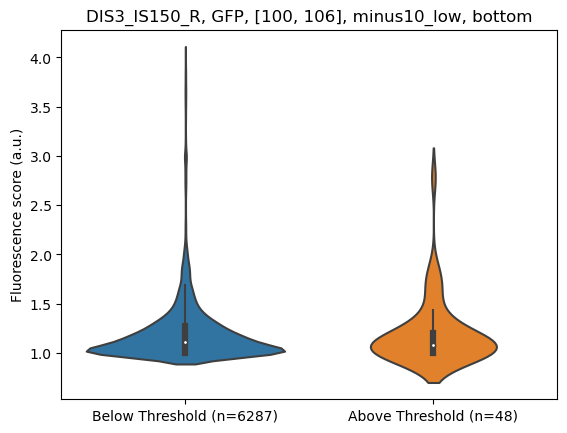

In [82]:
### KWARGS
ID = 'DIS3_IS150_R'
Fluor = 'GFP'
ROI = [100, 106]
orientation = 'bottom'
TF = 'minus10_low'

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)
#
#plt.savefig(f'{ID}_{Fluor}_{str(ROI)}_{TF}_{orientation}.pdf')

## S9i

 total bits: 0.16187389867405136


(0.0, 0.004981305665514346)

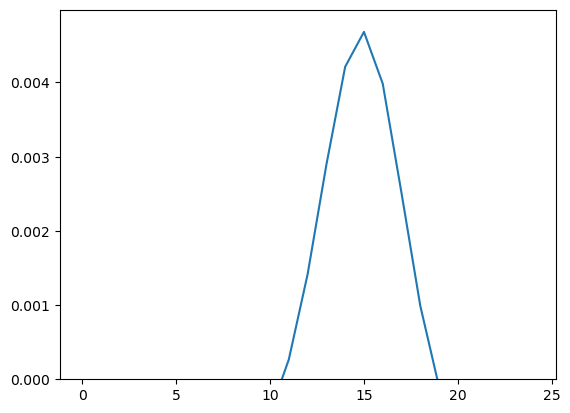

In [86]:
information = calculate_mutual_information('dIS3_IS3_R', 'GFP', 2)
information = information[10:35]
#plt.gca().invert_xaxis() # only for bottom strand
sns.lineplot(information)
plt.ylim(0)

## S9j

below threshold: TTTAAT
above threshold: TATAAT
median without motif: 1.1781746031746032
median with motif: 3.91839085234048
2.6071166769195834e-07


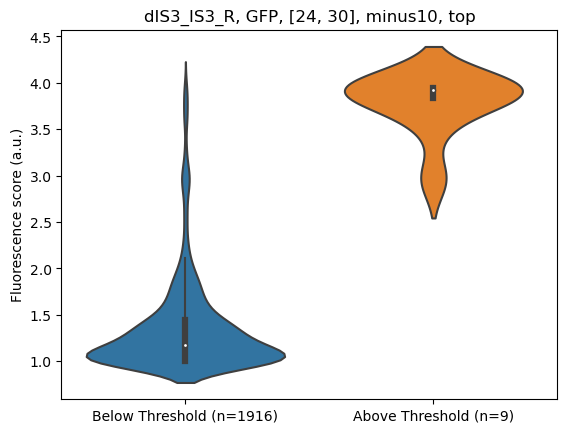

In [87]:
### KWARGS
ID = 'dIS3_IS3_R'
Fluor = 'GFP'
ROI = [24, 30]
TF = 'minus10'
Orientation = "top"

individual_gain_loss_PWM_plots(ID, Fluor, ROI, Orientation, TF)
#plt.savefig("hotspot_14.pdf")

## S9j prime

below threshold: TTTAAT
above threshold: TATAAT
median without motif: 1.010955459770115
median with motif: 1.0
0.2700181282478099


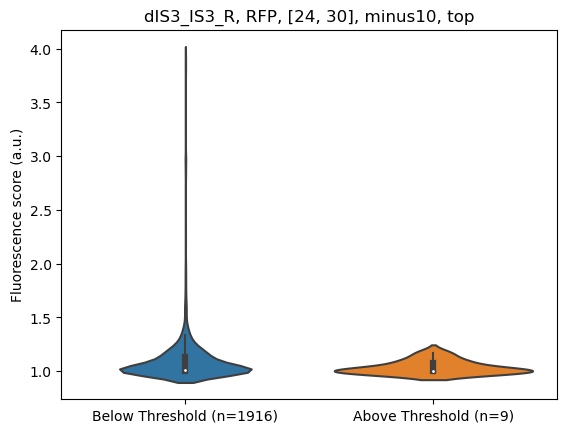

In [88]:
### KWARGS
ID = 'dIS3_IS3_R'
Fluor = 'RFP'
ROI = [24, 30]
TF = 'minus10'
Orientation = "top"

individual_gain_loss_PWM_plots(ID, Fluor, ROI, Orientation, TF)

#plt.savefig(f'{ID}_{Fluor}_{str(ROI)}_{TF}_{orientation}.pdf')

## S9k

 total bits: 0.020469010162537753


(0.0, 0.0004001167946929864)

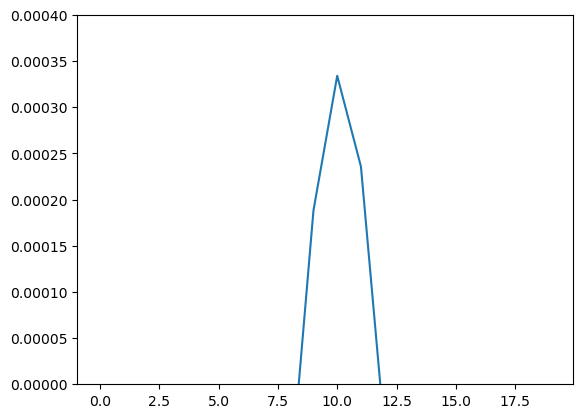

In [91]:
information = calculate_mutual_information('DIS3_IS150_L', 'GFP', 2)
information = information[10:30]
#plt.gca().invert_xaxis() # only for bottom strand
sns.lineplot(information)
plt.ylim(0)

## S9l

below threshold: TGGACG
above threshold: TTGACG
median without motif: 1.142857142857143
median with motif: 2.55349598163031
0.0008533050646189715


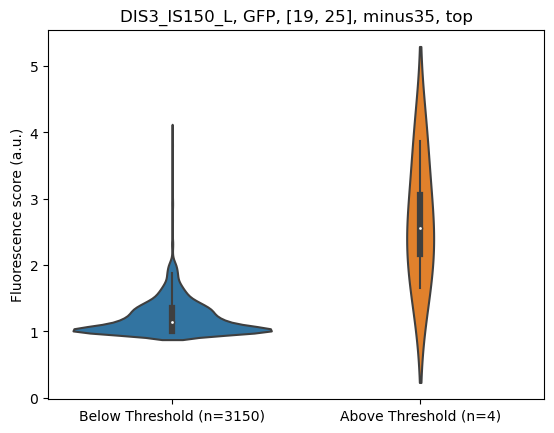

In [92]:
### KWARGS
parent = 'DIS3_IS150_L'
Fluor = 'GFP'
ROI = [19, 25]
#ROI = [18,24]
TF = 'minus35'
Orientation = "top"

individual_gain_loss_PWM_plots(parent, Fluor, ROI, Orientation, TF)

below threshold: TGGACG
above threshold: TTGACG
median without motif: 1.111111111111111
median with motif: 1.2441077441077442
0.4037901601933671


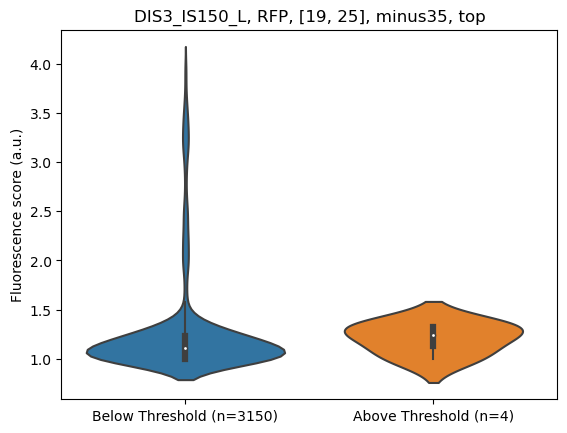

In [94]:
### KWARGS
parent = 'DIS3_IS150_L'
Fluor = 'RFP'
ROI = [19, 25]
#ROI = [18,24]
TF = 'minus35'
Orientation = "top"

individual_gain_loss_PWM_plots(parent, Fluor, ROI, Orientation, TF)
plt.savefig("gain_35_opposite.pdf")

## s9m

 total bits: 0.02440129713769452


(0.0, 0.0002418893000974158)

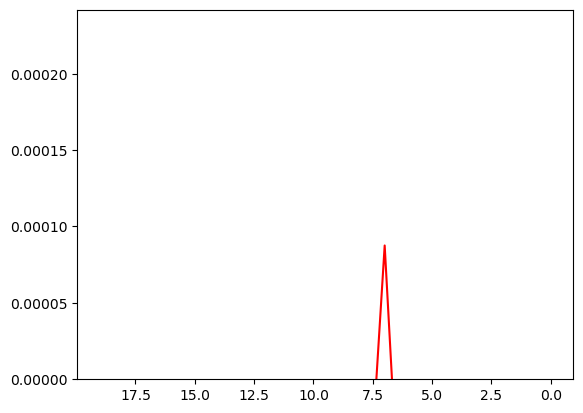

In [106]:
information = calculate_mutual_information('dIS3_IS3_R', 'mScarlet', 2)
information = information[40:60]
plt.gca().invert_xaxis() # only for bottom strand
sns.lineplot(information, color='red')
plt.ylim(0)

## s9n

below threshold: TGTAAT
above threshold: TATAAT
median without motif: 1.0075396825396825
median with motif: 2.9685488564626508
0.11276579309098685


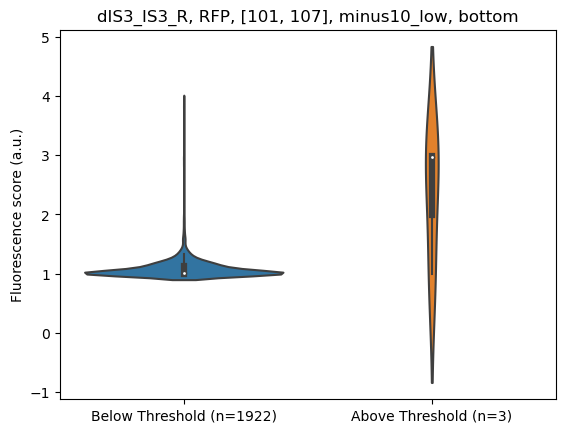

In [101]:
### KWARGS
parent = 'dIS3_IS3_R'
Fluor = 'RFP'
ROI = [101, 107]
#ROI = [18,24]
TF = 'minus10_low'
Orientation = "bottom"

individual_gain_loss_PWM_plots(parent, Fluor, ROI, Orientation, TF)

## s9n prime

below threshold: TGTAAT
above threshold: TATAAT
median without motif: 1.1810185185185185
median with motif: 1.111111111111111
0.5872478128765184


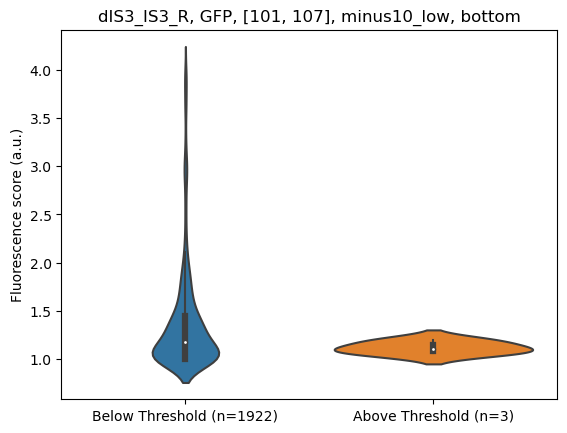

In [103]:
### KWARGS
parent = 'dIS3_IS3_R'
Fluor = 'GFP'
ROI = [101, 107]
#ROI = [18,24]
TF = 'minus10_low'
Orientation = "bottom"

individual_gain_loss_PWM_plots(parent, Fluor, ROI, Orientation, TF)

# Figure S10

## S10a - sigma factors

### sigma28

<Figure size 800x300 with 0 Axes>

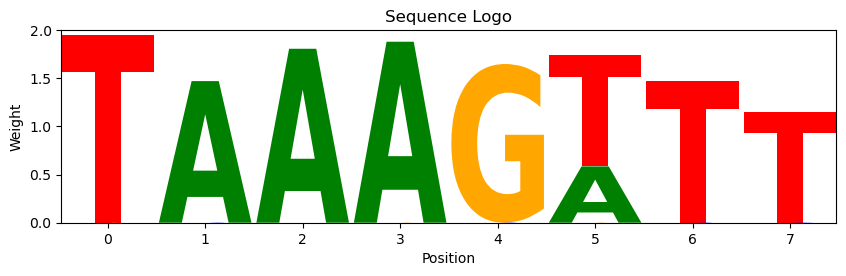

<Figure size 800x300 with 0 Axes>

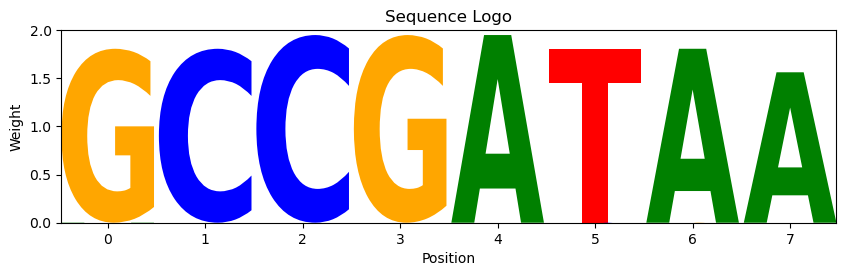

In [126]:
fh = open("pwms/sigma28_jaspar.txt")
for m in motifs.parse(fh, "jaspar"):

    TF_name = m.name
    list_of_TFs.append(TF_name)

    m_pwm = m.counts.normalize(pseudocounts=background)
    m_pssm = m_pwm.log_odds(background)
    distribution = m_pssm.distribution(background=background, precision=10**4)
    threshold = distribution.threshold_patser() #Hertz and Stormo
    PSSMs_dict[TF_name] = m_pssm
    threshold_dict[TF_name] = threshold
    window_size_dict[TF_name] = len(m_pwm.consensus)
    
    pwm = pd.DataFrame(PSSMs_dict[TF_name])
    
    # Create the logo
    plt.figure(figsize=(len(m_pssm.consensus), 3))
    logomaker.Logo(pwm)

    # Customize appearance (optional)
    plt.title("Sequence Logo")
    plt.xlabel("Position")
    plt.ylabel("Weight")
    plt.ylim(0,2)

### sigma54

<Figure size 1800x300 with 0 Axes>

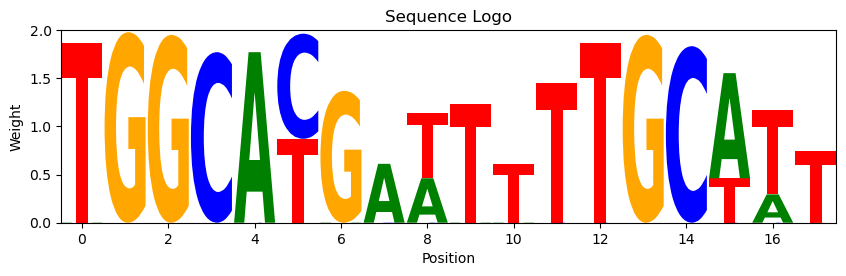

In [127]:
PSSM_txt_open = open('pwms/sigma54.fasta', 'r') #Only the -10 and -35 motifs
PSSM_txt = PSSM_txt_open.read()
PSSM_list = PSSM_txt.split('>')
PSSM_list = PSSM_list[1:]

for n in range(len(PSSM_list)):
    PSSM = str(PSSM_list[n])
    list_of_PSSMs = PSSM.split('\n')
    TF_name = list_of_PSSMs[0]
    list_of_TFs.append(TF_name)
    list_of_PSSMs = list_of_PSSMs[1:-1]

    Instances = []
    for x in range(len(list_of_PSSMs)):
        Instance = Seq(list_of_PSSMs[x])
        Instances.append(Instance)

    m = motifs.create(Instances)
    background = {"A":0.25, "C": 0.25, "G": 0.25, "T": 0.25}
    m_pwm = m.counts.normalize(pseudocounts=background)
    m_pssm = m_pwm.log_odds(background)
    distribution = m_pssm.distribution(background=background, precision=10**4)
    threshold = distribution.threshold_patser() #Hertz and Stormo
    PSSMs_dict[TF_name] = m_pssm
    threshold_dict[TF_name] = threshold
    window_size_dict[TF_name] = len(m.consensus)
    
    pwm = pd.DataFrame(PSSMs_dict[TF_name])
    
    # Create the logo
    plt.figure(figsize=(len(m_pssm.consensus), 3))
    logomaker.Logo(pwm)

    # Customize appearance (optional)
    plt.title("Sequence Logo")
    plt.xlabel("Position")
    plt.ylabel("Weight")
    plt.ylim(0,2)

### sigma32

<Figure size 900x300 with 0 Axes>

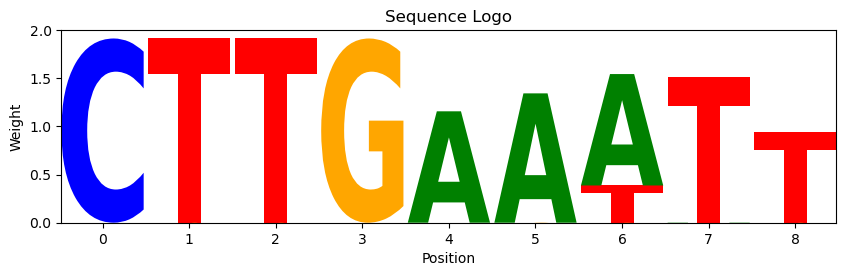

<Figure size 900x300 with 0 Axes>

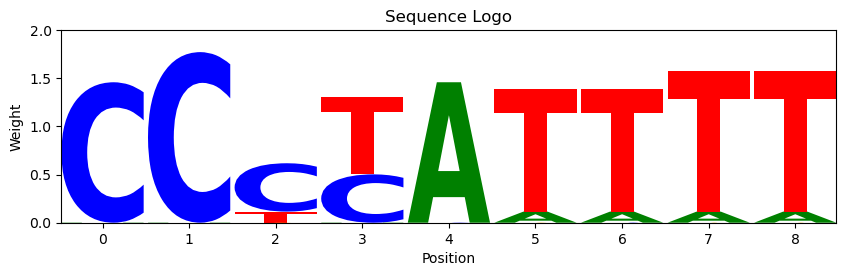

In [128]:
PSSM_txt_open = open('pwms/sigma32.fasta', 'r') #Only the -10 and -35 motifs
PSSM_txt = PSSM_txt_open.read()
PSSM_list = PSSM_txt.split('>')
PSSM_list = PSSM_list[1:]

for n in range(len(PSSM_list)):
    PSSM = str(PSSM_list[n])
    list_of_PSSMs = PSSM.split('\n')
    TF_name = list_of_PSSMs[0]
    list_of_TFs.append(TF_name)
    list_of_PSSMs = list_of_PSSMs[1:-1]

    Instances = []
    for x in range(len(list_of_PSSMs)):
        Instance = Seq(list_of_PSSMs[x])
        Instances.append(Instance)

    m = motifs.create(Instances)
    background = {"A":0.25, "C": 0.25, "G": 0.25, "T": 0.25}
    m_pwm = m.counts.normalize(pseudocounts=background)
    m_pssm = m_pwm.log_odds(background)
    distribution = m_pssm.distribution(background=background, precision=10**4)
    threshold = distribution.threshold_patser() #Hertz and Stormo
    PSSMs_dict[TF_name] = m_pssm
    threshold_dict[TF_name] = threshold
    window_size_dict[TF_name] = len(m_pwm.consensus)
    
    pwm = pd.DataFrame(PSSMs_dict[TF_name])
    
    # Create the logo
    plt.figure(figsize=(len(m_pssm.consensus), 3))
    logomaker.Logo(pwm)

    # Customize appearance (optional)
    plt.title("Sequence Logo")
    plt.xlabel("Position")
    plt.ylabel("Weight")
    plt.ylim(0,2)

### sigmaH

sigH_35
sigH_10


<Figure size 800x300 with 0 Axes>

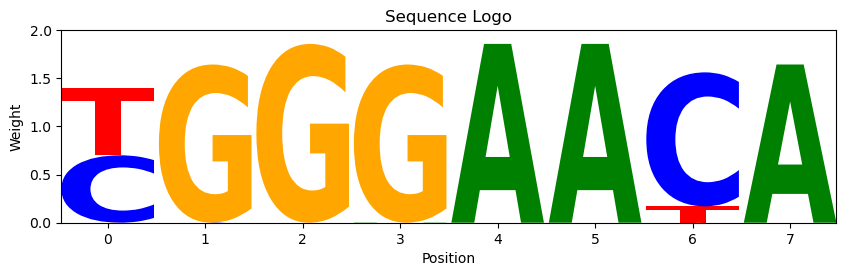

<Figure size 500x300 with 0 Axes>

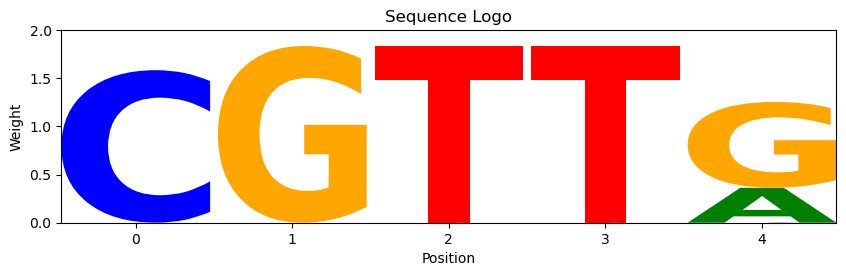

In [129]:
PSSM_txt_open = open('pwms/sigmaH.fasta', 'r') #Only the -10 and -35 motifs
PSSM_txt = PSSM_txt_open.read()
PSSM_list = PSSM_txt.split('>')
PSSM_list = PSSM_list[1:]

for n in range(len(PSSM_list)):
    PSSM = str(PSSM_list[n])
    list_of_PSSMs = PSSM.split('\n')
    TF_name = list_of_PSSMs[0]
    
    print(TF_name)
    
    list_of_TFs.append(TF_name)
    list_of_PSSMs = list_of_PSSMs[1:-1]

    Instances = []
    for x in range(len(list_of_PSSMs)):
        Instance = Seq(list_of_PSSMs[x])
        Instances.append(Instance)

    m = motifs.create(Instances)
    background = {"A":0.25, "C": 0.25, "G": 0.25, "T": 0.25}
    m_pwm = m.counts.normalize(pseudocounts=background)
    m_pssm = m_pwm.log_odds(background)
    distribution = m_pssm.distribution(background=background, precision=10**4)
    threshold = distribution.threshold_patser() #Hertz and Stormo
    PSSMs_dict[TF_name] = m_pssm
    threshold_dict[TF_name] = threshold
    window_size_dict[TF_name] = len(m_pwm.consensus)
    
    pwm = pd.DataFrame(PSSMs_dict[TF_name])
    
    # Create the logo
    plt.figure(figsize=(len(m_pssm.consensus), 3))
    logomaker.Logo(pwm)

    # Customize appearance (optional)
    plt.title("Sequence Logo")
    plt.xlabel("Position")
    plt.ylabel("Weight")
    plt.ylim(0,2)

## S10b

below threshold: GCCTGAAAT
above threshold: GCCTAAAAT
median without motif: 1.111111111111111
median with motif: 2.996544035674471
3.790961071487018e-12


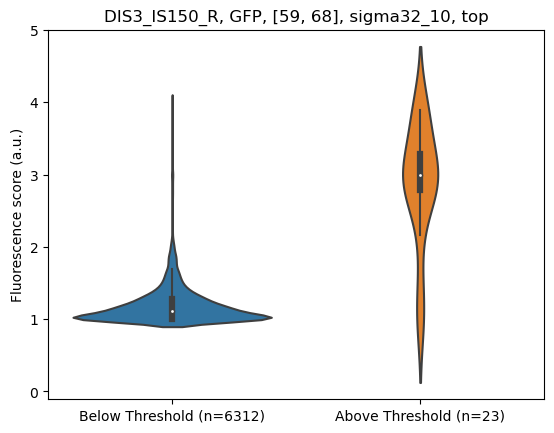

In [132]:
### KWARGS
ID = 'DIS3_IS150_R'
Fluor = 'GFP'
ROI = [59, 68]
orientation = 'top'
TF = 'sigma32_10'

#df = pd.read_csv("trimmed_dataframe.csv")
individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

#plt.savefig("1R_GFP_sigma32_10.pdf")

## S10c

below threshold: TAAAAAAC
above threshold: TAAAGAAC
median without motif: 1.1136363636363635
median with motif: 1.3730158730158728
3.0982858550921793e-06


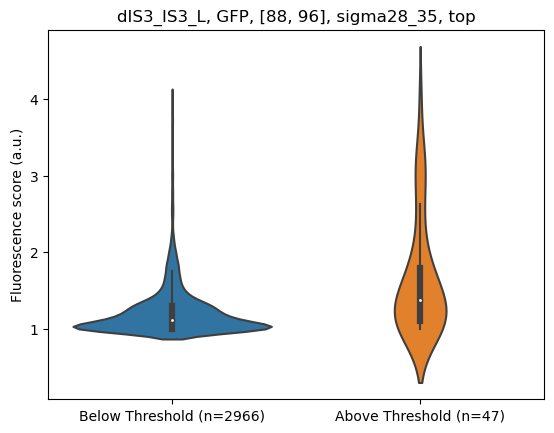

In [136]:
### KWARGS
ID = 'dIS3_IS3_L'
Fluor = 'GFP'
ROI = [88, 96]
orientation = 'top'
TF = 'sigma28_35'

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

## S10d

below threshold: TGAAAACA
above threshold: TGAAGACA
median without motif: 1.1764542483660132
median with motif: 1.3434343434343434
0.0089852668730524


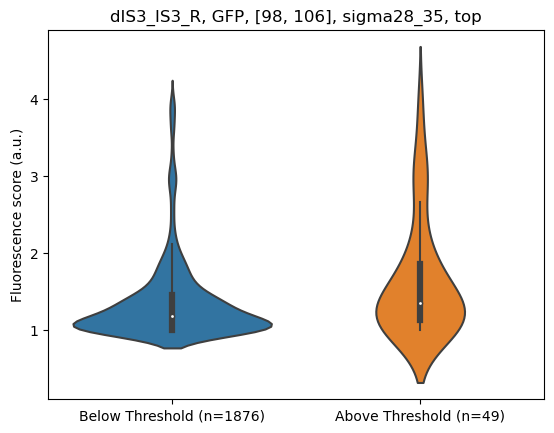

In [138]:
### KWARGS
ID = 'dIS3_IS3_R'
Fluor = 'GFP'
ROI = [98, 106]
orientation = 'top'
TF = 'sigma28_35'

individual_gain_loss_PWM_plots(ID, Fluor, ROI, orientation, TF)

# Figure S11

['IS-10', 'IS1', 'IS2', 'IS4', 'IS5', 'IS6', 'IS7', 'IS8', 'IS9']
IS-10
IS1
IS2
IS4
IS5
IS6
IS7
IS8
IS9
done.


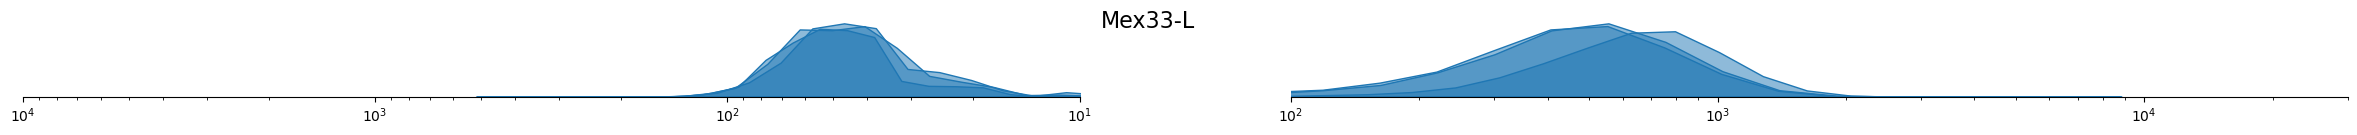

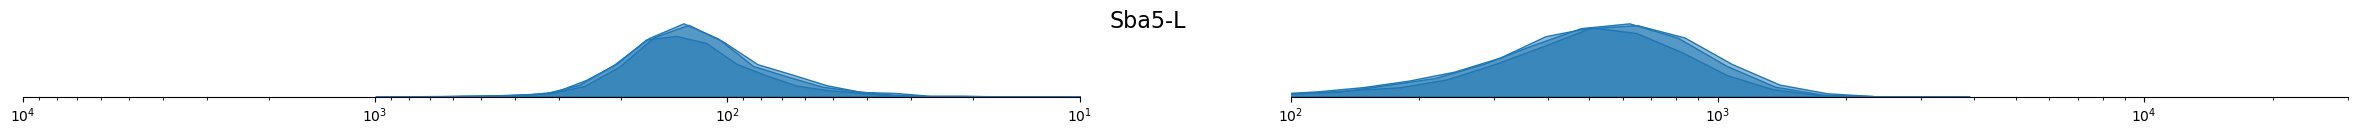

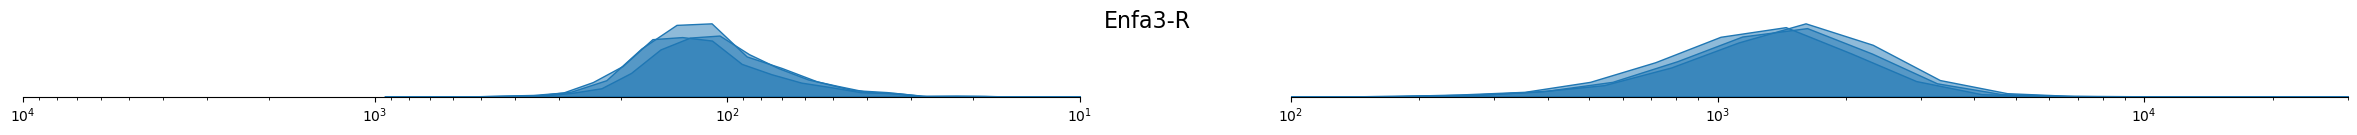

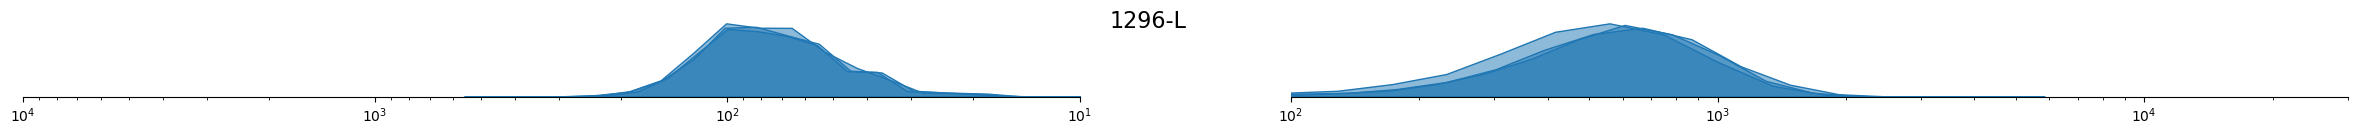

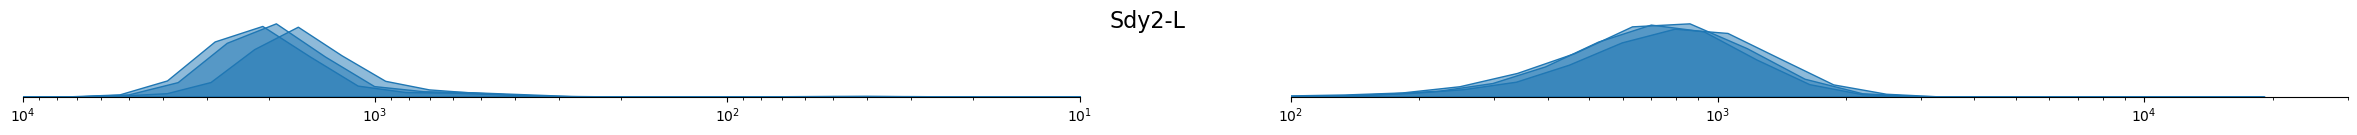

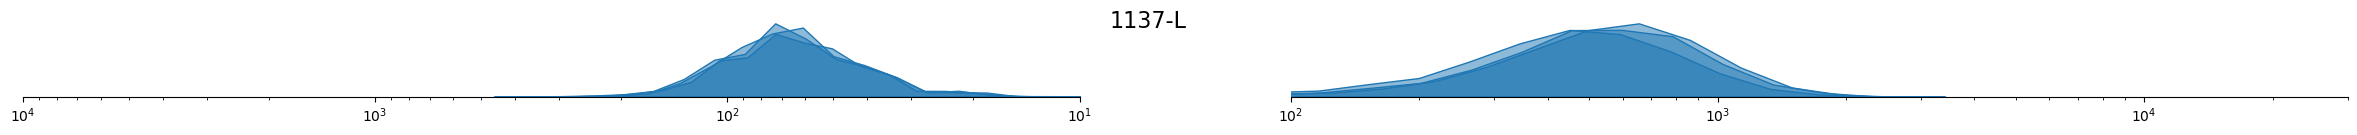

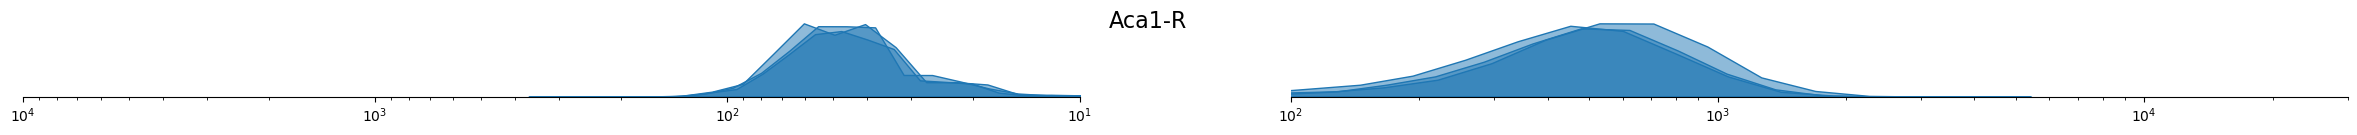

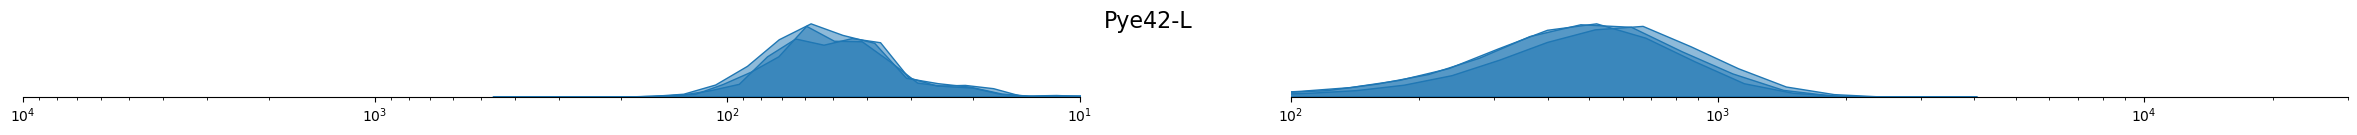

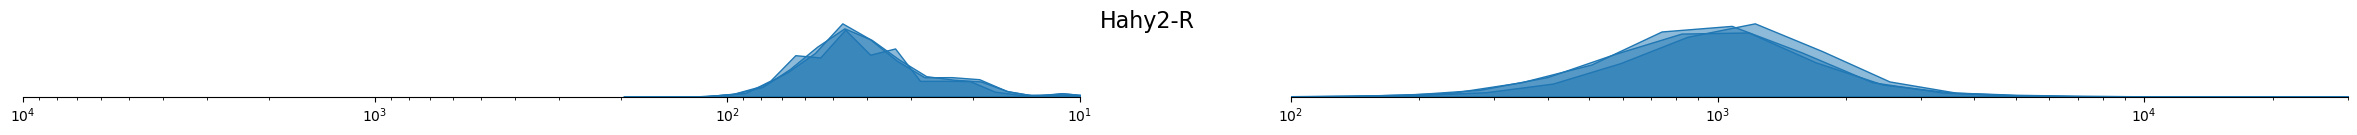

In [35]:
fcsfile = ['WT-dIS3s_IS-10_001_055.fcs', 'WT-dIS3s_IS-10_002_056.fcs', 'WT-dIS3s_IS-10_003_057.fcs', 'WT-dIS3s_IS1_001_028.fcs', 'WT-dIS3s_IS1_002_029.fcs', 'WT-dIS3s_IS1_003_030.fcs', 'WT-dIS3s_IS2_001_031.fcs', 'WT-dIS3s_IS2_002_032.fcs', 'WT-dIS3s_IS2_003_033.fcs', 'WT-dIS3s_IS4_001_037.fcs', 'WT-dIS3s_IS4_002_038.fcs', 'WT-dIS3s_IS4_003_039.fcs', 'WT-dIS3s_IS5_001_040.fcs', 'WT-dIS3s_IS5_002_041.fcs', 'WT-dIS3s_IS5_003_042.fcs', 'WT-dIS3s_IS6_001_043.fcs', 'WT-dIS3s_IS6_002_044.fcs', 'WT-dIS3s_IS6_003_045.fcs', 'WT-dIS3s_IS7_001_046.fcs', 'WT-dIS3s_IS7_002_047.fcs', 'WT-dIS3s_IS7_003_048.fcs', 'WT-dIS3s_IS8_001_049.fcs', 'WT-dIS3s_IS8_002_050.fcs', 'WT-dIS3s_IS8_003_051.fcs', 'WT-dIS3s_IS9_001_052.fcs', 'WT-dIS3s_IS9_002_053.fcs', 'WT-dIS3s_IS9_003_054.fcs']
fcsfile = ['fcs_files/' + n for n in fcsfile]

name_dictionary = {}
name_dictionary['IS1'] = 'Sba5-L'
name_dictionary['IS2'] = 'Enfa3-R'
name_dictionary['IS3'] = 'Pin3-L'
name_dictionary['IS4'] = '1296-L'
name_dictionary['IS5'] = 'Sdy2-L'
name_dictionary['IS6'] = '1137-L'
name_dictionary['IS7'] = 'Aca1-R'
name_dictionary['IS8'] = 'Pye42-L'
name_dictionary['IS9'] = 'Hahy2-R'
name_dictionary['IS-10'] = 'Mex33-L'

# Get the base file names as a list
base_file_names = []
for file in fcsfile:
    Filename = file.replace("fcs_files/WT-dIS3s_","") # Remove the root
    Filename = Filename[:-8] # Remove the .fcs and order of acquision from the end
    split = Filename.split('_')
    base_file_names.append(split[0])
base_file_names = list(dict.fromkeys(base_file_names)) # Remove the duplicates
print(base_file_names)

# Plot the data
for base_file in base_file_names:
    print(base_file)
    
    # Create a new figure for each base_file
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(30, 1))
    fig.suptitle(name_dictionary[base_file], fontsize=16)
    
    for file in fcsfile: 
        if base_file in file:
    
            s = FlowCal.io.FCSData(file)
            GFP = s[:, ['FITC-H']]
            GFP = GFP +1 # Otherwise the log scaling doesn't work...

            mScarlet = s[:, ['PE-H']]
            mScarlet = mScarlet +1 # Otherwise the log scaling doesn't work...

            # Plot RFP
            sns.histplot(mScarlet, bins=30, element='poly', color='greens', log_scale=True, ax=ax1, legend=False, alpha=0.5)
            ax1.set_xlim([10, 10000])
            ax1.set(ylabel=None)
            ax1.invert_xaxis()
            ax1.set(yticklabels=[])
            ax1.tick_params(left=False)

            # Plot GFP
            sns.histplot(GFP, bins=30, element='poly', log_scale=True, ax=ax2, legend=False, alpha=0.5)        
            ax2.set_xlim([100, 30000])
            ax2.set(ylabel=None)
            ax2.set(yticklabels=[])
            ax2.tick_params(left=False)
            sns.despine(bottom = False, left = True)

print("done.")

# Figure S12

## S12a

In [138]:
sequence = 'TTGACATATTAGGGGCTATTCCATTTCATCGTCCAACAAAATGGGTGCAGTACA'
#sequence = str(Seq(sequence).reverse_complement()) ### Uncomment for reverse-complement ###



list_of_TFs = 'minus10', 'minus35'
for TF in list_of_TFs:
    
    # Loop through the sliding window
    window_start = 0
    window_size = 6
    for window_start in range(len(sequence)):
        window = [window_start, window_size+window_start]
        if window[1] <= len(sequence):
    
            # Crop the sequence to the window
            crop_sequence = sequence[window[0]:window[1]]
    
            # Calculate the PWM score
            initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
            for position, score in PSSMs_dict[TF].search(crop_sequence):
    
                # Only looking on the top strand
                if position>=0:
                    initial_score = score
    
                    # Append to a list
                    print(f'{crop_sequence}: {initial_score} : {TF}')

TTGACA: 8.390250205993652 : minus35
TTCCAT: 2.281468152999878 : minus35
TTTCAT: 4.383829593658447 : minus35


### S12b

In [140]:
sequence = 'AAGCGAACTGAAGGATGCTGTTACGGAATATATTGAATACTACAACAGCAGAAGAATTAGCCTGAAATTAAAA'
#sequence = str(Seq(sequence).reverse_complement()) ### Uncomment for reverse-complement ###



list_of_TFs = 'minus10', 'minus35'
for TF in list_of_TFs:
    
    # Loop through the sliding window
    window_start = 0
    window_size = 6
    for window_start in range(len(sequence)):
        window = [window_start, window_size+window_start]
        if window[1] <= len(sequence):
    
            # Crop the sequence to the window
            crop_sequence = sequence[window[0]:window[1]]
    
            # Calculate the PWM score
            initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
            for position, score in PSSMs_dict[TF].search(crop_sequence):
    
                # Only looking on the top strand
                if position>=0:
                    initial_score = score
    
                    # Append to a list
                    print(f'{crop_sequence}: {initial_score} : {TF}')

GATGCT: 0.7255251407623291 : minus10
GAATAT: 3.503995418548584 : minus10
TATATT: 7.249354839324951 : minus10
TAGCCT: 1.2731794118881226 : minus10
GAAATT: 2.610058307647705 : minus10
TTGAAT: 7.935196399688721 : minus35
ATTAAA: 0.7440621852874756 : minus35
TTAAAA: 5.040298938751221 : minus35


# Library summary

In [107]:
print(f'There are {len(df)} daughter sequences in the dataframe.')

There are 18537 daughter sequences in the dataframe.


In [108]:
parents = ['dIS3_IS3_R', 'dIS3_IS3_L', 'DIS3_IS150_L', 'DIS3_IS150_R', 'DIS3_IS2_R']
for parent in parents:
    sub_df = df[df['parent_seq'] == parent]
    print(f'{parent} has {len(sub_df)} daughters.')

dIS3_IS3_R has 1925 daughters.
dIS3_IS3_L has 3013 daughters.
DIS3_IS150_L has 3154 daughters.
DIS3_IS150_R has 6335 daughters.
DIS3_IS2_R has 4110 daughters.


In [112]:
sub_df = df[df['Levenshtein_dist'] == 1]
print(f'There are {len(sub_df)} daughters with 1 mutation.')

sub_df = df[df['Levenshtein_dist'] == 2]
print(f'There are {len(sub_df)} daughters with 2 mutations.')

sub_df = df[df['Levenshtein_dist'] == 3]
print(f'There are {len(sub_df)} daughters with 3 mutations.')

sub_df = df[df['Levenshtein_dist'] >= 4]
print(f'There are {len(sub_df)} daughters with 4 or more mutations.')

There are 1549 daughters with 1 mutation.
There are 14663 daughters with 2 mutations.
There are 1710 daughters with 3 mutations.
There are 615 daughters with 4 or more mutations.


In [113]:
for parent in parents:
    sub_df = df[df['parent_seq'] == parent]
    
    one_count = 0
    two_count = 0
    three_count = 0
    four_plus_count = 0
    
    for i, row in sub_df.iterrows():
        hd = row['Levenshtein_dist']
        if hd == 1:
            one_count +=1
        elif hd == 2:
            two_count +=1
        elif hd == 3:
            three_count +=1
        elif hd >= 4:
            four_plus_count +=1

    print(f'{parent}: 1 mut: {one_count}, 2 muts: {two_count}, 3 muts: {three_count}, 4+ muts: {four_plus_count}')

dIS3_IS3_R: 1 mut: 303, 2 muts: 1415, 3 muts: 159, 4+ muts: 48
dIS3_IS3_L: 1 mut: 300, 2 muts: 2377, 3 muts: 246, 4+ muts: 90
DIS3_IS150_L: 1 mut: 323, 2 muts: 2378, 3 muts: 309, 4+ muts: 144
DIS3_IS150_R: 1 mut: 278, 2 muts: 5170, 3 muts: 681, 4+ muts: 206
DIS3_IS2_R: 1 mut: 345, 2 muts: 3323, 3 muts: 315, 4+ muts: 127


In [114]:
for parent in parents:
    sub_df = df[df['parent_seq'] == parent]

    # GFP_score + RFP_score
    one_score = 0
    two_score = 0
    three_score = 0
    four_score = 0
    
    for i, row in sub_df.iterrows():
        GFP_score = np.round(row['GFP_mean'])
        RFP_score = np.round(row['mScarlet_mean'])

        # GFP_score
        if GFP_score == 1:
            one_score +=1
        elif GFP_score == 2:
            two_score +=1
        elif GFP_score == 3:
            three_score +=1
        elif GFP_score == 4:
            four_score +=1

        # RFP_score
        if RFP_score == 1:
            one_score +=1
        elif RFP_score == 2:
            two_score +=1
        elif RFP_score == 3:
            three_score +=1
        elif RFP_score == 4:
            four_score +=1

    print(f'{parent}: 1 au: {one_score}, 2 au: {two_score}, 3 au: {three_score}, 4 au: {four_score}')

dIS3_IS3_R: 1 au: 3362, 2 au: 368, 3 au: 77, 4 au: 43
dIS3_IS3_L: 1 au: 5530, 2 au: 412, 3 au: 58, 4 au: 26
DIS3_IS150_L: 1 au: 5554, 2 au: 553, 3 au: 157, 4 au: 44
DIS3_IS150_R: 1 au: 11826, 2 au: 696, 3 au: 114, 4 au: 34
DIS3_IS2_R: 1 au: 7629, 2 au: 504, 3 au: 63, 4 au: 24


# Processing sequencing reads

### 1-1: Test that the sequencing file can be properly opened

In [28]:
Filename = 'merged.fastq'
for record in SeqIO.parse(Filename, 'fastq'):
    example = record
    break
    
print(example.id)
print(example.seq)

A00604:520:H7NKGDSX5:1:1101:9661:1501
CGCGATCGCAAGGATCCTGTACTGACCCCAAAAAGTTGGACAGTTAAACACGAGGCATATAGGTCTGATTCCGATATTCAATTGGAGTCAGACCTTTTAATTTCAGGCTAATTCTTCTGCTGTTGTAGTATTCAATATATTCCGTAACAGCATCCTTCAGTTCGCTTGAATTCAGCCTTAATTAAAATTCGCGAGCTATATC


### 1-2: Crop the paired-end reads at their restriction sites

In [29]:
### Get the sequences in the correct orientation
sequences = []
n=0
for record in SeqIO.parse(Filename, 'fastq'):
    if n % 1000000 == 0:
        print(n)

    Sequence = record.seq
    EcoRI_coordinate = Sequence.find('GAATTC')
    BamHI_coordinate = Sequence.find('GGATCC')
    
    # Check if both restriction sites in the sequence
    if EcoRI_coordinate > -1: # -1 means the sequence was not found
        if BamHI_coordinate > -1:
            
            # Put everything in the same orientation
            if EcoRI_coordinate > BamHI_coordinate:
                Sequence = Sequence.reverse_complement()
            else:
                pass
    
            # Crop the sequence at the EcoRI coordinate
            EcoRI_coordinate = Sequence.find('GAATTC')            
            Sequence = Sequence[EcoRI_coordinate-29:] #The barcodes are right behind 
            
            # Crop the sequence at the BamHI coordinate
            Sequence = Sequence.reverse_complement() # Flip first to search from the end of the sequence first
            BamHI_coordinate = Sequence.find('GGATCC')
            Sequence = Sequence[BamHI_coordinate + 6:]
            Sequence = Sequence.reverse_complement() # Flip it back
            
            # Append to a list
            sequences.append(Sequence)
            
    n = n+1
print('done')

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
done


### 1-3: Create a barcode dictionary

In [30]:
### Assign each barcoded sequnece to a unique list called by the dictionary

barcode_list = ['GATCTCATTC',
'CGCTTATCCT',
'TATCATGCAG',
'ATCTGCGTAC',
'GATTGCACGC',
'ATGCTTCCTA',
'TGCTAACTTC',
'ATAGCAGTGC',
'GAGCGAGTCA',
'CAGGCGATCT',
'TTCACGGAAG',
'ATCGACGGCT',
'GCTGACCTGA',
'CGACGTAGTC',
'TCAATGATCG',
'AGTCTCGGCA',
'GATATAGCTC',
'CGTCCGACTT',
'CTCGTGCCTA',
'TAAGATTGCC',
'AGGCCTGACT',
'GTCAATCTTC',
'ATGACGGTAA',
'AGGCTCAAGG',
'GTAAGGCTCC']

print(barcode_list)

barcode_dict = {}
for barcode in barcode_list:
    print(barcode)
    
    hits = []
    for seq in sequences:        
        if barcode in seq[:20]:
            hits.append(seq)

    barcode_dict[barcode] = hits
    
### Print the results
for barcode in barcode_list:
    print(barcode + ':' + str(len(barcode_dict[barcode])))

['GATCTCATTC', 'CGCTTATCCT', 'TATCATGCAG', 'ATCTGCGTAC', 'GATTGCACGC', 'ATGCTTCCTA', 'TGCTAACTTC', 'ATAGCAGTGC', 'GAGCGAGTCA', 'CAGGCGATCT', 'TTCACGGAAG', 'ATCGACGGCT', 'GCTGACCTGA', 'CGACGTAGTC', 'TCAATGATCG', 'AGTCTCGGCA', 'GATATAGCTC', 'CGTCCGACTT', 'CTCGTGCCTA', 'TAAGATTGCC', 'AGGCCTGACT', 'GTCAATCTTC', 'ATGACGGTAA', 'AGGCTCAAGG', 'GTAAGGCTCC']
GATCTCATTC
CGCTTATCCT
TATCATGCAG
ATCTGCGTAC
GATTGCACGC
ATGCTTCCTA
TGCTAACTTC
ATAGCAGTGC
GAGCGAGTCA
CAGGCGATCT
TTCACGGAAG
ATCGACGGCT
GCTGACCTGA
CGACGTAGTC
TCAATGATCG
AGTCTCGGCA
GATATAGCTC
CGTCCGACTT
CTCGTGCCTA
TAAGATTGCC
AGGCCTGACT
GTCAATCTTC
ATGACGGTAA
AGGCTCAAGG
GTAAGGCTCC
GATCTCATTC:4532483
CGCTTATCCT:238885
TATCATGCAG:221598
ATCTGCGTAC:388146
GATTGCACGC:1820777
ATGCTTCCTA:636811
TGCTAACTTC:130129
ATAGCAGTGC:273868
GAGCGAGTCA:1517264
CAGGCGATCT:588028
TTCACGGAAG:101217
ATCGACGGCT:222487
GCTGACCTGA:807681
CGACGTAGTC:558785
TCAATGATCG:285496
AGTCTCGGCA:861558
GATATAGCTC:2951720
CGTCCGACTT:515535
CTCGTGCCTA:667703
TAAGATTGCC:214589
AGGCCTGACT

### 1-4: Trim barcodes and save as individual fasta files

In [32]:
### Crop the barcode off and create fasta files for each sequence

bin_names = ['alpha1',
'alpha2',
'alpha3',
'alpha4',
'beta1',
'beta2',
'beta3',
'beta4',
'gamma1',
'gamma2',
'gamma3',
'gamma4',
'alpha5',
'alpha6',
'alpha7',
'alpha8',
'beta5',
'beta6',
'beta7',
'beta8',
'gamma5',
'gamma6',
'gamma7',
'gamma8',
'library']

n = 0
for barcode in barcode_list:
    print(barcode)
    
    # Remove the cutsite and barcode from each barcode list
    print("   trimming...")
    trimmed = []
    for Sequence in barcode_dict[barcode]:           
        EcoRI_coordinate = Sequence.find('GAATTC')            
        Sequence = Sequence[EcoRI_coordinate+6:] 
        trimmed.append(Sequence)
        
    # Get the unique sequences:
    unique_seqs = list(OrderedDict.fromkeys(trimmed))
    print("   There are: " + str(len(unique_seqs)) + " unique sequences with this barcode.")
    
    # User "Counter" to get the sequence counts
    print("   counting reads...")
    counts_dict = dict(Counter(trimmed))
    counts_list=[]
    for seq in unique_seqs:
        counts_list.append(counts_dict[seq])   
    
    # Add to a new record object
    print("   writing fasta file...")
    records = []
    for x in range(len(unique_seqs)):
        Sequence = unique_seqs[x]
       
        record = SeqRecord(
            Sequence,
            id=str(x),
            name = 'amplicon_' + str(x),
            description = barcode + " reads: " + str(counts_list[x]),
            )
        records.append(record)

    # Save to a fasta file
    SeqIO.write(records, (bin_names[n] + '.fasta'), 'fasta')
    
    n = n+1
print("Done.")

GATCTCATTC
   trimming...
   There are: 432090 unique sequences with this barcode.
   counting reads...
   writing fasta file...
CGCTTATCCT
   trimming...
   There are: 47686 unique sequences with this barcode.
   counting reads...
   writing fasta file...
TATCATGCAG
   trimming...
   There are: 45125 unique sequences with this barcode.
   counting reads...
   writing fasta file...
ATCTGCGTAC
   trimming...
   There are: 27081 unique sequences with this barcode.
   counting reads...
   writing fasta file...
GATTGCACGC
   trimming...
   There are: 261498 unique sequences with this barcode.
   counting reads...
   writing fasta file...
ATGCTTCCTA
   trimming...
   There are: 86981 unique sequences with this barcode.
   counting reads...
   writing fasta file...
TGCTAACTTC
   trimming...
   There are: 31393 unique sequences with this barcode.
   counting reads...
   writing fasta file...
ATAGCAGTGC
   trimming...
   There are: 18986 unique sequences with this barcode.
   counting reads...

### 1-5: Create a pandas dataframe from the fasta files

In [33]:
### Use pandas to make one gigantic csv file:
frames = []
for file in bin_names:
    Filename = file + '.fasta'
    print(Filename)
    sequences = []
    reads = []
    
    ### Create a dataframe for each fasta file called 'fasta_df' and append it to the list called 'frames'
    for record in SeqIO.parse(Filename, 'fasta'):
        sequences.append(str(record.seq))
        
        Read_count = ''.join(filter(str.isdigit, record.description))
        Read_count = (re.findall('\d+', record.description))
        reads.append(int(Read_count[1]))

    fasta_df = pd.DataFrame({'sequence': sequences, file: reads}) # this is a dictionary converted to a dataframe...   
    frames.append(fasta_df)
    
### Concatenate the 'frames' list
df = pd.concat(frames)
print(len(df))

# ### Replace NaN with 0
df = df.fillna(0)

### Change the sequences to index values
df = df.set_index('sequence')

### Combine values that share the same index value
df = df.groupby(df.index).sum()

### Change sequences back to an original column
df = df.reset_index()
print(len(df))

### Remove the first empty row
df = df.iloc[1: , :] # I do not understand why the first position is always empty? It seems to simply be deleting the sequence

### Save to csv
df.to_csv("dataframe.csv", index=False)
df

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
C:\Users\tfuqua\AppData\Local\Temp\ipykernel_16996\3968861751.py:14: SyntaxWarning: invalid escape sequence '\d'
  Read_count = (re.findall('\d+', record.description))


alpha1.fasta
alpha2.fasta
alpha3.fasta
alpha4.fasta
beta1.fasta
beta2.fasta
beta3.fasta
beta4.fasta
gamma1.fasta
gamma2.fasta
gamma3.fasta
gamma4.fasta
alpha5.fasta
alpha6.fasta
alpha7.fasta
alpha8.fasta
beta5.fasta
beta6.fasta
beta7.fasta
beta8.fasta
gamma5.fasta
gamma6.fasta
gamma7.fasta
gamma8.fasta
library.fasta
3364821
1943793


sequence  alpha1  alpha2  \
1        AAAAAAACCTTGCAGAGGCGTTCGAGCATAATAACGAATGGCATCC...     0.0     0.0   
2        AAAAAAACCTTGCAGAGGCGTTCGAGCATTATAACGAATGGCATCC...     0.0     0.0   
3        AAAAAAACCTTGCAGAGGCGTTCGAGCATTATAGCGGATGGCATCC...     0.0     0.0   
4        AAAAAAACCTTGCAGAGGCGTTCGAGCATTATAGCTGATTGCATCC...     0.0     0.0   
5        AAAAAACCATGCAGAGGCGTTCGAGCATTATAACGAATGGCATCCG...     0.0     0.0   
...                                                    ...     ...     ...   
1943788  TTTTTACACTGCATAAGTCTTATGATCAACCAAAGGAACTGGAAAA...     0.0     0.0   
1943789  TTTTTACACTGCATAAGTCTTATGATCAACCAAAGGAACTGGAAAA...     0.0     0.0   
1943790  TTTTTACACTGCATAAGTCTTATGATCAACCAAAGGAACTGGATAA...     0.0     0.0   
1943791  TTTTTACACTGCGTAAGTCTTATGATCAACCAAAGGAACTGGAAAA...     0.0     0.0   
1943792  TTTTTACGCTGCATAAGTCTTATGATCAACCAAAGGAACTGGAAAA...     0.0     0.0   

         alpha3  alpha4  beta1  beta2  beta3  beta4  gamma1  ...  alpha8  \
1           0.0     0.0    0.0    0.0    0.0    0.0     0.0  ...     0.0   
2           0.0     0.0    0.0    0.0    0.0    0.0     0.0  ...     0.0   
3           0.0     0.0    0.0    0.0    0.0    0.0     0.0  ...     0.0   
4           0.0     0.0    0.0    0.0    0.0    0.0     0.0  ...     0.0   
5           0.0     0.0    0.0    0.0    0.0    0.0     1.0  ...     0.0   
...         ...     ...    ...    ...    ...    ...     ...  ...     ...   
1943788     0.0     0.0    0.0    0.0    0.0    0.0     0.0  ...     0.0   
1943789     0.0     0.0    0.0    0.0    0.0    0.0     0.0  ...     1.0   
1943790     0.0     0.0    0.0    0.0    0.0    0.0     0.0  ...     0.0   
1943791     0.0     0.0    0.0    0.0    0.0    0.0     0.0  ...     0.0   
1943792     0.0     0.0    0.0    0.0    0.0    0.0     0.0  ...     0.0   

         beta5  beta6  beta7  beta8  gamma5  gamma6  gamma7  gamma8  library  
1          0.0    0.0    0.0    0.0     1.0     0.0     0.0     0.0      0.0  
2          0.0    0.0    0.0    0.0     1.0     0.0     0.0     0.0      0.0  
3          4.0    0.0    0.0    0.0     9.0     0.0     0.0     0.0      0.0  
4          1.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0      0.0  
5          0.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0      0.0  
...        ...    ...    ...    ...     ...     ...     ...     ...      ...  
1943788    0.0    0.0    0.0    1.0     0.0     0.0     0.0     0.0      0.0  
1943789    0.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0      0.0  
1943790    0.0    0.0    0.0    0.0     0.0     0.0     0.0     1.0      0.0  
1943791    0.0    0.0    1.0    0.0     0.0     0.0     0.0     0.0      0.0  
1943792    0.0    0.0    2.0    0.0     0.0     0.0     0.0     0.0      0.0  

[1943792 rows x 26 columns]

### 1-6: Combine the duplicate sequences in the dataframe to get read counts

In [34]:
sequences_ls = df['sequence'].to_list() # Convert all of the fasta sequences into a list
unique_seqs = list(OrderedDict.fromkeys(sequences_ls))

### 1-7: Identify the parent sequences

In [35]:
### Find the parent sequences for each of these
df = pd.read_csv('dataframe.csv')

fasta_file = 'k12_dIS3s.fasta' # fasta file with the wt 'root' sequences
root_seqs = []
distances = []

sequences_ls = df['sequence'].to_list() # Convert all of the fasta sequences into a list
print(len(sequences_ls))
n = 0
for Seq in sequences_ls: # loop through each sequence
    if n % 100000 == 0:
        print(n)

    for record in SeqIO.parse(fasta_file, 'fasta'): # loop through each root sequence
        LD = int(distance(str(record.seq),Seq)) # Calculate the hamming distance for each with the funtion above

        if LD < 11:
            Root_seq = record.id
            break # You do not need to keep scanning for LDs once you've already found a match
        else:
            Root_seq = 'unknown'

    distances.append(LD)
    root_seqs.append(Root_seq) # Append this value to the root_seqs list so you can make a new column in the df
    n = n+1
    
print(len(root_seqs))
print(len(distances))

### Append these values to the df1
df['parent_seq'] = root_seqs
df['Levenshtein_dist'] = distances

### Save to csv
df.to_csv("dataframe.csv", index=False)

1943792
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
1943792
1943792


### 1-8: Calculate the total number of bins

In [36]:
### Create a new column that gets the number of bins the sequence is found in:
bin_counts = []
for i, row in df.iterrows(): # Iterate through each row
    row_ls = row.values.tolist() # convert the row to a list
    row_ints = [num for num in row_ls if isinstance(num, (int,float))] # Get the integers out of that list
    row_ints = row_ints[:-1] # Remove the LD from the list
    Bin_count = sum(i > 0 for i in row_ints) # Add up the number of bins in the list
    bin_counts.append(Bin_count) # Append to a list 

df['total_bins'] = bin_counts # Add to the dataframe

### 1-9: Calculate read counts for RFP and GFP

In [37]:
### How many total reads do you have for each fluor?

GFP_read_count_list = []
mScarlet_read_count_list = []
for i, row in df.iterrows():
    GFP_read_count = (row['alpha1'] +  row['alpha2'] +  row['alpha3'] +  row['alpha4'] + row['beta1'] +  row['beta2'] +  row['beta3'] +  row['beta4'] +  row['gamma1'] +  row['gamma2'] +  row['gamma3'] +  row['gamma4']) 
    GFP_read_count_list.append(GFP_read_count)
    
    mScarlet_read_count = (row['alpha5'] +  row['alpha6'] +  row['alpha7'] +  row['alpha8'] + row['beta5'] +  row['beta6'] +  row['beta7'] +  row['beta8'] +  row['gamma5'] +  row['gamma6'] +  row['gamma7'] +  row['gamma8'])
    mScarlet_read_count_list.append(mScarlet_read_count)

df['GFP_counts'] = GFP_read_count_list # Add to the dataframe
df['mScarlet_counts'] = mScarlet_read_count_list # Add to the dataframe

### 1-10: Calculate fluorescence scores and standard deviations

In [ ]:
alpha_GFP = []
beta_GFP = []
gamma_GFP = []

def calculate_score(integers, x):
    Score = 0
    Total = 0
    for n in range(4):
        Total = Total + integers[n+x] # How many total reads?     
        Score = Score + (integers[n+x] * (n+1)) # Multiply each bin reads by a weight
    
    if Total == 0: # Cannot divide by 0
        Score = 0
    else:
        Score = Score / Total
    return Score   


# Append to these lists
aGFP_ls = []
bGFP_ls = []
yGFP_ls = []
amSc_ls = []
bmSc_ls = []
ymSc_ls = []
GFP_mean_ls = []
mSc_mean_ls = []
GFP_std_ls = []
mSc_std_ls = []
for i, row in df.iterrows():
    #print(row)
    row_ls = row.values.tolist() # convert the row to a list
    row_ints = [num for num in row_ls if isinstance(num, (int,float))] # Get the integers out of that list
    row_ints = row_ints[:24] # Only get the scores for alpha-gamma 1-8
    
    ### Calculate the scores using the function
    # GFP
    alpha_GFP = calculate_score(row_ints, 0) # 0 is the starting index position for alpha_GFP values
    beta_GFP = calculate_score(row_ints, 4)
    gamma_GFP = calculate_score(row_ints, 8)
    
    aGFP_ls.append(alpha_GFP)
    bGFP_ls.append(beta_GFP)
    yGFP_ls.append(gamma_GFP)   
    
    # mScarlet
    alpha_mScarlet = calculate_score(row_ints, 12)
    beta_mScarlet = calculate_score(row_ints, 16)
    gamma_mScarlet = calculate_score(row_ints, 20)
    
    amSc_ls.append(alpha_mScarlet)
    bmSc_ls.append(beta_mScarlet)
    ymSc_ls.append(gamma_mScarlet)
    
    ### Calculate means and stds
    # GFP non-zero mean
    a = np.array([alpha_GFP,beta_GFP,gamma_GFP]) 
    GFP_mean = a[a!=0].mean()
    GFP_std = np.std([alpha_GFP, beta_GFP, gamma_GFP])
    
    GFP_mean_ls.append(GFP_mean)
    GFP_std_ls.append(GFP_std)
    
    # mScarlet non-zero mean
    b = np.array([alpha_mScarlet,beta_mScarlet,gamma_mScarlet]) 
    mScarlet_mean = b[b!=0].mean()
    mScarlet_std = np.std([alpha_mScarlet, beta_mScarlet, gamma_mScarlet])    

    mSc_mean_ls.append(mScarlet_mean)
    mSc_std_ls.append(mScarlet_std)
    
# Add values to df2
df['alpha_GFP'] = aGFP_ls
df['beta_GFP'] = bGFP_ls
df['gamma_GFP'] = yGFP_ls
df['alpha_mScarlet'] = amSc_ls
df['beta_mScarlet'] = bmSc_ls
df['gamma_mScarlet'] = ymSc_ls
df['GFP_mean'] = GFP_mean_ls
df['mScarlet_mean'] = mSc_mean_ls
df['GFP_std'] = GFP_std_ls
df['mScarlet_std'] = mSc_std_ls

# ### Save to csv
df.to_csv("dataframe.csv", index=False)

### 1-11 Trimming the dataframe

In [32]:
df = pd.read_csv('dataframe.csv')

### Create a new column that gets the number of bins the sequence is found in:
bin_counts = []
for i, row in df.iterrows(): # Iterate through each row
    row_ls = row.values.tolist() # convert the row to a list
    row_ints = [num for num in row_ls if isinstance(num, (int,float))] # Get the integers out of that list
    row_ints = row_ints[:-1] # Remove the LD from the list
    Bin_count = sum(i > 0 for i in row_ints) # Add up the number of bins in the list
    bin_counts.append(Bin_count) # Append to a list 
df['total_bins'] = bin_counts # Add to the dataframe

### How many total reads do you have for each fluor?
GFP_read_count_list = []
mScarlet_read_count_list = []
for i, row in df.iterrows():
    GFP_read_count = (row['alpha1'] +  row['alpha2'] +  row['alpha3'] +  row['alpha4'] + row['beta1'] +  row['beta2'] +  row['beta3'] +  row['beta4'] +  row['gamma1'] +  row['gamma2'] +  row['gamma3'] +  row['gamma4']) 
    GFP_read_count_list.append(GFP_read_count)
    
    mScarlet_read_count = (row['alpha5'] +  row['alpha6'] +  row['alpha7'] +  row['alpha8'] + row['beta5'] +  row['beta6'] +  row['beta7'] +  row['beta8'] +  row['gamma5'] +  row['gamma6'] +  row['gamma7'] +  row['gamma8'])
    mScarlet_read_count_list.append(mScarlet_read_count)

df['GFP_counts'] = GFP_read_count_list # Add to the dataframe
df['mScarlet_counts'] = mScarlet_read_count_list # Add to the dataframe

# ...the sequence could not be aligned:
df = df.drop(df[(df.parent_seq == 'unknown')].index)

# ...the std is greater than or equal to 0.3:
df = df.drop(df[(df.GFP_std >= 0.3)].index) # GFP
df = df.drop(df[(df.mScarlet_std >= 0.3)].index) #mScarlet

# ...where a NaN value is in place
df = df.dropna()

# Filter rows where there is a score of 0
df = df[df['alpha_GFP'] != 0]
df = df[df['beta_GFP'] != 0]
df = df[df['gamma_GFP'] != 0]
df = df[df['alpha_mScarlet'] != 0]
df = df[df['beta_mScarlet'] != 0]
df = df[df['gamma_mScarlet'] != 0]

# The length of the seqeuence does not equal 150 bp:
df = df[df['sequence'].str.len() == 150]

# IS2_L removed:
df = df[df['parent_seq'] != 'DIS3_IS2_L']

# Daughters contain at most 10 point mutations
df = df[df['Levenshtein_dist'] <= 10]

# The read must also be present in the library
df = df[df['library'] != 0]

# There must be more than 10 reads for each daughter somewhere
df = df[(df['GFP_counts'] + df['mScarlet_counts']) >= 10]

# Remove parents
df = df[df['Levenshtein_dist'] > 0]

### Save to csv
df.to_csv("trimmed_dataframe.csv", index=False)

In [106]:
df = pd.read_csv("trimmed_dataframe.csv")
df

sequence  alpha1  alpha2  \
0      AAACGAACTGAAGGATGCTGTTACGGAATATATTGAATACTACAAC...    18.0     0.0   
1      AAACGAACTGAAGGATGCTGTTACGGAATATATTGAATACTACAAC...    18.0     0.0   
2      AAACGAACTGAAGGATGCTGTTACGGAATATATTGAATACTACAAC...     4.0     1.0   
3      AAACGAACTGAAGGATGCTGTTACGGAATATATTGAATACTACAAC...    13.0     0.0   
4      AAACGAACTGAAGGATGCTGTTACGGAATATATTGAATACTACAAC...    17.0     0.0   
...                                                  ...     ...     ...   
18532  TTATCTTACCCAGCAATAGTGGACACGCGGCTAAGTGAGTAAACTC...   153.0    13.0   
18533  TTTACTGCACCCATTTTGTTGGACGATGAAATGGAATAGCCCCTAA...   113.0     7.0   
18534  TTTACTGCACCCATTTTGTTGGACGATGAAATGGAATAGCCCCTAA...     1.0     0.0   
18535  TTTACTGCACCCATTTTGTTGGACGATGAAATGGAATAGCCCCTAA...    19.0     0.0   
18536  TTTACTGCACCCATTTTGTTGGACGATGAAATGGAATAGCCCCTAT...     2.0     0.0   

       alpha3  alpha4  beta1  beta2  beta3  beta4  gamma1  ...  alpha_GFP  \
0         0.0     0.0    8.0    0.0    0.0    0.0     5.0  ...   1.000000   
1         0.0     0.0    1.0    0.0    0.0    0.0     3.0  ...   1.000000   
2         0.0     0.0    1.0    0.0    0.0    0.0     1.0  ...   1.200000   
3         0.0     0.0    3.0    0.0    0.0    0.0     5.0  ...   1.000000   
4         0.0     0.0    8.0    1.0    0.0    0.0     5.0  ...   1.000000   
...       ...     ...    ...    ...    ...    ...     ...  ...        ...   
18532    25.0     1.0   59.0   31.0   13.0    2.0    92.0  ...   1.343750   
18533    27.0     2.0   60.0   19.0   17.0    0.0    65.0  ...   1.449664   
18534     0.0     0.0    3.0    0.0    0.0    0.0     4.0  ...   1.000000   
18535     0.0     0.0    8.0    0.0    0.0    0.0     6.0  ...   1.000000   
18536     0.0     0.0    7.0    0.0    1.0    0.0     4.0  ...   1.000000   

       beta_GFP  gamma_GFP  alpha_mScarlet  beta_mScarlet  gamma_mScarlet  \
0      1.000000   1.000000        1.950000       1.960000        1.750000   
1      1.000000   1.000000        1.400000       1.000000        1.000000   
2      1.000000   1.000000        1.000000       1.000000        1.000000   
3      1.000000   1.166667        1.000000       1.444444        1.000000   
4      1.111111   1.000000        1.000000       1.000000        1.230769   
...         ...        ...             ...            ...             ...   
18532  1.600000   1.355372        1.696970       1.280992        1.000000   
18533  1.552083   1.479167        1.775862       1.369369        1.073446   
18534  1.000000   1.000000        1.333333       1.000000        1.000000   
18535  1.000000   1.000000        1.000000       1.038462        1.000000   
18536  1.250000   1.400000        2.368132       2.413832        2.504690   

       GFP_mean  mScarlet_mean   GFP_std  mScarlet_std  
0      1.000000       1.886667  0.000000      0.096724  
1      1.000000       1.133333  0.000000      0.188562  
2      1.066667       1.000000  0.094281      0.000000  
3      1.055556       1.148148  0.078567      0.209513  
4      1.037037       1.076923  0.052378      0.108786  
...         ...            ...       ...           ...  
18532  1.433041       1.325987  0.118153      0.286310  
18533  1.493638       1.406226  0.043046      0.287942  
18534  1.000000       1.111111  0.000000      0.157135  
18535  1.000000       1.012821  0.000000      0.018131  
18536  1.216667       2.428885  0.164992      0.056757  

[18537 rows x 41 columns]